In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import sys
from os import system
from IPython.display import clear_output
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import phik 
import seaborn as sns
from phik import resources, report
from phik.report import plot_correlation_matrix
from itertools import combinations
import random
from tabulate import tabulate
from IPython.display import display, HTML
import graphviz
import networkx as nx
import itertools

In [2]:
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    matplotlib = __import__('matplotlib')

In [3]:
matplotlib.__version__

'3.5.3'

In [4]:

from graphviz import Digraph
gra = Digraph()
gra.node('a', 'Machine Learning Errors')

gra.node('b', 'RMSE')

gra.node('c', 'MAE')
gra.edges(['ab', 'ac'])

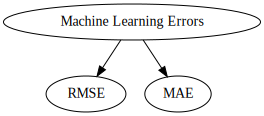

In [5]:
gra

In [6]:
print(gra.source)

digraph {
	a [label="Machine Learning Errors"]
	b [label=RMSE]
	c [label=MAE]
	a -> b
	a -> c
}


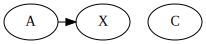

In [7]:
gra = Digraph()
with gra.subgraph() as i:

    i.attr(rank='same')

    i.node('A')

    i.node('X')

gra.node('C')
gra.edges(['AX'])
gra


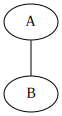

In [8]:
import graphviz
g = graphviz.Graph()
g.node('A')
g.node('B')
g.edge('A','B')
g

# load functions 
# load the datasets, set cutoff values, correlation method (these are done individually so the system saves them globallly)

In [9]:
gtex_toil_dataset = '../gtex_RSEM_gene_tpm.gz'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_toil_pancanc = "../gtex_and_tcga/tcga_RSEM_gene_tpm.gz"
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
tcga_toil_sampinfo = "../gtex_and_tcga/TCGA_phenotype_denseDataOnlyDownload.tsv.gz"
tcga_toil_clincinfo = "../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp"
opposing_corr_cutoff = 0.1


In [10]:
#functions for data processing
def gtex_data_processing(gtex_toil_dataset):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']
    gtex_breast_data_all = pd.read_csv(gtex_toil_dataset,sep='\t')
    gtex_breast_data_all=gtex_breast_data_all.set_index('sample').copy()

    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    gtex_breast_data_all.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    gtex_breast_data_all=gtex_breast_data_all.loc[gtex_breast_data_all.index.isin(list(gene_map.id.values))]
    gtex_breast_data_all=pd.concat([gtex_breast_data_all,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:gtex_breast_data_all.shape[1]]
    gtex_breast_data_all=gtex_breast_data_all.T.astype('float').copy()
    df_int = gtex_breast_data_all.copy()
    #drop unwanted integrins    
    df_int=df_int.drop([undesired_integrin for undesired_integrin in df_int.columns if undesired_integrin in unwanted_integrins],axis=1)
    #drop duplicate gene names (if any) 
    df_int=df_int.loc[:,~df_int.columns.duplicated()]    
    
    gtex_toil_phenotype = pd.read_csv('../GTEX_phenotype.gz',sep='\t')
    #subset for breast
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype['body_site_detail (SMTSD)']=='Breast - Mammary Tissue']
    #subset for female gender
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype._gender=='female']

    #select breast female gtex gene expression data
    df_int=df_int.loc[df_int.index.isin(gtex_toil_phenotype.Sample.values)].copy()
    
    return df_int

def tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    global tcga_brca_df, tcga_brca_sample_info
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    #tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
 
    #separate normal and primtum (remember primary tumor contains multiple stages)
    tcga_brca_normal_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Solid Tissue Normal']
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']

    #drop index of samples not in tcga_brca_df
    tcga_brca_normal_patients = tcga_brca_normal_patients.drop(non_match for non_match in tcga_brca_normal_patients.index.values if non_match not in tcga_brca_df.columns)
    tcga_brca_primtum_patients = tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 


    #make sure both normal and tumor patients match, and drop patients not in tcga_brca_df
    matched_patient_index_list=[]
    for patient in tcga_brca_primtum_patients._PATIENT.values:
        if patient in tcga_brca_normal_patients._PATIENT.values and patient in ['-'.join(patient_id.split('-')[0:3]) for patient_id in tcga_brca_df.columns]:
            matched_patient_index_list.append(tcga_brca_sample_info[tcga_brca_sample_info._PATIENT==patient].index.values)
    matched_patient_list=tcga_brca_sample_info.loc[[x for l in matched_patient_index_list for x in l]].copy()


    # matched_patient_id_list=pd.Index(tcga_brca_normal_patients['_PATIENT']).intersection(pd.Index(tcga_brca_primtum_patients['_PATIENT']))
    # matched_patient_index_list=tcga_brca_sample_info[tcga_brca_sample_info._PATIENT.isin(matched_patient_id_list)].index.values
    # matched_patient_list = tcga_brca_sample_info.loc[[l for l in matched_patient_index_list]].copy()
    # #ensure samples are present in tcga_brca_df
    # matched_patient_list=matched_patient_list.loc[matched_patient_list.index.intersection(pd.Index(tcga_brca_df.columns))]

    #separate normal and primary tumor
    normal_matched_patient_list=matched_patient_list[matched_patient_list.sample_type=='Solid Tissue Normal']
    primtum_matched_patient_list = matched_patient_list[matched_patient_list.sample_type=='Primary Tumor']

    #matched normal and primary tumor samples
    tcga_brca_df_normal_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(normal_matched_patient_list.index.values)]]
    tcga_brca_df_primtum_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(primtum_matched_patient_list.index.values)]]

    #test to see if normal and primary tumor patient IDs are a match
    for i in [patient_id.split('-')[2] for patient_id in tcga_brca_df_normal_matched.columns]:
        if i not in [patient_id.split('-')[2] for patient_id in tcga_brca_df_primtum_matched.columns]:
            print('trouble')

    #TCGA brca normal ALL
    tcga_brca_df_normal_all = tcga_brca_df.T.loc[tcga_brca_normal_patients.index.values].copy()
    # dataframe with all TCGA primary tumor samples (not necessarily matched)
    tcga_brca_df_primtum_all= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_normal_matched':tcga_brca_df_normal_matched,
           'tcga_brca_df_primtum_matched':tcga_brca_df_primtum_matched,
           'tcga_brca_df_normal_all':tcga_brca_df_normal_all,
           'tcga_brca_df_primtum_all':tcga_brca_df_primtum_all}

def correlation_selected_gene(provided_dataset,interest_gene,correlation_method):
    dataset_corr = provided_dataset.corrwith(provided_dataset[interest_gene],
                                             method=correlation_method).drop(interest_gene)
    dataset_corr = dataset_corr.dropna(axis=0,how='any')
    idx = dataset_corr.index.drop_duplicates(keep=False)
    dataset_corr = dataset_corr.loc[idx]
    return dataset_corr
def pairwise_pearson_correlation(provided_dataset):
    #columns have to be variables and rows have to be observations
    pairwise_corr=pd.DataFrame(np.corrcoef(provided_dataset,rowvar=False),
                               columns=provided_dataset.columns,index=provided_dataset.columns)



In [11]:
def early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    

    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']
    
    #stage I and II only
    #early_stages=['Stage IIB', 'Stage IA','Stage IIA','Stage I','Stage IB','Stage II']    
    
    #stage I only
    early_stages=[ 'Stage IA','Stage I','Stage IB']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(early_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary early stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_early_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_early_stage':tcga_brca_df_primtum_early_stage}

def late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]    
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    
    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info

    late_stages=['Stage IIIA', 'Stage IV','Stage IIIC','Stage IIIB','Stage III']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(late_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary late stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_late_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_late_stage':tcga_brca_df_primtum_late_stage}


In [12]:
#functions for counting
def count_genes_3_no_overlap(interest_gene,correlation_method,gtex_dataset,dataset2,dataset3):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    first_dataset_name = 'gtex_all'
    second_dataset_name= 'tcga_normal_all'
    third_dataset_name= 'tcga_primtum_all'
    names = [first_dataset_name,second_dataset_name,third_dataset_name]
    j=0
    for dataset in [gtex_dataset,dataset2,dataset3]:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[names[j]]=dataset.shape[0]
        j+=1
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'corr_with_{interest_gene}'])
    return display(HTML(dict_pd_df.to_html()))    
def count_genes_same_3(interest_gene,correlation_method,gtex_dataset,dataset2,dataset3):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(dataset2,interest_gene,correlation_method)
    dataset3=correlation_selected_gene(dataset3,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index).intersection(dataset3.index)
    global new_dataset
    new_dataset = pd.concat([gtex_dataset[common_gene_list],
                             dataset2[common_gene_list],
                             dataset3[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    second_dataset_name= 'tcga_normal_all'
    third_dataset_name= 'tcga_primtum_all'
    new_dataset.columns=[first_dataset_name,second_dataset_name,third_dataset_name]
    print("1st: common genes identified for all 3 datasets\n2nd: they were counted")
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_all_same_genes'],
                             columns=[first_dataset_name,second_dataset_name,third_dataset_name])
    return display(HTML(dict_pd_df.to_html()))
def count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,*processed_datasets):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    j=0
    for dataset in processed_datasets:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[input(f'insert name for {j+1}th dataset')]=dataset[dataset>=correlation_cutoff].shape[0]
        
        j+=1
    
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'HIGHLY_correlated_with_{interest_gene}'])
    #return display(HTML(dict_pd_df.to_html()))
    return dict_pd_df
def cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name=input('insert name for other dataset')
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other dataset\n3rd: both datasets combined\n4th: High cutoff applied to non-gtex dataset")
    
    new_dataset = new_dataset[new_dataset[other_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name=input('insert name for other dataset')
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other dataset\n3rd: both datasets combined\n4th: low cutoff applied to non-gtex dataset")
    
    new_dataset = new_dataset[new_dataset[other_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_highgtex_low_other'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: High cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return display(HTML(dict_pd_df.to_html()))
def cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: low cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return display(HTML(dict_pd_df.to_html()))

def cutoff_applied_togtex_3_high_all(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset,
                                    dataset3):
#dataset3 MUST BE tcga primtum all
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    gtex_dataset = gtex_dataset[gtex_dataset>=correlation_cutoff]
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset3=correlation_selected_gene(dataset3,interest_gene,correlation_method)
    common_gene_list= (gtex_dataset.index.intersection(dataset2.index)).intersection(dataset3.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],
                             dataset2[common_gene_list],
                            dataset3[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_cutoffmet'
    other_dataset_name='tcga_normal_all'
    dataset3_name = 'tcga_primtum_all'
    new_dataset.columns=[first_dataset_name,other_dataset_name,dataset3_name]
    print("1st: high cutoff applied to gtex dataset\n2nd: common genes identified with other datasets\n3rd: all datasets combined\n4th: High cutoff applied to non-gtex datasets")
    
    new_dataset = new_dataset[(new_dataset[other_dataset_name]>=correlation_cutoff) & (new_dataset[dataset3_name]>=correlation_cutoff)]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_all_same_genes'],
                             columns=[first_dataset_name,other_dataset_name,dataset3_name])
    return dict_pd_df



In [13]:
#organize as a table (original way -- before Jesse finalized the presentation but i used this for table 2)
# careful of the #ered data (e.g. #3 is #3 in both functions but presentation might be different)
def make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #1
    count_genes_3_no_overlap(interest_gene,correlation_method,df_int,tcga_brca_df_normal_all,tcga_brca_df_primtum_all)
    #2
    count_genes_same_3(interest_gene,correlation_method,df_int,tcga_brca_df_normal_all,tcga_brca_df_primtum_all)
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #5
    print('for dataset ENTER: tcga_normal_all')    
    cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('for dataset ENTER: tcga_normal_all')        
    cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_normal_all)
    #7
    print('for dataset ENTER: tcga_primtum_all')            
    cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #8
    print('for dataset ENTER: tcga_primtum_all')                
    cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    #9
    cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #10
    cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    return

In [14]:
#table 1
def organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #5
    print('for dataset ENTER: tcga_normal_all')    
    number_5=cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #7
    print('for dataset ENTER: tcga_primtum_all')            
    nnumber_7=cutoff_applied_togtex_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    #10
    number_10=cutoff_applied_togtex_3_high_all(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all,
                                    tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='GTEX_highly_correlated'
    third_column_name='%also_highly_correlated_in_TCGA_normal'
    fourth_column_name='%also_highly_correlated_in_TCGA_primtum'
    fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_5.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_5.iloc[0,0])})',
                                     str(format((nnumber_7.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(nnumber_7.iloc[0,0])})',
                                     str(format((number_10.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_10.iloc[0,0])})',
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))

def organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('for dataset ENTER: tcga_normal_all')        
    number_6=cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_normal_all)
    #8
    print('for dataset ENTER: tcga_primtum_all')                
    number_8=cutoff_applied_togtex_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,df_int,tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='GTEX_highly_correlated'
    third_column_name='%lowly_correlated_in_TCGA_normal'
    fourth_column_name='%lowly_correlated_in_TCGA_primtum'
    #fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_6.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_6.iloc[0,0])})',
                                     str(format((number_8.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_8.iloc[0,0])})'
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))

#table 3
def organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    
    gtex_expression_mean = df_int[interest_gene].mean()
    gtex_expression_stdev= df_int[interest_gene].std()
    
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_normal_all')
    number_3_tcga_normal=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #3
    print('for 1th dataset ENTER: gtex_all')
    print('for 2th dataset ENTER: tcga_primtum_all')
    number_3_tcga_primtum=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    

    first_column_name='Integrin' #index
    second_column_name='GTEX_expression_mean_&_stdev'
    third_column_name='GTEX_highly_correlated'
    fourth_column_name='highly_correlated_in_TCGA_normal'
    fifth_column_name='highly_corelated_in_TCGA_primtum'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[f'{format(gtex_expression_mean,"0.2f")} + {format(gtex_expression_stdev,"0.2f")}',
                                     str(number_3_tcga_normal.iloc[0,0]),
                                     str(number_3_tcga_normal.iloc[0,1]),
                                     str(number_3_tcga_primtum.iloc[0,1])]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))
    
def organize_tcga_gtex_table4(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
#designed for custom changes to helper functions in below cell (way down below)
#some helper functions appear twice because too many input variables so i made changes 
#changes in same cell as table 4 function
    df_int=gtex_data_processing(gtex_gct_dataset)
    tcga_data=tcga_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)
    tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
    tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
    #3
    print('its TCGA_primtum_all')

    number_3=count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,'tcga_primtum',tcga_brca_df_primtum_all)
    #4
    #print('for 1th dataset ENTER: gtex_all')
    #print('for 2th dataset ENTER: tcga_normal_all')    
    #4 is not very meaningful
    #count_high_corr_genes_with_overlap(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_normal_all)
    #6
    print('common gene list applied to all')
    print('high tcga_primtum and low tcga normal')        
    number_6=cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,
                                              tcga_brca_df_normal_all,tcga_brca_df_primtum_all,'tcga_normal')
    #8
    print('high tcga_primtum and low gtex')                
    number_8=cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,
                                              df_int,tcga_brca_df_primtum_all,'gtex_all')
    #9a
    print('high tcga primtum, high gtex')
    number_9a = cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,df_int,tcga_brca_df_primtum_all)
    first_column_name='Integrin' #index
    second_column_name='TCGA_tumor_highly_correlated'
    third_column_name='%lowly_correlated_in_TCGA_normal'
    fourth_column_name='%lowly_correlated_in_gtex'
    fifth_column_name = '%highly_corelated_in_gtex'
    #fifth_column_name='%also_highly_correlated_in_all_three'
    #ignoring first column name. setting index as integrin name (first column name)
    dict_pd_df = pd.DataFrame(data=[[number_3.iloc[0,0],
                                     str(format((number_6.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_6.iloc[0,0])})',
                                     str(format((number_8.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_8.iloc[0,0])})',
                                     str(format((number_9a.iloc[0,0]/number_3.iloc[0,0])*100,'2f'))+f'({str(number_9a.iloc[0,0])})'
                                    ]],
                              columns=[second_column_name,third_column_name,
                                      fourth_column_name,fifth_column_name],
                              index=[interest_gene])
    return display(HTML(dict_pd_df.to_html()))
    
    


In [15]:
#files loading
df_int=gtex_data_processing(gtex_toil_dataset)
tcga_data=tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)
tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
tcga_brca_df_normal_matched=tcga_data['tcga_brca_df_normal_matched']
tcga_brca_df_primtum_matched=tcga_data['tcga_brca_df_primtum_matched']
tcga_brca_df_primtum_early_stage=early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_early_stage']
tcga_brca_df_primtum_late_stage=late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_late_stage']


before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158


In [16]:
tcga_brca_df_normal_matched

,TCGA-E2-A153-11,TCGA-BH-A0BQ-11,TCGA-BH-A204-11,TCGA-E9-A1RF-11,TCGA-A7-A13F-11,TCGA-AC-A23H-11,TCGA-BH-A0HA-11,TCGA-A7-A0CE-11,TCGA-BH-A0HK-11,TCGA-BH-A0B7-11,...,TCGA-BH-A18K-11,TCGA-E2-A1IG-11,TCGA-BH-A0DG-11,TCGA-BH-A1FM-11,TCGA-BH-A1FC-11,TCGA-BH-A0H7-11,TCGA-BH-A1F0-11,TCGA-BH-A1EN-11,TCGA-E9-A1RC-11,TCGA-E2-A15K-11
gene,,,,,,,,,,,,,,,,,,,,,
RAB4B,5.1776,4.4108,3.8876,3.7950,4.2987,3.1028,3.6950,5.2799,4.5274,4.4122,...,4.3206,4.6041,4.0713,4.2419,5.0562,4.3681,4.4027,4.3499,4.3716,5.2747
TIGAR,3.0056,2.3077,1.9340,1.9601,2.1247,0.8726,1.2576,2.3564,2.9784,2.3677,...,2.0183,3.1095,2.1114,2.7951,3.0654,1.3109,2.5288,2.3704,1.9786,1.3623
RNF44,4.6972,4.5349,2.9090,2.9765,4.1343,3.3407,4.7016,4.0858,4.0216,4.7442,...,4.7613,4.0952,4.3328,3.9496,4.1078,3.8993,3.9431,3.6994,3.1765,3.7550
DNAH3,-1.7322,-1.5951,-5.0116,-4.2934,-5.0116,-2.3884,-5.0116,-3.4580,-5.0116,-2.6349,...,-2.0529,-2.4659,-2.8262,-1.9942,-2.9324,-3.3076,-5.0116,-5.0116,-6.5064,-9.9658
RPL23A,10.0921,10.5473,9.9437,9.9067,10.4163,11.0965,10.9753,10.7251,10.7876,10.8137,...,10.5153,10.2721,10.9925,10.5979,10.3529,10.3948,10.4049,10.1203,9.6112,10.2819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CYP4F2,-3.6259,-9.9658,-9.9658,-9.9658,-5.0116,-4.6082,-6.5064,-6.5064,-3.8160,-3.3076,...,-3.6259,-9.9658,-6.5064,-9.9658,-5.5735,0.6239,-4.0350,-9.9658,-9.9658,-9.9658
TENM1,-1.8836,-0.6643,-0.6193,0.7664,-1.0862,-1.5522,-0.7346,-3.0469,-1.9379,-0.9686,...,-1.3548,-1.6850,-1.0862,-2.8262,-3.1714,-3.6259,-2.7274,-2.1779,-0.4325,-3.3076
BATF3,0.8164,1.7403,1.8119,1.8762,1.1250,0.5955,0.1257,2.3394,2.8158,-0.0725,...,1.1250,1.3109,0.5666,1.3511,2.6255,0.6239,1.2209,1.5950,0.9789,2.0360


In [21]:
#test
test_df_int=correlation_selected_gene(df_int,interest_gene,correlation_method)
test_tcga_brca_df_normal_all=correlation_selected_gene(tcga_brca_df_normal_all,interest_gene,correlation_method)
test_tcga_brca_df_primtum_all=correlation_selected_gene(tcga_brca_df_primtum_all,interest_gene,correlation_method)

In [22]:
test_df_int[test_df_int>=correlation_cutoff]

Description
PLEKHN1          0.737729
AGRN             0.832636
RP11-465B22.3    0.614809
C1orf159         0.626508
INTS11           0.667310
                   ...   
MTM1             0.617390
MTMR1            0.785413
ZNF185           0.803545
BRCC3            0.616336
RAB39B           0.667438
Length: 4047, dtype: float64

In [23]:
#dataset_corr = dataset_corr.dropna(axis=0,how='any')
    #idx = dataset_corr.index.drop_duplicates(keep=False)
    #dataset_corr = dataset_corr.loc[idx]

# heatmap for expression vs integrin

In [33]:
heatmap_df = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].copy()

heatmap_df.mean()


gene
ITGA10    3.579545
ITGAD    -4.286682
ITGAM     2.159924
ITGA3     5.095033
ITGBL1    3.315321
ITGAE     4.753785
ITGA2     1.586592
ITGB3     2.067059
ITGA7     6.832596
ITGB8     2.448926
ITGAX     2.543840
ITGAV     4.190931
ITGB6     2.636786
ITGB7     1.100666
ITGA5     6.266535
ITGB4     6.259103
ITGB2     4.027357
ITGA6     5.557185
ITGA2B    0.320877
ITGB1     7.546813
ITGAL     1.844824
ITGA9     2.375535
ITGB5     6.504485
ITGA8     0.581589
ITGA4     1.541030
ITGA1     3.824854
ITGA11    1.867581
dtype: float64

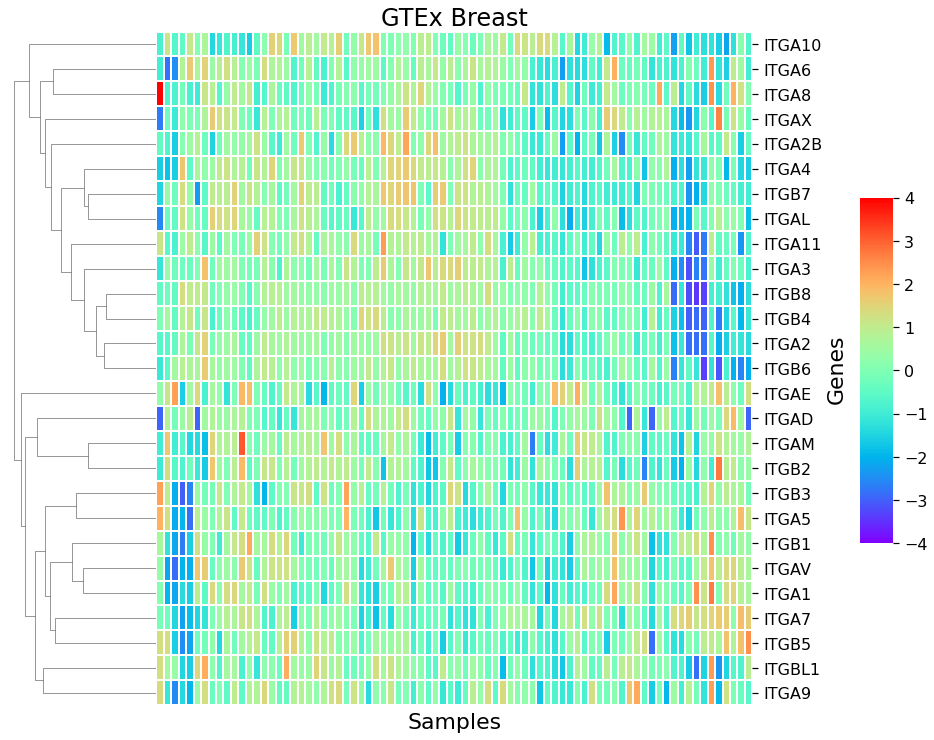

In [16]:
heatmap_df = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].copy()

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()

ax = sns.clustermap(heatmap_df.T, cmap='rainbow', row_cluster=True, col_cluster=True,
                    method='average', metric='cityblock', linewidths=0.01, 
                    fmt='', figsize=(15,12), annot_kws={"size": 20}, vmin=-4,vmax=4, xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('GTEx Breast',fontsize=24)
ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Genes', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(True) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/gtex_breast_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df

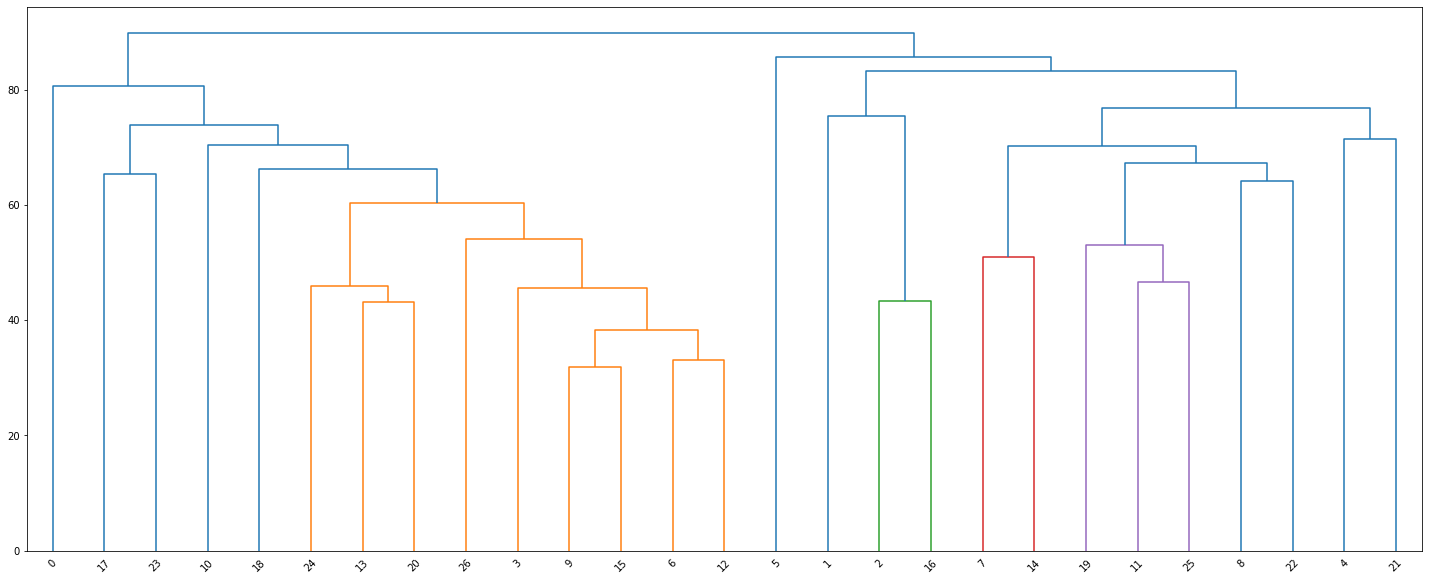

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
heatmap_df = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].copy()

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


Z = linkage(heatmap_df.T, method='average',metric='cityblock')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [27]:
heatmap_df.T

,GTEX-X4EP-2926-SM-3P5YQ,GTEX-11P81-1926-SM-5BC53,GTEX-13FTY-2226-SM-5J1ND,GTEX-S32W-2026-SM-4AD6E,GTEX-13O3O-0826-SM-5K7WE,GTEX-13QIC-2326-SM-5LU5N,GTEX-VJWN-0726-SM-3GIJ8,GTEX-131YS-0626-SM-5EGKL,GTEX-T6MO-0326-SM-32QOK,GTEX-11ILO-2226-SM-5A5L1,...,GTEX-XMD2-0926-SM-4WWEF,GTEX-X15G-1626-SM-3NMB3,GTEX-13N11-1726-SM-5J1OJ,GTEX-ZQG8-0726-SM-5P9H9,GTEX-YB5K-1626-SM-5IFIN,GTEX-R53T-1526-SM-48FEK,GTEX-ZAJG-0626-SM-5HL8X,GTEX-ZXES-0826-SM-5E43C,GTEX-TML8-1226-SM-32QON,GTEX-1117F-2826-SM-5GZXL
gene,,,,,,,,,,,,,,,,,,,,,
ITGA10,-0.407825,0.206165,0.317064,0.152313,-0.598202,0.215747,0.008583,0.060653,1.429021,-1.108054,...,-0.537294,0.410878,0.340759,-1.738237,-0.449273,-1.602009,0.457451,1.794919,-0.887816,0.548814
ITGAD,1.096666,1.025524,-1.154357,0.509169,-0.669206,-0.669206,-2.953408,0.509169,-1.154357,0.430954,...,0.946892,-0.376991,0.810900,-1.154357,-0.376991,-0.003493,-2.953408,0.704291,0.704291,-1.154357
ITGAM,-0.016997,0.270978,-1.618788,0.395243,0.027413,0.420620,-1.400187,-0.146779,-0.385930,0.748867,...,-0.296145,0.163263,0.661427,0.794105,-1.753811,0.130163,-0.451855,-0.316833,0.935334,-1.540036
ITGA3,1.386876,0.124908,1.576113,-0.265413,-0.017671,0.831298,0.015988,0.561165,-0.811023,0.470302,...,-0.520089,0.858022,0.776982,-3.185736,-2.473423,-0.139158,-0.326662,0.965497,0.560731,-0.362632
ITGBL1,0.107071,0.724102,0.374155,-0.805496,0.900103,0.206267,1.417722,0.238936,-0.331147,-0.731071,...,0.214489,0.127407,-0.244499,-1.675982,-0.746216,0.311197,-0.129617,1.300244,0.583907,0.253648
ITGAE,-1.398414,-0.251085,-0.340370,-0.253091,-1.165003,-0.377154,1.386476,-0.238043,-0.352074,0.296664,...,-0.578463,-1.106148,1.475427,-0.721587,-0.176514,1.867345,-0.279509,-0.159793,-0.053788,-0.243728
ITGA2,0.587124,0.902859,1.542303,-1.172527,-0.259301,0.982741,1.102564,0.516840,0.493154,0.286250,...,-0.085914,0.509796,0.519162,-2.817154,-1.110525,-0.420536,-0.110296,0.469003,0.647035,-0.431373
ITGB3,1.412143,-0.748991,1.174700,0.614691,0.712382,-1.954253,0.353105,-1.188908,0.079946,1.066805,...,0.063394,-0.257179,0.317514,-0.611353,-0.433768,0.574620,0.281300,-0.179774,0.732418,1.593835
ITGA7,-1.231495,0.271145,-0.681213,1.862947,-1.327973,-0.718137,-1.497788,-1.053513,0.736350,0.438833,...,-0.632293,0.006044,-0.061253,1.602355,1.465550,1.220186,-1.385570,-1.783138,0.707849,-0.526627


/home/hshadman/.local/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


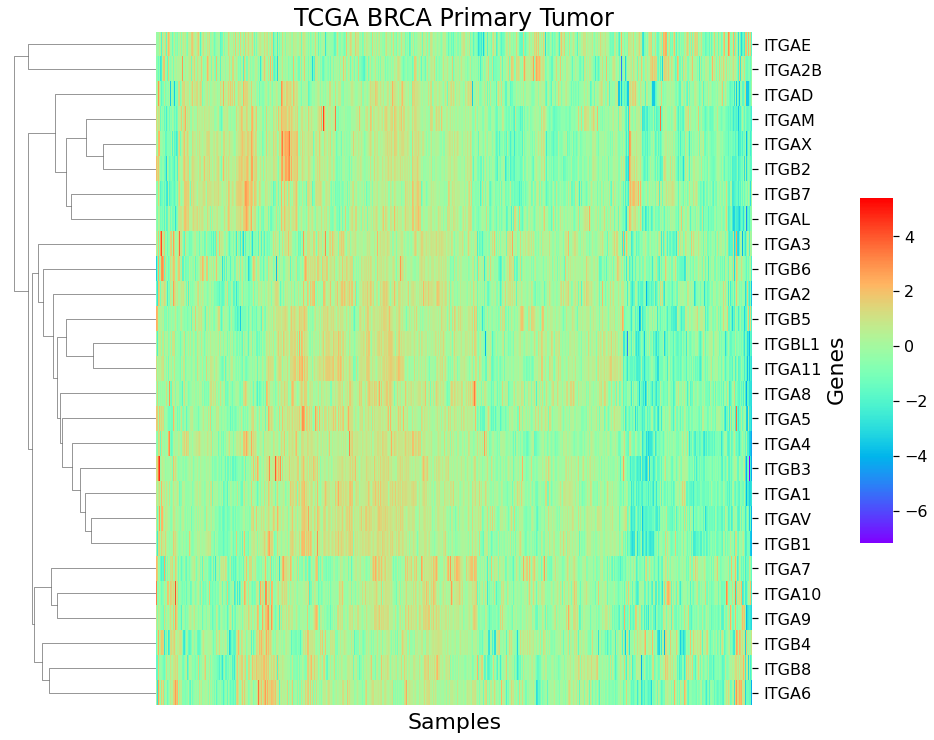

In [31]:
heatmap_df = tcga_brca_df_primtum_all[tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains('ITG')]]

#convert to Z-score
heatmap_df = (heatmap_df-heatmap_df.mean())/heatmap_df.std()


#no linewidths entry in here, too many samples for TCGA BRCA
ax = sns.clustermap(heatmap_df.T, cmap='rainbow', row_cluster=True, col_cluster=True,
                    method='average', metric='cityblock', 
                    fmt='', figsize=(15,12), annot_kws={"size": 20},  xticklabels=False)


#ax.tick_params(axis='x', labelrotation=90, labelsize=18, size=6, width=1.2, pad=10,visible=False)

ax.tick_params(axis='y', labelrotation=0, labelsize=16, size=6, width=1.2, pad=5)
ax.ax_heatmap.set_title('TCGA BRCA Primary Tumor',fontsize=24)
ax.ax_heatmap.set_xlabel('Samples', fontsize=22)
ax.ax_heatmap.set_ylabel('Genes', fontsize=22)
# ax.collections[0].set_clim(-2,2)  
# need to fix color bar tickmarks and position

ax.fig.subplots_adjust(right=0.7)
ax.ax_cbar.set_position((0.8, .2, .03, .4))

ax.ax_row_dendrogram.set_visible(True) 
ax.ax_col_dendrogram.set_visible(False) 
#plt.savefig(f'figures/tcga_brca_expr_int_clustermap.png', dpi = 1000, bbox_inches='tight')
del heatmap_df


# star protocols paper

# link to star protocols paper: https://star-protocols.cell.com/protocols/1689

In [16]:

#import pingouin as pg
import gseapy as gp

In [34]:
#gtex_network_df=pd.read_csv('gtex_network_df_star_protocols_mcdonald2022.csv')
#tcga_primtum_all_network_df=pd.read_csv('tcga_primtum_all_network_df_star_protocols_mcdonald2022.csv')
correlation_cutoff


0.6

In [35]:
#first getting pairwise correlation coefficient
gtex_itg_corr_network=pd.DataFrame(np.corrcoef(df_int,rowvar=False),
                                      columns=df_int.columns,index=df_int.columns)
#filtering out integrins
gtex_itg_corr_network=gtex_itg_corr_network[gtex_itg_corr_network.columns[gtex_itg_corr_network.columns.str.contains('ITG')]]
#only those with >=correlation_cutoff coefficient
gtex_itg_corr_network=gtex_itg_corr_network[gtex_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
#more than self_correlation
gtex_corr_itg_list=gtex_itg_corr_network.count()[gtex_itg_corr_network.count()>1].index
corr_list={}
pval_corr_list=[]
for integrin in gtex_corr_itg_list:
    corr_list[integrin]=gtex_itg_corr_network[integrin].dropna(axis=0).index
    
#just some not-useful code here, previously used to subset those with pval<0.05
#now doing pval<0.05 AND pval>=0.05, basically not caring about pval
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(df_int[integrin].values,df_int[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
gtex_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        gtex_network['node1'].append(integrin)
        gtex_network['node2'].append(gene)
        gtex_network['correlation_strength'].append(pearsonr(df_int[integrin].values,df_int[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])
del running_gene_integrin_list

#establish new df
gtex_network_df=pd.DataFrame(gtex_network)
#remove self-correlation such as ITGAD correlation coefficient with itself
#also reset index with the removed df
gtex_network_df=gtex_network_df.loc[[x for x in gtex_network_df.index if gtex_network_df.loc[x].node1!=gtex_network_df.loc[x].node2]].reset_index(drop=True)
del gtex_network, gtex_itg_corr_network


/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [43]:
gtex_network_df


,node1,node2,correlation_strength
0,ITGA10,EVPL,0.655946
1,ITGA10,DDR1,0.607552
2,ITGA10,ZNF425,0.619213
3,ITGA10,ULK1,0.673472
4,ITGA10,PIGO,0.619894
...,...,...,...
24515,ITGA11,SLC45A3,0.671851
24516,ITGA11,IQCB1,0.612497
24517,ITGA11,TIGD1,0.610385
24518,ITGA11,PRNP,0.604967


In [59]:
# find connected to at least 3 integrins
genes_at_least3 = gtex_network_df['node2'].value_counts()[gtex_network_df['node2'].value_counts()>=3].index
print(genes_at_least3[~(genes_at_least3.str.contains('ITG'))])
del genes_at_least3

Index(['APBB3', 'CEP44', 'NICN1', 'RALGPS1', 'L3MBTL1', 'RNF44', 'MKS1',
       'KDM2B', 'CBFA2T2', 'GGA2',
       ...
       'ALG13', 'WDR70', 'CFAP36', 'PLEKHG3', 'MIPOL1', 'BARX1', 'NEMF',
       'LCLAT1', 'PPP6R3', 'BANP'],
      dtype='object', length=3916)


In [119]:
arbitrary_genes=[]
for gene in gtex_network_df['node2'].value_counts()[gtex_network_df['node2'].value_counts()>=5].index:
    if gtex_network_df[gtex_network_df.node2==gene].correlation_strength.mean()>=0.80:
        print(gene, gtex_network_df[gtex_network_df.node2==gene].correlation_strength.mean())
        arbitrary_genes.append([gene, gtex_network_df[gtex_network_df.node2==gene].correlation_strength.mean()])

IRF6 0.8002747655915552
ANO1 0.8073432269618689
FAM189A2 0.8149883076848556
CDS1 0.812728409982613
SPINT1 0.8044176250171527
CA13 0.802778570892634
SH2D3A 0.8196614054393985
DSP 0.8102610180119125
EPS8L2 0.8094669003206564
SH3YL1 0.8035680226283431
GRB7 0.8012787670386041
MPZL3 0.8203167401137943
INADL 0.8096556264295742
DTNB 0.8058661028616894
WNK2 0.8004944607485559
RASAL1 0.8006649096570341
LAD1 0.8062231913862391
SFN 0.802946873918677
CCDC64B 0.8006261477582599
CELF5 0.8003862634775525
D4S234E 0.8087001196591549
SLC35F3 0.8006444921234245
SPINT2 0.8196472828385305
PROM1 0.8136460757675309
BSPRY 0.819772628991091
PROM2 0.8250965259841389
SCNN1A 0.8052144820573661
CDH1 0.8121430681882822
KRT18 0.8146616689589544
CDH3 0.8312850571876824
ST6GALNAC5 0.8130294141957748
GPRIN2 0.8079135229657781
LRRC4C 0.8063581869743519
HOMER2 0.8009259275372307
ESRP1 0.8002807386663738
STAP2 0.8114513716990986
KRT8 0.8118978205516992
C1orf116 0.8053958355814427
SERPINB5 0.8034587374930202
F2RL1 0.837202

In [120]:
len(arbitrary_genes)

65

In [121]:
gtex_network_df[gtex_network_df.node2.isin(np.array(arbitrary_genes)[:,0])].node1.value_counts()


ITGB6     65
ITGB8     65
ITGA2     65
ITGB4     65
ITGA3     60
ITGA10     9
ITGA4      8
ITGA11     6
Name: node1, dtype: int64

In [117]:
gtex_network_df[(gtex_network_df.node2.isin(np.array(arbitrary_genes)[:,0])) & (gtex_network_df.node1=='ITGA3')]

(60, 3)

In [44]:
#checking for self-correlation
gtex_network_df[(gtex_network_df.node2.str.contains('ITG')) & (gtex_network_df.node1.str.contains('ITG'))]

,node1,node2,correlation_strength
248,ITGA10,ITGB4,0.692866
449,ITGAM,ITGB2,0.750711
1655,ITGA3,ITGA2,0.841350
1968,ITGA3,ITGB8,0.723497
2160,ITGA3,ITGB6,0.658074
2397,ITGA3,ITGB4,0.696160
3231,ITGA3,ITGA4,0.612417
5794,ITGA2,ITGB8,0.872720
6048,ITGA2,ITGB6,0.832461
6138,ITGA2,ITGB7,0.622800


In [45]:
tcga_primtum_all_itg_corr_network=pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_all,rowvar=False),
                                      columns=tcga_brca_df_primtum_all.columns,index=tcga_brca_df_primtum_all.columns)
tcga_primtum_all_itg_corr_network=tcga_primtum_all_itg_corr_network[tcga_primtum_all_itg_corr_network.columns[tcga_primtum_all_itg_corr_network.columns.str.contains('ITG')]]
tcga_primtum_all_itg_corr_network=tcga_primtum_all_itg_corr_network[tcga_primtum_all_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
tcga_primtum_all_corr_itg_list=tcga_primtum_all_itg_corr_network.count()[tcga_primtum_all_itg_corr_network.count()>1].index

#just some not-useful code here, previously used to subset those with pval<0.05
#now doing pval<0.05 AND pval>=0.05, basically not caring about pval
#just like with the gtex_network_df code above
corr_list={}
pval_corr_list=[]
for integrin in tcga_primtum_all_corr_itg_list:
    corr_list[integrin]=tcga_primtum_all_itg_corr_network[integrin].dropna(axis=0).index
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(tcga_brca_df_primtum_all[integrin].values,tcga_brca_df_primtum_all[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
tcga_primtum_all_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        tcga_primtum_all_network['node1'].append(integrin)
        tcga_primtum_all_network['node2'].append(gene)
        tcga_primtum_all_network['correlation_strength'].append(pearsonr(tcga_brca_df_primtum_all[integrin].values,tcga_brca_df_primtum_all[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])
del running_gene_integrin_list

tcga_primtum_all_network_df=pd.DataFrame(tcga_primtum_all_network)
#remove self-correlation just like with gtex_network_df and reset index values
tcga_primtum_all_network_df=tcga_primtum_all_network_df.loc[[x for x in tcga_primtum_all_network_df.index if tcga_primtum_all_network_df.loc[x].node1!=tcga_primtum_all_network_df.loc[x].node2]].reset_index(drop=True)

del tcga_primtum_all_network, tcga_primtum_all_itg_corr_network


In [130]:
tcga_primtum_all_network_df.node2.value_counts()[tcga_primtum_all_network_df.node2.value_counts()>=3].value_counts()

3     361
4     194
5     130
6      89
7      36
8      23
9       7
10      1
Name: node2, dtype: int64

In [122]:
# find connected to at least 3 integrins
genes_at_least3 = tcga_primtum_all_network_df['node2'].value_counts()[tcga_primtum_all_network_df['node2'].value_counts()>=3].index
print(genes_at_least3[~(genes_at_least3.str.contains('ITG'))])
del genes_at_least3

Index(['PLXNC1', 'FILIP1L', 'ZFPM2', 'CDH11', 'AKAP12', 'FSTL1', 'HEG1',
       'PDGFRB', 'VSTM4', 'LAMA4',
       ...
       'WDR36', 'CD96', 'MMP2', 'PDGFD', 'WDR82', 'DPYD', 'CD180', 'FRMD4B',
       'ADAM17', 'RAP1A'],
      dtype='object', length=838)


In [138]:
arbitrary_genes_TCGA=[]
for gene in tcga_primtum_all_network_df['node2'].value_counts()[tcga_primtum_all_network_df['node2'].value_counts()>=3].index:
    if tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2==gene].correlation_strength.mean()>=0.75:
        print(gene, tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2==gene].correlation_strength.mean())
        arbitrary_genes_TCGA.append([gene,
                                tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2==gene].correlation_strength.mean()])

CD4 0.753013538801545
NCKAP1L 0.7581450838747422
MYO1F 0.7528675556378527
LILRB4 0.7579235738936501
SPI1 0.7692263791362389
HAVCR2 0.7523009576989477
PTPN7 0.7677630697153108
DOK2 0.7624020732363302
SIGLEC9 0.7860868693476984
COL10A1 0.7526991795951758
COL1A2 0.7764736653722092
FCER1G 0.7508788624036372
FERMT3 0.805823638077932
LRRC25 0.7956715043927023
LUM 0.7660811870763656
SIGLEC7 0.7838997039929835
NFAM1 0.7534369789485349
AEBP1 0.7510605074344897


In [140]:
len(arbitrary_genes_TCGA)

18

In [139]:
tcga_primtum_all_network_df[tcga_primtum_all_network_df.node2.isin(np.array(arbitrary_genes_TCGA)[:,0])].node1.value_counts()


ITGAX     14
ITGB2     14
ITGAM     11
ITGB7      8
ITGBL1     4
ITGA11     4
ITGAL      4
ITGA4      3
ITGA5      3
ITGAV      1
Name: node1, dtype: int64

In [170]:
G_normal = nx.from_pandas_edgelist(gtex_network_df,'node1','node2')
G_cancer = nx.from_pandas_edgelist(tcga_primtum_all_network_df,'node1','node2')


In [174]:
len(G_normal.edges())

24520

In [175]:
list1 = G_cancer.nodes()
list2 = G_normal.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity =  float(intersection) / union

del list1, list2

Jaccard_similarity


0.1689453125

In [176]:
intersection

1384

In [26]:
#remnant from star protocols papers, where they determined hub gene
# n_genes = sorted(G_normal.degree, key=lambda x: x[1], reverse=True)
# threshold = int(len(n_genes) * 0.1)
# n_hubnodes = pd.DataFrame(n_genes,columns=['GeneId','Degree'])[0:threshold]['GeneId']

In [135]:
lost_nodes = G_normal.nodes() - G_cancer.nodes()

conserved_nodes = pd.Index(G_normal.nodes()).intersection(G_cancer.nodes())

Acquired_nodes = G_cancer.nodes() - G_normal.nodes()

lost_normal_nodes = len(lost_nodes)/len(G_normal.nodes())

conserved_normal_nodes = len(conserved_nodes)/len(G_normal.nodes())

acquired_cancer_nodes = len(Acquired_nodes)/len(G_cancer.nodes())



In [184]:
print('lost edges =',len(G_normal.edges() - G_cancer.edges()),sep='\t')
print('conserved edges =',pd.Index(G_cancer.edges()).intersection(G_normal.edges()).shape[0],sep='\t')

print('gained edges in primtum =',len(G_cancer.edges() - G_normal.edges()),sep='\t')


lost edges =	23517
conserved edges =	676
gained edges in primtum =	4639


In [57]:
gtex_network_df.sort_values(by='correlation_strength').node1.value_counts()

ITGA2     4437
ITGA3     3264
ITGB8     3210
ITGA4     2761
ITGB4     2674
ITGB6     2382
ITGB7     1207
ITGA11    1151
ITGA7      582
ITGAV      510
ITGAL      483
ITGA10     410
ITGA1      364
ITGA6      272
ITGB1      242
ITGA5      131
ITGB2       81
ITGAM       80
ITGA2B      75
ITGB5       49
ITGA8       43
ITGAX       34
ITGBL1      26
ITGB3       24
ITGAE       23
ITGA9        5
Name: node1, dtype: int64

In [59]:
len(G_cancer.edges())

5642

In [60]:
#network diagram works but just is too complicated
g_normal=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})

for norm_node in G_normal.nodes():
    g_normal.node(norm_node)
for edge in G_normal.edges():
    if edge in G_normal.edges()-G_cancer.edges():
        g_normal.edge(edge[0],edge[1],color='red')
    elif edge in [edge for edge in G_normal.edges() if edge in G_cancer.edges()]:
        g_normal.edge(edge[0],edge[1],color='green')
    else:
        g_normal.edge(edge[0],edge[1],color='blue')
#g_normal.render(filename='gtex_breast_network',directory='./',view = False, format='png')
g_normal

KeyboardInterrupt: 

In [61]:
#network diagram works but just is too complicated
g_cancer=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for norm_node in G_cancer.nodes():
    g_cancer.node(norm_node)
for edge in G_cancer.edges():
    if edge in G_cancer.edges()-G_normal.edges():
        g_cancer.edge(edge[0],edge[1],color='blue')
    elif edge in [edge for edge in G_cancer.edges() if edge in G_cancer.edges()]:
        g_cancer.edge(edge[0],edge[1],color='green')
    else:
        g_cancer.edge(edge[0],edge[1],color='blue')


#g_cancer.render(filename='tcga_BRCA_primtum_all_network',directory='./',view = False, format='png')
g_cancer


In [62]:
Jaccard_similarity

0.1689453125

# early_stage vs late_stage networking

In [63]:
tcga_brca_df_primtum_early_stage

gene,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
TCGA-A8-A08A-01,5.4754,2.6348,4.8729,-9.9658,10.3339,5.5214,1.5013,4.0001,0.0300,1.2147,...,3.3293,5.2758,2.9984,5.3583,4.7159,-9.9658,-5.0116,0.5470,5.3954,-9.9658
TCGA-E2-A15O-01,4.6657,3.5124,4.4829,0.4016,10.1423,5.8268,-0.0425,2.6418,0.0158,1.2992,...,3.9223,6.0579,2.9911,6.2536,4.2488,-3.8160,-6.5064,-0.9971,5.7570,-9.9658
TCGA-BH-A1FG-01,5.0734,2.1830,3.3148,-5.5735,10.8373,6.5854,0.1519,3.5362,-0.0725,1.2576,...,2.9581,4.8410,2.0878,5.3951,3.4894,-4.6082,-9.9658,0.0718,4.0799,-9.9658
TCGA-BH-A8FY-01,5.4640,1.2875,4.7528,-9.9658,10.3880,5.0286,-0.7346,1.6420,-0.3566,0.9191,...,3.4997,4.9327,3.4635,5.1198,4.7793,-1.1811,-6.5064,0.7832,4.9137,-9.9658
TCGA-E9-A54X-01,5.3198,2.0912,4.8038,0.2762,10.5867,5.5320,1.7489,3.3017,-3.6259,1.8762,...,3.3177,5.0751,3.2870,4.8115,4.5066,-9.9658,-3.8160,0.6517,5.0588,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E2-A106-01,6.4925,2.3394,4.6242,-2.1140,10.0870,6.3651,3.2587,3.8739,1.0151,1.7954,...,4.1946,4.9764,1.9034,5.5552,4.3046,-9.9658,-6.5064,-0.9971,5.6381,-9.9658
TCGA-AN-A0FF-01,5.7410,3.6600,4.3604,-5.0116,10.0865,5.6485,2.0465,4.6206,1.4962,2.1830,...,3.7982,4.8900,4.1186,5.5392,4.4660,-5.0116,-4.2934,0.6699,5.4026,-9.9658
TCGA-AO-A03U-01,4.7055,3.5657,4.0427,-6.5064,9.9888,5.5961,1.4174,-0.1665,2.7161,1.8363,...,4.2921,5.0828,4.1490,5.1219,2.6348,-9.9658,-6.5064,2.6873,5.1732,-9.9658
TCGA-BH-A0HA-01,5.8465,1.8643,3.6691,-5.5735,10.1991,4.9108,0.8883,2.6984,1.7229,1.4174,...,3.4661,4.9026,3.4384,6.5283,3.4197,-2.8262,-6.5064,1.3901,5.0781,-9.9658


In [64]:
tcga_brca_df_primtum_late_stage

gene,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
TCGA-AC-A6IX-06,5.323400,2.811700,5.073400,-2.826200,9.958800,5.610900,1.903400,3.963600,4.248800,2.488300,...,3.472600,5.579300,3.028700,5.533600,4.775600,-9.965800,-2.114000,1.275600,5.267600,-9.9658
TCGA-E2-A15A-06,5.899900,3.195500,4.970000,-2.114000,10.209500,6.171700,-2.634900,4.347000,1.700900,2.931900,...,3.936500,5.808200,3.070600,5.941800,3.669100,-1.780900,-4.608200,1.570900,5.314700,-9.9658
TCGA-A2-A25D-01,4.606500,2.087800,4.013600,-6.506400,11.309500,5.442300,0.949300,1.239400,1.125000,0.465700,...,2.342300,4.993300,4.004600,5.660500,3.087600,-9.965800,-5.573500,1.475600,5.005400,-9.9658
TCGA-AC-A3W6-01,5.801700,1.832300,4.593400,-3.625900,10.239600,5.074300,2.046500,1.766000,-0.072500,1.356700,...,3.876900,4.965400,4.137600,4.539800,3.807500,-6.506400,-2.932400,2.858200,5.178000,-9.9658
TCGA-BH-A1F8-01,5.061800,3.931800,4.399900,-1.639400,10.116400,6.537800,1.395600,5.608200,0.749300,2.077600,...,4.454200,5.971100,4.611800,6.418700,5.051900,-3.307600,-5.011600,-1.181100,4.858000,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A1HO-01,5.223500,2.333700,4.029500,-4.608200,10.585600,6.613500,-1.214200,5.413500,0.476100,2.689500,...,4.197000,4.538600,3.234300,5.808700,4.736700,-9.965800,-5.573500,0.299800,5.436000,-9.9658
TCGA-PL-A8LZ-01,5.543800,3.220500,4.567500,0.642500,9.535300,5.302400,5.998200,-0.997100,3.912700,2.518800,...,4.283300,5.391700,2.912800,5.857000,2.409000,-9.965800,-5.573500,3.085900,5.449600,-9.9658
TCGA-S3-A6ZH-01,6.297800,3.131100,4.955600,-3.458000,10.438100,6.280400,-0.267100,3.692800,1.766000,1.585400,...,3.992900,5.538600,2.811700,5.336700,5.151800,-9.965800,-2.826200,0.740700,6.115000,-9.9658
TCGA-AR-A0TQ-01,4.977300,2.618500,4.149800,-0.913200,10.372700,6.155600,0.757900,3.778300,2.269300,1.417400,...,3.709400,5.623000,4.250300,5.399200,5.661400,-4.035000,-3.458000,0.864700,5.872100,-9.9658


In [185]:
#early stage
tcga_primtum_all_early_stage_itg_corr_network=pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_early_stage,rowvar=False),
                                      columns=tcga_brca_df_primtum_early_stage.columns,index=tcga_brca_df_primtum_early_stage.columns)
tcga_primtum_all_early_stage_itg_corr_network=tcga_primtum_all_early_stage_itg_corr_network[tcga_primtum_all_early_stage_itg_corr_network.columns[tcga_primtum_all_early_stage_itg_corr_network.columns.str.contains('ITG')]]
tcga_primtum_all_early_stage_itg_corr_network=tcga_primtum_all_early_stage_itg_corr_network[tcga_primtum_all_early_stage_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
tcga_primtum_all_early_stage_corr_itg_list=tcga_primtum_all_early_stage_itg_corr_network.count()[tcga_primtum_all_early_stage_itg_corr_network.count()>1].index
corr_list={}
pval_corr_list=[]
for integrin in tcga_primtum_all_early_stage_corr_itg_list:
    corr_list[integrin]=tcga_primtum_all_early_stage_itg_corr_network[integrin].dropna(axis=0).index
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(tcga_brca_df_primtum_early_stage[integrin].values,tcga_brca_df_primtum_early_stage[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
tcga_primtum_all_early_stage_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        tcga_primtum_all_early_stage_network['node1'].append(integrin)
        tcga_primtum_all_early_stage_network['node2'].append(gene)
        tcga_primtum_all_early_stage_network['correlation_strength'].append(pearsonr(tcga_brca_df_primtum_early_stage[integrin].values,tcga_brca_df_primtum_early_stage[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])


#establish new df
tcga_primtum_all_early_stage_network_df=pd.DataFrame(tcga_primtum_all_early_stage_network)
#remove self-correlation 
#also reset index with the removed df
tcga_primtum_all_early_stage_network_df=tcga_primtum_all_early_stage_network_df.loc[[x for x in tcga_primtum_all_early_stage_network_df.index if tcga_primtum_all_early_stage_network_df.loc[x].node1!=tcga_primtum_all_early_stage_network_df.loc[x].node2]].reset_index(drop=True)
del tcga_primtum_all_early_stage_network, tcga_primtum_all_early_stage_itg_corr_network,running_gene_integrin_list




In [186]:
tcga_primtum_all_early_stage_network_df

,node1,node2,correlation_strength
0,ITGAD,LYZ,0.664412
1,ITGAD,IL10RA,0.608423
2,ITGAD,CD96,0.609139
3,ITGAD,LGALS2,0.652070
4,ITGAD,CRTAM,0.612132
...,...,...,...
7929,ITGA11,THBS2,0.858047
7930,ITGA11,STARD8,0.627688
7931,ITGA11,FHOD3,0.616873
7932,ITGA11,NOX4,0.756613


In [187]:
#late stage
tcga_primtum_all_late_stage_itg_corr_network=pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_late_stage,rowvar=False),
                                      columns=tcga_brca_df_primtum_late_stage.columns,index=tcga_brca_df_primtum_late_stage.columns)
tcga_primtum_all_late_stage_itg_corr_network=tcga_primtum_all_late_stage_itg_corr_network[tcga_primtum_all_late_stage_itg_corr_network.columns[tcga_primtum_all_late_stage_itg_corr_network.columns.str.contains('ITG')]]
tcga_primtum_all_late_stage_itg_corr_network=tcga_primtum_all_late_stage_itg_corr_network[tcga_primtum_all_late_stage_itg_corr_network>=correlation_cutoff].dropna(axis=1,how='all').dropna(axis=0,how='all')
tcga_primtum_all_late_stage_corr_itg_list=tcga_primtum_all_late_stage_itg_corr_network.count()[tcga_primtum_all_late_stage_itg_corr_network.count()>1].index
corr_list={}
pval_corr_list=[]
for integrin in tcga_primtum_all_late_stage_corr_itg_list:
    corr_list[integrin]=tcga_primtum_all_late_stage_itg_corr_network[integrin].dropna(axis=0).index
for integrin in corr_list.keys():
    for gene in corr_list[integrin]:
        if integrin!=gene and pearsonr(tcga_brca_df_primtum_late_stage[integrin].values,tcga_brca_df_primtum_late_stage[gene].values)[1]<0.05:
            pval_corr_list.append([integrin,gene])
        else:
            pval_corr_list.append([integrin,gene])
running_gene_integrin_list=[]
tcga_primtum_all_late_stage_network={'node1':[],'node2':[],'correlation_strength':[]}
for integrin,gene in pval_corr_list:
    if [integrin,gene] not in running_gene_integrin_list and [gene,integrin] not in running_gene_integrin_list:
        tcga_primtum_all_late_stage_network['node1'].append(integrin)
        tcga_primtum_all_late_stage_network['node2'].append(gene)
        tcga_primtum_all_late_stage_network['correlation_strength'].append(pearsonr(tcga_brca_df_primtum_late_stage[integrin].values,tcga_brca_df_primtum_late_stage[gene].values)[0])
    running_gene_integrin_list.append([integrin,gene])

tcga_primtum_all_late_stage_network_df=pd.DataFrame(tcga_primtum_all_late_stage_network)

tcga_primtum_all_late_stage_network_df=tcga_primtum_all_late_stage_network_df.loc[[x for x in tcga_primtum_all_late_stage_network_df.index if tcga_primtum_all_late_stage_network_df.loc[x].node1!=tcga_primtum_all_late_stage_network_df.loc[x].node2]].reset_index(drop=True)

del tcga_primtum_all_late_stage_network, tcga_primtum_all_late_stage_itg_corr_network,running_gene_integrin_list


/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [188]:
tcga_primtum_all_late_stage_network_df

,node1,node2,correlation_strength
0,ITGA10,TRABD2B,0.606591
1,ITGA10,NLGN3,0.601190
2,ITGA10,RHOJ,0.645732
3,ITGA10,SHE,0.618030
4,ITGA10,PTCH2,0.629062
...,...,...,...
8326,ITGA11,PDPN,0.748236
8327,ITGA11,POSTN,0.756848
8328,ITGA11,THBS2,0.856077
8329,ITGA11,PDGFC,0.605916


In [200]:
G_early = nx.from_pandas_edgelist(tcga_primtum_all_early_stage_network_df,'node1','node2')
G_late = nx.from_pandas_edgelist(tcga_primtum_all_late_stage_network_df,'node1','node2')


In [247]:
#find degree of node, node with max edges
#showing top 20 (most connected)
sorted(dict(G_early.degree()).items(), key = lambda x : x[1],reverse=True)[:20]



[('ITGAV', 1513),
 ('ITGB1', 979),
 ('ITGA4', 739),
 ('ITGA1', 669),
 ('ITGB2', 539),
 ('ITGB7', 486),
 ('ITGA5', 441),
 ('ITGAX', 407),
 ('ITGAL', 399),
 ('ITGA11', 353),
 ('ITGBL1', 331),
 ('ITGA8', 259),
 ('ITGAM', 220),
 ('ITGA7', 152),
 ('ITGB3', 134),
 ('ITGA2', 132),
 ('ITGAD', 76),
 ('ITGA9', 74),
 ('ITGB5', 47),
 ('DDR2', 9)]

In [248]:
#find degree of node, node with max edges
#showing top 20 (most connected)
sorted(dict(G_late.degree()).items(), key = lambda x : x[1],reverse=True)[:20]

[('ITGAV', 1863),
 ('ITGB1', 1524),
 ('ITGA4', 1463),
 ('ITGA1', 610),
 ('ITGA2', 524),
 ('ITGB2', 328),
 ('ITGAX', 259),
 ('ITGBL1', 250),
 ('ITGA11', 234),
 ('ITGB3', 211),
 ('ITGA5', 201),
 ('ITGA8', 192),
 ('ITGAM', 166),
 ('ITGA7', 161),
 ('ITGAL', 123),
 ('ITGA9', 111),
 ('ITGB7', 81),
 ('ITGA10', 25),
 ('ITGA6', 19),
 ('PLXNC1', 9)]

In [245]:
#get list of top 20 early nodes (make sure you use G_early)
top20_early_nodes=[nodedge[0] for nodedge in sorted(dict(G_early.degree()).items(),
                                                    key = lambda x : x[1],reverse=True)][:20]

#get list of top 20 late nodes (make sure you use G_late)
top20_late_nodes=[nodedge[0] for nodedge in sorted(dict(G_late.degree()).items(),
                                                    key = lambda x : x[1],reverse=True)][:20]

print('lost nodes for top 20 from early to late =',
      [node for node in top20_early_nodes if node not in top20_late_nodes])
print('gained nodes for top 20 from early to late =',
      [node for node in top20_late_nodes if node not in top20_early_nodes])
print('conserved nodes for top 20 from early to late =',
      [node for node in top20_late_nodes if node in top20_early_nodes])


lost nodes for top 20 from early to late = ['ITGAD', 'ITGB5', 'DDR2']
gained nodes for top 20 from early to late = ['ITGA10', 'ITGA6', 'PLXNC1']
conserved nodes for top 20 from early to late = ['ITGAV', 'ITGB1', 'ITGA4', 'ITGA1', 'ITGA2', 'ITGB2', 'ITGAX', 'ITGBL1', 'ITGA11', 'ITGB3', 'ITGA5', 'ITGA8', 'ITGAM', 'ITGA7', 'ITGAL', 'ITGA9', 'ITGB7']


20

In [256]:
list1 = G_late.nodes()
list2 = G_normal.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_gtex_normal_late_stage =  float(intersection) / union
del list1, list2
Jaccard_similarity_gtex_normal_late_stage

0.2089500058268267

In [257]:
list1 = G_early.nodes()
list2 = G_normal.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_gtex_normal_early_stage =  float(intersection) / union

del list1, list2

Jaccard_similarity_gtex_normal_early_stage


0.19840628248065598

In [258]:
list1 = G_late.nodes()
list2 = G_early.nodes()
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_early_stage_late_stage =  float(intersection) / union
del list1, list2
Jaccard_similarity_early_stage_late_stage

0.6433602921993217

In [254]:
Jaccard_similarity_gtex_normal_early_stage

0.19840628248065598

In [255]:
Jaccard_similarity_gtex_normal_late_stage

0.2089500058268267

In [76]:
Jaccard_similarity_early_stage_late_stage

0.6433602921993217

In [77]:
tcga_primtum_all_early_stage_network_df.node1.value_counts()

ITGAV     1512
ITGB1      978
ITGA4      738
ITGA1      663
ITGB2      536
ITGB7      485
ITGA5      440
ITGAX      406
ITGAL      395
ITGA11     348
ITGBL1     331
ITGA8      257
ITGAM      220
ITGA7      152
ITGB3      134
ITGA2      132
ITGAD       76
ITGA9       74
ITGB5       47
ITGA3        4
ITGA6        3
ITGAE        1
ITGB4        1
ITGB8        1
Name: node1, dtype: int64

In [ ]:
g_early=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for early_node in G_early.nodes():
    g_early.node(early_node)
for edge in G_early.edges():
    if edge in G_early.edges()-G_late.edges():
        g_early.edge(edge[0],edge[1],color='red')
    elif edge in [edge for edge in G_early.edges() if edge in G_late.edges()]:
        g_early.edge(edge[0],edge[1],color='green')
    else:
        g_early.edge(edge[0],edge[1],color='blue')
#g_early.render(filename='tcga_early_stage_network',directory='./',view = False, format='png')
g_early

In [ ]:
g_late=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for late_node in G_late.nodes():
    g_late.node(late_node)
for edge in G_late.edges():
    if edge in G_late.edges()-G_early.edges():
        g_late.edge(edge[0],edge[1],color='blue')
    elif edge in [edge for edge in G_late.edges() if edge in G_late.edges()]:
        g_late.edge(edge[0],edge[1],color='green')
    else:
        g_late.edge(edge[0],edge[1],color='blue')


#g_late.render(filename='tcga_late_stage_network',directory='./',view = False, format='png')
g_late


In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/kuanrongchan/vaccine-studies/main/Ad5_seroneg.csv',index_col=0)
DEGs_up_1d = (df[(df['fc_1d'] > 1.5) & (df['qval_1d'] < 0.05)]).index.tolist()
DEGs_down_1d = (df[(df['fc_1d'] < -1.5) & (df['qval_1d'] < 0.05)]).index.tolist()

In [27]:
DEGs_up_1d

['A2M',
 'ABCA1',
 'ABHD12',
 'ABTB2',
 'ACER3',
 'ACOT13',
 'ACOT9',
 'ACP2',
 'ACP5',
 'ACSL1',
 'ACSL3',
 'ACSL4',
 'ACVR1B',
 'ADAM17',
 'ADAM9',
 'ADAMDEC1',
 'ADAP2',
 'ADAR',
 'ADM',
 'ADPGK',
 'ADPRH',
 'ADPRHL2',
 'ADRBK2',
 'AGPAT3',
 'AGPS',
 'AHR',
 'AIM2',
 'ALAS1',
 'ALCAM',
 'ALKBH1',
 'ALPK1',
 'ANKFY1',
 'ANKRD22',
 'ANXA2',
 'ANXA2P2',
 'ANXA4',
 'ANXA5',
 'AP1G1',
 'APH1B',
 'APOBEC3A_B',
 'APOL1',
 'APOL2',
 'APOL3',
 'APOL4',
 'APOL6',
 'AQP9',
 'ARHGAP18',
 'ARHGEF11',
 'ARL5B',
 'ARL8B',
 'ARMT1',
 'ARNTL2',
 'ARSB',
 'ATF3',
 'ATF5',
 'ATG7',
 'ATOX1',
 'ATP10D',
 'ATP13A1',
 'ATP1B1',
 'ATP1B3',
 'ATP2A2',
 'ATP6V1A',
 'ATP6V1B2',
 'ATP6V1C1',
 'ATP6V1H',
 'AXL',
 'B3GNT5',
 'B4GALT5',
 'BACH1',
 'BAK1',
 'BATF2',
 'BAZ1A',
 'BBS12',
 'BCAT1',
 'BCL2L14',
 'BEST1',
 'BLVRA',
 'BLZF1',
 'BMP2K',
 'BMPR2',
 'BRCA2',
 'BST2',
 'C12orf4',
 'C15orf48',
 'C19orf66',
 'C1GALT1',
 'C1QA',
 'C1QB',
 'C1QC',
 'C2',
 'C3',
 'C3AR1',
 'C3orf14',
 'C3orf38',
 'C4orf33',
 'C

In [25]:
enr_GOBP_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['GO_Biological_Process_2021'],
 organism='Human', 
 description='DEGs_up_1d',
 outdir='test/enr_DEGs_GOBP_up',
 cutoff=0.5 
 )
enr_GOMF_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['GO_Molecular_Function_2021'],
 organism='Human', 
 description='DEGs_up_1d’,
 outdir='test/enr_DEGs_GOMF_up',
 cutoff=0.5 
 )
enr_GOCC_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['GO_Cellular_Component_2021'],
 organism='Human', 
 description='DEGs_up_1d',
 outdir='test/enr_DEGs_GOCC_up',
 cutoff=0.5 
 )
enr_Reactome_up = gp.enrichr(gene_list=DEGs_up_1d ,
 gene_sets=['Reactome_2016'],
 organism='Human', 
 description='DEGs_up_1d',
 outdir='test/enr_DEGs_Reactome_up',
 cutoff=0.5 
 )

SyntaxError: EOL while scanning string literal (<ipython-input-25-3eee85b66dae>, line 11)

# calculate pairwise correlation PEARSON (end star protocols section)


In [30]:
#df_int is gtex dataframe. CAUTION multiple instances of dataframe variable in below codes per line

gtex_pairwise_pearson_corr = pd.DataFrame(np.corrcoef(df_int,rowvar=False),
                                          columns=df_int.columns,index=df_int.columns)
#tcga_brca_df_normal_all is tcga normal dataframe

tcga_normal_all_pearson_corr = pd.DataFrame(np.corrcoef(tcga_brca_df_normal_all,rowvar=False),
                                          columns=tcga_brca_df_normal_all.columns,index=tcga_brca_df_normal_all.columns)

#tcga_brca_df_primtum_all is tcga tumor dataframe

tcga_primtum_all_pearson_corr = pd.DataFrame(np.corrcoef(tcga_brca_df_primtum_all,rowvar=False),
                                          columns=tcga_brca_df_primtum_all.columns,
                                             index=tcga_brca_df_primtum_all.columns)





/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [17]:
print(df_int.columns.shape[0],tcga_brca_df_primtum_all.columns.shape[0])

19155 19155


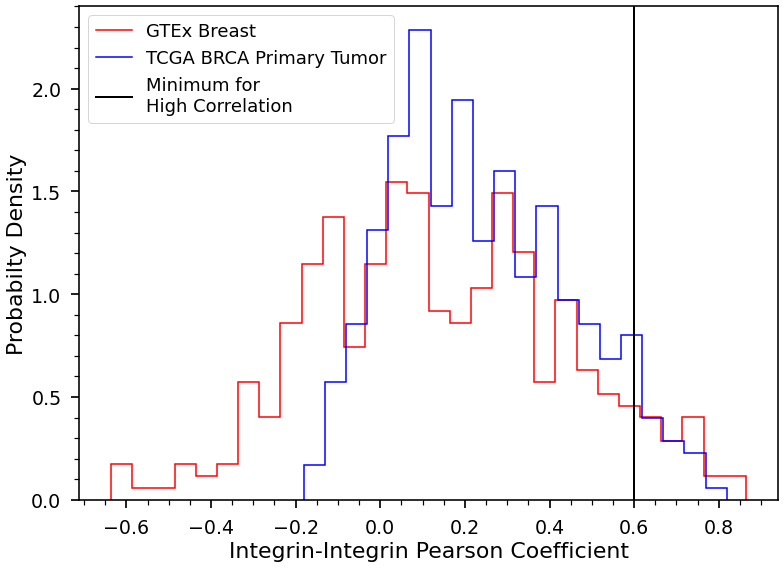

In [99]:
dataset_handles=[]
hist_bin=0.05
itg_list= gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]
gtex_col_1 = [pair[0] for pair in combinations(itg_list,2)]
gtex_col_2 = [pair[1] for pair in combinations(itg_list,2)]
gtex_pair_corr_strength = [gtex_pairwise_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(gtex_col_1,gtex_col_2)]
#get mean correlation value
#get pearson coefficient mean value for integrin-integrin
#show how that changes
#report the 0.6 cutoff in terms of how much higher than mean/stdev

gtex_int_df = pd.DataFrame(data=zip(gtex_col_1,
                                  gtex_col_2,
                                  gtex_pair_corr_strength),columns=['integrin1','integrin2','coefficient']).copy()


tcga_primtum_col_1 = [pair[0] for pair in combinations(itg_list,2)]
tcga_primtum_col_2 = [pair[1] for pair in combinations(itg_list,2)]
tcga_primtum_pair_corr_strength = [tcga_primtum_all_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(tcga_primtum_col_1,tcga_primtum_col_2)]


tcga_primtum_int_df = pd.DataFrame(data=zip(tcga_primtum_col_1,
                                  tcga_primtum_col_2,
                                  tcga_primtum_pair_corr_strength),
                                   columns=['integrin1','integrin2','coefficient']).copy()


fig,ax=plt.subplots(figsize=(11,8))
gtex_handle='GTEx Breast'
tcga_primtum_handle='TCGA BRCA Primary Tumor'

ax.hist(gtex_int_df.coefficient.values,
                density=True,color='red',
                histtype='step',linestyle=('solid'),
               bins=np.arange(gtex_int_df.coefficient.min(),
                             gtex_int_df.coefficient.max(),hist_bin),
               linewidth=1.5)

dataset_handles.append(Line2D([0], [0], label=gtex_handle,color='red',linewidth=1.5))             

ax.hist(tcga_primtum_int_df.coefficient.values,
        density=True,color='blue',
                histtype='step',linestyle=('solid'),
               bins=np.arange(tcga_primtum_int_df.coefficient.min(),
                             tcga_primtum_int_df.coefficient.max(),hist_bin),
               linewidth=1.5)


dataset_handles.append(Line2D([0], [0], label=tcga_primtum_handle,color='blue',linewidth=1.5))             

ax.axvline(correlation_cutoff,ymin=0,ymax=1,color='black',linewidth=2)
dataset_handles.append(Line2D([0], [0], label='Minimum for\nHigh Correlation',color='black',linewidth=2))             

ax.set_ylabel('Probabilty Density',fontsize=22)
ax.set_xlabel('Integrin-Integrin Pearson Coefficient',fontsize=22)

ax.legend(handles=dataset_handles,fontsize=18,loc='upper left')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

plt.tight_layout()

del itg_list,gtex_int_df,tcga_primtum_int_df

In [31]:
dataset_handles=[]
gene_list= gtex_pairwise_pearson_corr.columns
gtex_col_1 = [pair[0] for pair in combinations(gene_list,2)]
gtex_col_2 = [pair[1] for pair in combinations(gene_list,2)]
gtex_pair_corr_strength = [gtex_pairwise_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(gtex_col_1,gtex_col_2)]


gtex_gene_df = pd.DataFrame(data=zip(gtex_col_1,
                                  gtex_col_2,
                                  gtex_pair_corr_strength),columns=['gene1','gene2','coefficient']).copy()


tcga_primtum_col_1 = [pair[0] for pair in combinations(gene_list,2)]
tcga_primtum_col_2 = [pair[1] for pair in combinations(gene_list,2)]
tcga_primtum_pair_corr_strength = [tcga_primtum_all_pearson_corr[pairx].loc[pairy] for pairx,pairy in zip(tcga_primtum_col_1,tcga_primtum_col_2)]


tcga_primtum_gene_df = pd.DataFrame(data=zip(tcga_primtum_col_1,
                                  tcga_primtum_col_2,
                                  tcga_primtum_pair_corr_strength),
                                   columns=['gene1','gene2','coefficient']).copy()


fig,ax=plt.subplots(figsize=(10,8))
gtex_handle='GTEx Breast'
tcga_primtum_handle='TCGA BRCA Primary Tumor'

ax.hist(gtex_gene_df.coefficient.values,
                density=True,color='red',
                histtype='step',linestyle=('solid'),
               bins=np.arange(gtex_gene_df.coefficient.min(),
                             gtex_gene_df.coefficient.max(),0.05),
               linewidth=2)

dataset_handles.append(Line2D([0], [0], label=gtex_handle,color='red',linewidth=2))             

ax.hist(tcga_primtum_gene_df.coefficient.values,
        density=True,color='blue',
                histtype='step',linestyle=('solid'),
               bins=np.arange(tcga_primtum_gene_df.coefficient.min(),
                             tcga_primtum_gene_df.coefficient.max(),0.05),
               linewidth=2)
dataset_handles.append(Line2D([0], [0], label=tcga_primtum_handle,color='blue',linewidth=2))             

ax.set_ylabel('Probabilty Density',fontsize=22)
ax.set_xlabel('gene-gene Pearson Coefficient',fontsize=22)
ax.legend(handles=dataset_handles,fontsize=18,loc='upper left')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=19, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

plt.tight_layout()

#del gene_list,gtex_gene_df,tcga_primtum_gene_df

KeyboardInterrupt: 

(array([[ 0.,  4.,  6., 10.,  4.,  2.,  0.,  0.,  0.,  1.],
        [ 2.,  3.,  9.,  6.,  1.,  4.,  1.,  0.,  0.,  1.],
        [ 0.,  1.,  6.,  5.,  8.,  2.,  2.,  2.,  0.,  1.],
        [ 1.,  7.,  4., 10.,  3.,  1.,  0.,  0.,  0.,  1.],
        [ 1.,  4.,  0.,  9.,  4.,  4.,  3.,  0.,  1.,  1.],
        [ 1., 17.,  7.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  3.,  5.,  3.,  7.,  3.,  4.,  0.,  0.,  1.],
        [ 1.,  2.,  2.,  4.,  5.,  5.,  4.,  3.,  0.,  1.],
        [ 0.,  3., 13.,  7.,  2.,  1.,  0.,  0.,  0.,  1.],
        [ 2.,  5.,  8.,  5.,  5.,  1.,  0.,  0.,  0.,  1.],
        [ 0.,  2.,  8.,  4.,  5.,  1.,  4.,  1.,  1.,  1.],
        [ 1.,  3.,  2.,  3.,  4.,  5.,  4.,  3.,  1.,  1.],
        [ 1.,  4.,  5.,  8.,  6.,  2.,  0.,  0.,  0.,  1.],
        [ 2., 10.,  8.,  0.,  1.,  2.,  2.,  1.,  0.,  1.],
        [ 0.,  2.,  4.,  6.,  5.,  4.,  5.,  0.,  0.,  1.],
        [ 4.,  7., 10.,  3.,  2.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  4.,  9.,  6.,  1.,  2.,  

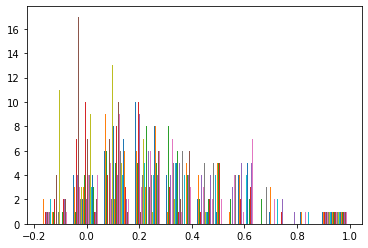

In [28]:
example_df_brca = tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]].loc[tcga_primtum_all_pearson_corr.index.str.contains('ITG')].copy()

plt.hist(example_df_brca.values)


In [18]:
gtex_int_cols=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]]
gtex_int_cols=gtex_int_cols.loc[gtex_int_cols.index.str.contains('ITG')]
gtex_pair_list=[]
j=0
for a in gtex_int_cols.columns:
    if j==0:
        interaction_list=gtex_int_cols[a][gtex_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=gtex_int_cols[a].loc[b]
                gtex_pair_list.append([a,b])
    elif j>0:
        interaction_list=gtex_int_cols[a][gtex_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in gtex_pair_list and [b,a] not in gtex_pair_list:
                    interaction=gtex_int_cols[a].loc[b]
                    gtex_pair_list.append([a,b])
    j+=1

gtex_pair_list


[['ITGA10', 'ITGB4'],
 ['ITGAM', 'ITGB2'],
 ['ITGA3', 'ITGA2'],
 ['ITGA3', 'ITGB8'],
 ['ITGA3', 'ITGB6'],
 ['ITGA3', 'ITGB4'],
 ['ITGA3', 'ITGA4'],
 ['ITGA2', 'ITGB8'],
 ['ITGA2', 'ITGB6'],
 ['ITGA2', 'ITGB7'],
 ['ITGA2', 'ITGB4'],
 ['ITGA2', 'ITGA4'],
 ['ITGA2', 'ITGA11'],
 ['ITGB3', 'ITGA5'],
 ['ITGB8', 'ITGB6'],
 ['ITGB8', 'ITGB4'],
 ['ITGB8', 'ITGA4'],
 ['ITGB8', 'ITGA11'],
 ['ITGAV', 'ITGB1'],
 ['ITGAV', 'ITGA1'],
 ['ITGB6', 'ITGB4'],
 ['ITGB6', 'ITGA4'],
 ['ITGB7', 'ITGAL'],
 ['ITGB7', 'ITGA4'],
 ['ITGB1', 'ITGA1'],
 ['ITGAL', 'ITGA4'],
 ['ITGA4', 'ITGA11']]

In [19]:

tcga_primtum_int_cols=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]]
tcga_primtum_int_cols=tcga_primtum_int_cols.loc[tcga_primtum_int_cols.index.str.contains('ITG')]
tcga_primtum_pair_list=[]
j=0
for a in tcga_primtum_int_cols.columns:
    if j==0:
        interaction_list=tcga_primtum_int_cols[a][tcga_primtum_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=tcga_primtum_int_cols[a].loc[b]
                tcga_primtum_pair_list.append([a,b])
    elif j>0:
        interaction_list=tcga_primtum_int_cols[a][tcga_primtum_int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in tcga_primtum_pair_list and [b,a] not in tcga_primtum_pair_list:
                    interaction=tcga_primtum_int_cols[a].loc[b]
                    tcga_primtum_pair_list.append([a,b])
    j+=1   
tcga_primtum_pair_list

[['ITGAM', 'ITGAX'],
 ['ITGAM', 'ITGB2'],
 ['ITGBL1', 'ITGA11'],
 ['ITGA2', 'ITGAV'],
 ['ITGB3', 'ITGAV'],
 ['ITGB3', 'ITGB1'],
 ['ITGB3', 'ITGA1'],
 ['ITGAX', 'ITGB2'],
 ['ITGAX', 'ITGAL'],
 ['ITGAV', 'ITGB1'],
 ['ITGAV', 'ITGA4'],
 ['ITGAV', 'ITGA1'],
 ['ITGAV', 'ITGA11'],
 ['ITGB7', 'ITGB2'],
 ['ITGA5', 'ITGA1'],
 ['ITGA5', 'ITGA11'],
 ['ITGB1', 'ITGA4'],
 ['ITGB1', 'ITGA1'],
 ['ITGB1', 'ITGA11'],
 ['ITGA8', 'ITGA1'],
 ['ITGA4', 'ITGA1'],
 ['ITGA1', 'ITGA11']]

In [20]:
#gtex integrin-integrin network df (other correlation strength tracks what happens to pair in other dataset)
gtex_int_int_network_df = pd.DataFrame(data=gtex_pair_list,columns=['node1','node2']).copy()
gtex_int_int_network_df['gtex_correlation_strength'] = [gtex_pairwise_pearson_corr[pair[0]].loc[pair[1]] for pair in gtex_pair_list]
gtex_int_int_network_df['other_correlation_strength'] = [tcga_primtum_all_pearson_corr[pair[0]].loc[pair[1]] for pair in gtex_pair_list]
#TCGA primary tumor integrin-integrin network df
tcga_primtum_intint_network_df = pd.DataFrame(data=tcga_primtum_pair_list,columns=['node1','node2']).copy()
tcga_primtum_intint_network_df['tcga_correlation_strength'] = [tcga_primtum_all_pearson_corr[pair[0]].loc[pair[1]] for pair in tcga_primtum_pair_list]
tcga_primtum_intint_network_df['other_correlation_strength'] = [gtex_pairwise_pearson_corr[pair[0]].loc[pair[1]] for pair in tcga_primtum_pair_list]

#networkx network of these above two (other correlation strength tracks what happens to pair in other dataset)
G_int_int_gtex = nx.from_pandas_edgelist(gtex_int_int_network_df,'node1','node2')
G_int_int_tcga_primtum = nx.from_pandas_edgelist(tcga_primtum_intint_network_df,'node1','node2')

list1 = G_int_int_gtex.nodes()
list2 = G_int_int_tcga_primtum.nodes()
intersecting_nodes = set(list1).intersection(list2)
intersection = len(list(set(list1).intersection(list2)))
union = (len(list1) + len(list2)) - intersection
Jaccard_similarity_gtex_tcga_primtum_int_int =  float(intersection) / union
print('The Jaccard index is,',Jaccard_similarity_gtex_tcga_primtum_int_int,sep=' ')

g_common=graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for early_node in intersecting_nodes:
    g_common.node(early_node)
    

The Jaccard index is, 0.6


In [147]:
#save to excel files

#gtex_int_int_network_df.sort_values(by='gtex_correlation_strength').to_excel('gtex_int_int_network_df.xlsx')
#tcga_primtum_intint_network_df.sort_values(by='tcga_correlation_strength').to_excel('tcga_primtum_intint_network_df.xlsx')




In [162]:
for pair in gtex_pair_list:
    if gene_map[gene_map.gene==pair[0]].chrom.values == gene_map[gene_map.gene==pair[1]].chrom.values:
        print(pair[0],pair[1],sep='\t')
gene_map[gene_map.gene=='ITGA4']

ITGA3	ITGB4
ITGB6	ITGA4


,id,gene,chrom,chromStart,chromEnd,strand,id_neutral
8464,ENSG00000115232.13,ITGA4,chr2,181457202,181536187,+,ENSG00000115232


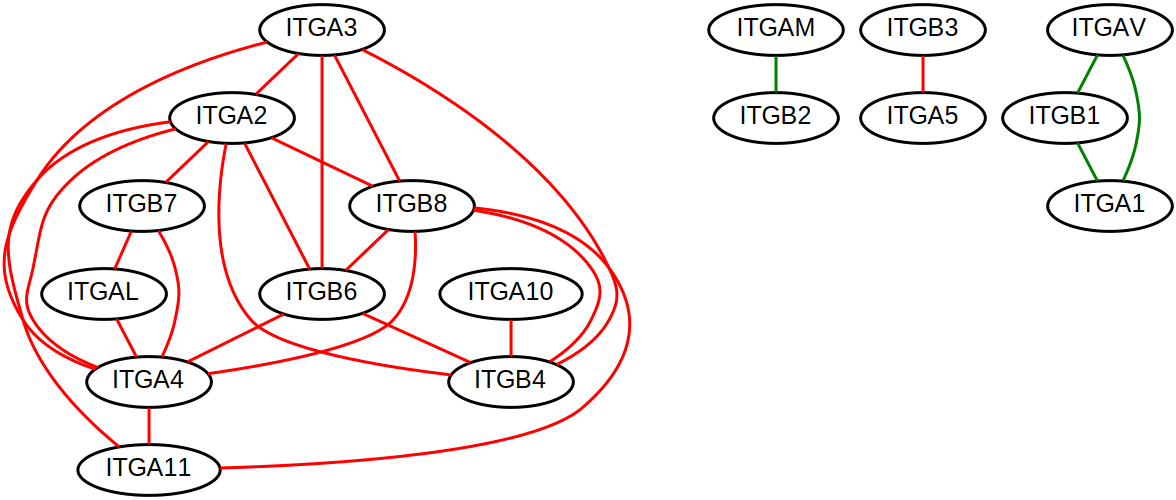

In [131]:
g_gtex = graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for a,b in gtex_pair_list:
    g_gtex.node(a,)
    g_gtex.node(b)
    if [a,b] in tcga_primtum_pair_list or [b,a] in tcga_primtum_pair_list:
        g_gtex.edge(a,b,color='green')
    elif [a,b] not in tcga_primtum_pair_list and [b,a] not in tcga_primtum_pair_list:
        g_gtex.edge(a,b,color='red')

g_gtex.render(filename='gtex_int_int_network',directory='./',view = False, format='png')
g_gtex     


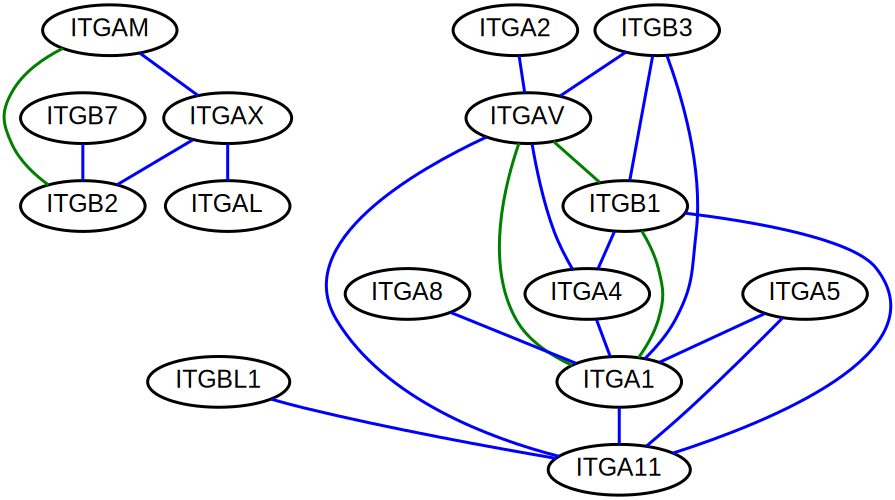

In [132]:
g_tcga_primtum = graphviz.Graph(format='png',
                        node_attr={'fontname':'Arial','fontsize':'25','penwidth':'3'},
                       edge_attr={'penwidth':'3'})
for a,b in tcga_primtum_pair_list:
    g_tcga_primtum.node(a)
    g_tcga_primtum.node(b)
    if [a,b] in gtex_pair_list or [b,a] in gtex_pair_list:
        g_tcga_primtum.edge(a,b,color='green')
    elif [a,b] not in gtex_pair_list and [b,a] not in gtex_pair_list:
        g_tcga_primtum.edge(a,b,color='blue')
g_tcga_primtum.render(filename='tcga_primtum_int_int_network',directory='./',view = False, format='png')        
g_tcga_primtum


In [164]:
#get average integrin-integrin correlation in either tcga primary tumor or gtex breast
corr_list=[]
corr_values=[]
itg_list=tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]

for itg in list(itertools.combinations(itg_list,2)):
    corr_values.append(tcga_primtum_all_pearson_corr[itg[0]].loc[itg[1]])

sum(corr_values)/len(corr_values)    

0.2425151378108265

# integrin other gene (section created nov 2023, due to new using TOIL)

In [32]:
itg_list = df_int[df_int.columns[df_int.columns.str.contains('ITG')]].columns.values
itg_list

array(['ITGA10', 'ITGAD', 'ITGAM', 'ITGA3', 'ITGBL1', 'ITGAE', 'ITGA2',
       'ITGB3', 'ITGA7', 'ITGB8', 'ITGAX', 'ITGAV', 'ITGB6', 'ITGB7',
       'ITGA5', 'ITGB4', 'ITGB2', 'ITGA6', 'ITGA2B', 'ITGB1', 'ITGAL',
       'ITGA9', 'ITGB5', 'ITGA8', 'ITGA4', 'ITGA1', 'ITGA11'],
      dtype=object)

In [33]:
highly_corr_gtex.index.intersection(also_tcga_normal.index).intersection(also_tcga_primtum.index).shape

NameError: name 'highly_corr_gtex' is not defined

In [26]:
#this is for genes highly correlated w integrins in GTEx - tracking those highly correlated genes across datasets
#BE careful with edit and replace - check entire cell when changing
print('integrin','highly_correlated_gtex','also_high_TCGA_normal','also_high_TCGA_primtum',
      'high_corr_all_3',sep='\t')
integrins=[]
gtex_highly_correlated=[]
tcga_normal_highly_correlated=[]
tcga_primtum_highly_correlated=[]
highly_correlated_all_3=[]

for itg in itg_list:
    highly_corr_gtex=correlation_selected_gene(df_int,itg,'pearson')
    highly_corr_gtex=highly_corr_gtex[highly_corr_gtex>=correlation_cutoff]
    
    corr_tcga_normal = correlation_selected_gene(tcga_brca_df_normal_all[highly_corr_gtex.index.append(pd.Index([itg]))],
                                                 itg,'pearson')
    also_tcga_normal = corr_tcga_normal[corr_tcga_normal>=correlation_cutoff]

    corr_tcga_primtum = correlation_selected_gene(tcga_brca_df_primtum_all[highly_corr_gtex.index.append(pd.Index([itg]))],
                                                  itg,'pearson')
    also_tcga_primtum = corr_tcga_primtum[corr_tcga_primtum>=correlation_cutoff]
    
    high_corr_all_3 = highly_corr_gtex.index.intersection(also_tcga_normal.index).intersection(also_tcga_primtum.index)
    
    integrins.append(itg)
    gtex_highly_correlated.append(highly_corr_gtex.shape[0])
    tcga_normal_highly_correlated.append(also_tcga_normal.shape[0])
    tcga_primtum_highly_correlated.append(also_tcga_primtum.shape[0])   
    highly_correlated_all_3.append(high_corr_all_3.shape[0])
    print(itg, highly_corr_gtex.shape[0], also_tcga_normal.shape[0], also_tcga_primtum.shape[0],
          high_corr_all_3.shape[0],
          sep='\t')
    
gtex_corr_lost_df=pd.DataFrame(data=list(zip(integrins,
                                             gtex_highly_correlated,
                                             tcga_normal_highly_correlated,
                           tcga_primtum_highly_correlated,
                                           highly_correlated_all_3)),
             columns=['integrin',
                      'gtex_highly_correlated',
                      'also_high_TCGA_normal',
                      'also_high_TCGA_primtum',
                     'high_corr_all_3']).sort_values(by='also_high_TCGA_primtum')
del gtex_highly_correlated, tcga_normal_highly_correlated, tcga_primtum_highly_correlated, highly_correlated_all_3
gtex_corr_lost_df    
    
    

integrin	highly_correlated_gtex	also_high_TCGA_normal	also_high_TCGA_primtum	high_corr_all_3
ITGA10	410	370	0	0
ITGAD	0	0	0	0
ITGAM	80	78	44	44
ITGA3	3264	2210	1	1
ITGBL1	26	0	10	0
ITGAE	23	2	0	0
ITGA2	4438	3617	24	18
ITGB3	24	17	1	1
ITGA7	582	477	42	40
ITGB8	3212	2699	0	0
ITGAX	34	11	13	8
ITGAV	510	451	290	273
ITGB6	2385	1660	0	0
ITGB7	1208	118	63	56
ITGA5	132	80	15	12
ITGB4	2679	1958	0	0
ITGB2	82	75	73	69
ITGA6	272	251	0	0
ITGA2B	75	0	0	0
ITGB1	243	172	86	71
ITGAL	484	171	68	66
ITGA9	5	5	1	1
ITGB5	49	15	1	0
ITGA8	43	11	6	4
ITGA4	2767	1421	120	116
ITGA1	366	222	113	93
ITGA11	1154	10	36	3


,integrin,gtex_highly_correlated,also_high_TCGA_normal,also_high_TCGA_primtum,high_corr_all_3
0,ITGA10,410,370,0,0
18,ITGA2B,75,0,0,0
12,ITGB6,2385,1660,0,0
9,ITGB8,3212,2699,0,0
15,ITGB4,2679,1958,0,0
17,ITGA6,272,251,0,0
1,ITGAD,0,0,0,0
5,ITGAE,23,2,0,0
7,ITGB3,24,17,1,1
3,ITGA3,3264,2210,1,1


In [27]:
#save to excel file
gtex_corr_lost_df.to_excel('GTEx_highly_corr_all_genes.xlsx')

In [94]:
#this is for genes highly correlated w integrins in TCGA BRCA primary tumor,
#tracking those highly correlated genes - what were those correlations in GTEx and TCGA normal

#BE careful with edit and replace - check entire cell when changing

print('integrin','highly_correlated_TCGA_primtum','also_high_TCGA_normal','also_high_GTEx',
      'high_corr_all_3',sep='\t')
integrins=[]
BRCA_high_corr_genes=[]
also_BRCA_normal=[]
also_breast_GTEx=[]
highly_correlated_all_3=[]

for itg in itg_list:
    highly_corr_BRCA=correlation_selected_gene(tcga_brca_df_primtum_all,itg,'pearson')
    highly_corr_BRCA=highly_corr_BRCA[highly_corr_BRCA>=correlation_cutoff]
    
    corr_tcga_normal = correlation_selected_gene(tcga_brca_df_normal_all[highly_corr_BRCA.index.append(pd.Index([itg]))],
                                                 itg,'pearson')
    also_tcga_normal = corr_tcga_normal[corr_tcga_normal>=correlation_cutoff]

    corr_gtex_normal = correlation_selected_gene(df_int[highly_corr_BRCA.index.append(pd.Index([itg]))],
                                                  itg,'pearson')
    also_gtex_normal = corr_gtex_normal[corr_gtex_normal>=correlation_cutoff]
    high_corr_all_3 = highly_corr_BRCA.index.intersection(also_tcga_normal.index).intersection(also_gtex_normal.index)
    
    integrins.append(itg)
    BRCA_high_corr_genes.append(highly_corr_BRCA.shape[0])
    also_BRCA_normal.append(also_tcga_normal.shape[0])
    also_breast_GTEx.append(also_gtex_normal.shape[0])   
    highly_correlated_all_3.append(high_corr_all_3.shape[0])
    print(itg, highly_corr_BRCA.shape[0], also_tcga_normal.shape[0], also_gtex_normal.shape[0],
          high_corr_all_3.shape[0],sep='\t')
    
tcga_primtum_gained_df=pd.DataFrame(data=list(zip(integrins,
                                             BRCA_high_corr_genes,
                                             also_BRCA_normal,
                           also_breast_GTEx,
                                                 highly_correlated_all_3)),
             columns=['integrin',
                      'BRCA_high_corr_genes',
                      'also_high_TCGA_normal',
                      'also_high_GTEx',
                     'high_corr_all_3']).sort_values(by='BRCA_high_corr_genes')
del integrins, BRCA_high_corr_genes, also_BRCA_normal, also_breast_GTEx, highly_correlated_all_3
tcga_primtum_gained_df    
    
    

integrin	highly_correlated_TCGA_primtum	also_high_TCGA_normal	also_high_GTEx	high_corr_all_3
ITGA10	0	0	0	0
ITGAD	6	0	0	0
ITGAM	144	102	44	44
ITGA3	1	1	1	1
ITGBL1	267	0	10	0
ITGAE	0	0	0	0
ITGA2	73	29	24	18
ITGB3	147	82	1	1
ITGA7	79	62	42	40
ITGB8	0	0	0	0
ITGAX	311	177	13	8
ITGAV	1201	1004	290	273
ITGB6	0	0	0	0
ITGB7	276	153	63	56
ITGA5	202	97	15	12
ITGB4	0	0	0	0
ITGB2	394	220	73	69
ITGA6	1	1	0	0
ITGA2B	0	0	0	0
ITGB1	939	282	86	71
ITGAL	208	147	68	66
ITGA9	8	5	1	1
ITGB5	20	3	1	0
ITGA8	138	14	6	4
ITGA4	559	313	120	116
ITGA1	425	213	113	93
ITGA11	265	6	36	3


,integrin,BRCA_high_corr_genes,also_high_TCGA_normal,also_high_GTEx,high_corr_all_3
0,ITGA10,0,0,0,0
15,ITGB4,0,0,0,0
12,ITGB6,0,0,0,0
9,ITGB8,0,0,0,0
18,ITGA2B,0,0,0,0
5,ITGAE,0,0,0,0
17,ITGA6,1,1,0,0
3,ITGA3,1,1,1,1
1,ITGAD,6,0,0,0
21,ITGA9,8,5,1,1


In [95]:
#save to excel file

tcga_primtum_gained_df.to_excel('BRCA_highly_corr_all_genes.xlsx')



In [40]:
#correlation_selected_gene(tcga_brca_df_primtum_all,itg,'pearson')
tcga_brca_df_primtum_all.T.index

Index(['RAB4B', 'TIGAR', 'RNF44', 'DNAH3', 'RPL23A', 'ARL8B', 'CALB2', 'DACH1',
       'FMO2', 'ZNF708',
       ...
       'ARHGAP21', 'DDX47', 'POMZP3', 'EIF5B', 'KIF16B', 'CYP4F2', 'TENM1',
       'BATF3', 'PPP6R1', 'OR8D4'],
      dtype='object', name='gene', length=19155)

/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


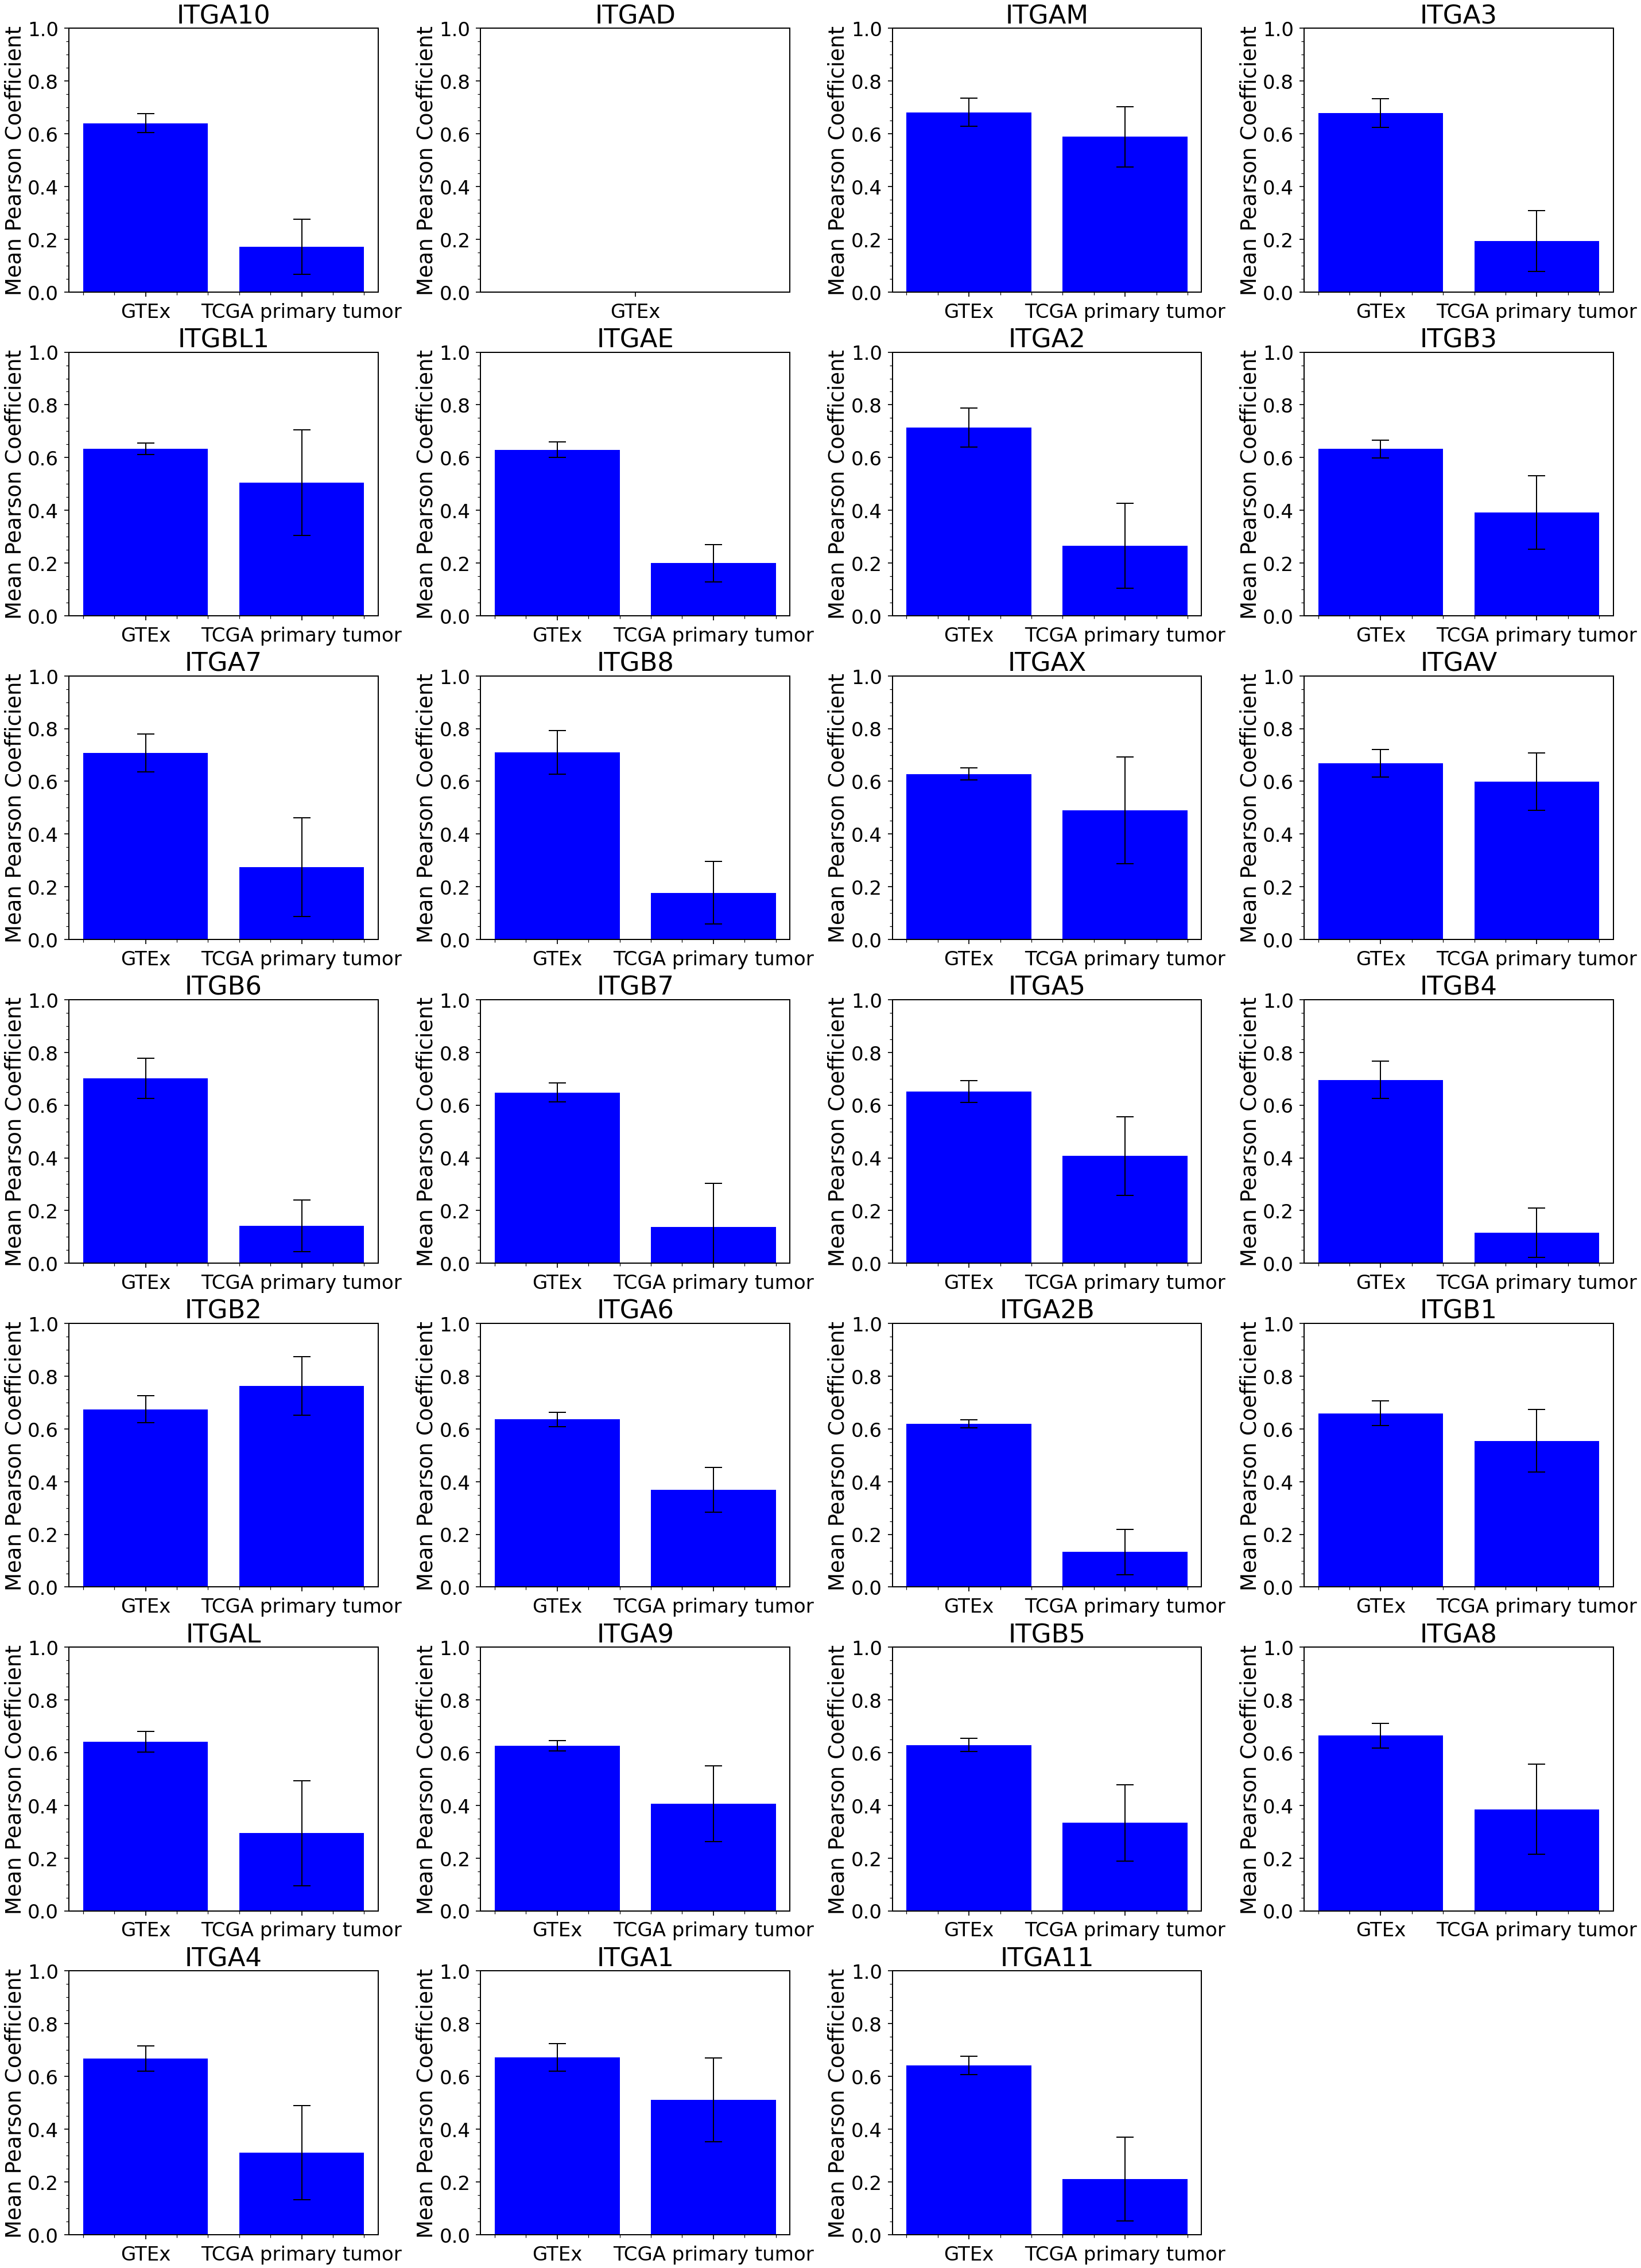

In [109]:
#comehere
#ITGAD no high correlation in GTEx

#selected_integrin='ITGA2'
fig,axs=plt.subplots(nrows=7,ncols=4,figsize=(40,55))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
for selected_integrin,ax in zip(itg_list,axs.ravel()):
    highly_corr_gtex=correlation_selected_gene(df_int,selected_integrin,'pearson')
    highly_corr_gtex=highly_corr_gtex[highly_corr_gtex>=correlation_cutoff]
    
    mean_t=highly_corr_gtex.mean()

    std_t=highly_corr_gtex.std()

    #common_genes= highly_corr_gtex.index.intersection(tcga_brca_df_primtum_all.T.index.index)
    #applying absolute values here since there are negative correlation coefficients
    #common_genes not really needed
    common_corr_tcgaprim = correlation_selected_gene(tcga_brca_df_primtum_all[highly_corr_gtex.index.append(pd.Index([selected_integrin]))],
                                                     selected_integrin,'pearson')
    mean_p=common_corr_tcgaprim.abs().mean()
    std_p=common_corr_tcgaprim.abs().std()
    ax.bar('GTEx',height=mean_t,yerr=std_t,color='blue',error_kw=dict(elinewidth=2,capsize=15,capthick=2))


    ax.bar('TCGA primary tumor',height=mean_p,yerr=std_p,color='blue',error_kw=dict(elinewidth=2,
                                                                                    capsize=15,capthick=2))
    ax.set_title(f'{selected_integrin}',fontsize=45)
    ax.set_ylim(0,1)
    plt.setp(ax.get_xticklabels(),fontsize=34)
#    ax.xticks(fontsize=18)
    plt.setp(ax.get_yticklabels(),fontsize=34)
#    ax.set_yticks(fontsize=16)
    ax.set_ylabel('Mean Pearson Coefficient',fontsize=37)
    
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(2)
        
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=34, width = 1.7, size = 8,pad=10)
    ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


fig.tight_layout()
axs.ravel()[-1].remove()

#plt.savefig(f'figures/mean_coefficient_gtex_corr_high_all_integrins.png', dpi = 1000, bbox_inches='tight')



/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/hshadman/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/hshadman/.local/

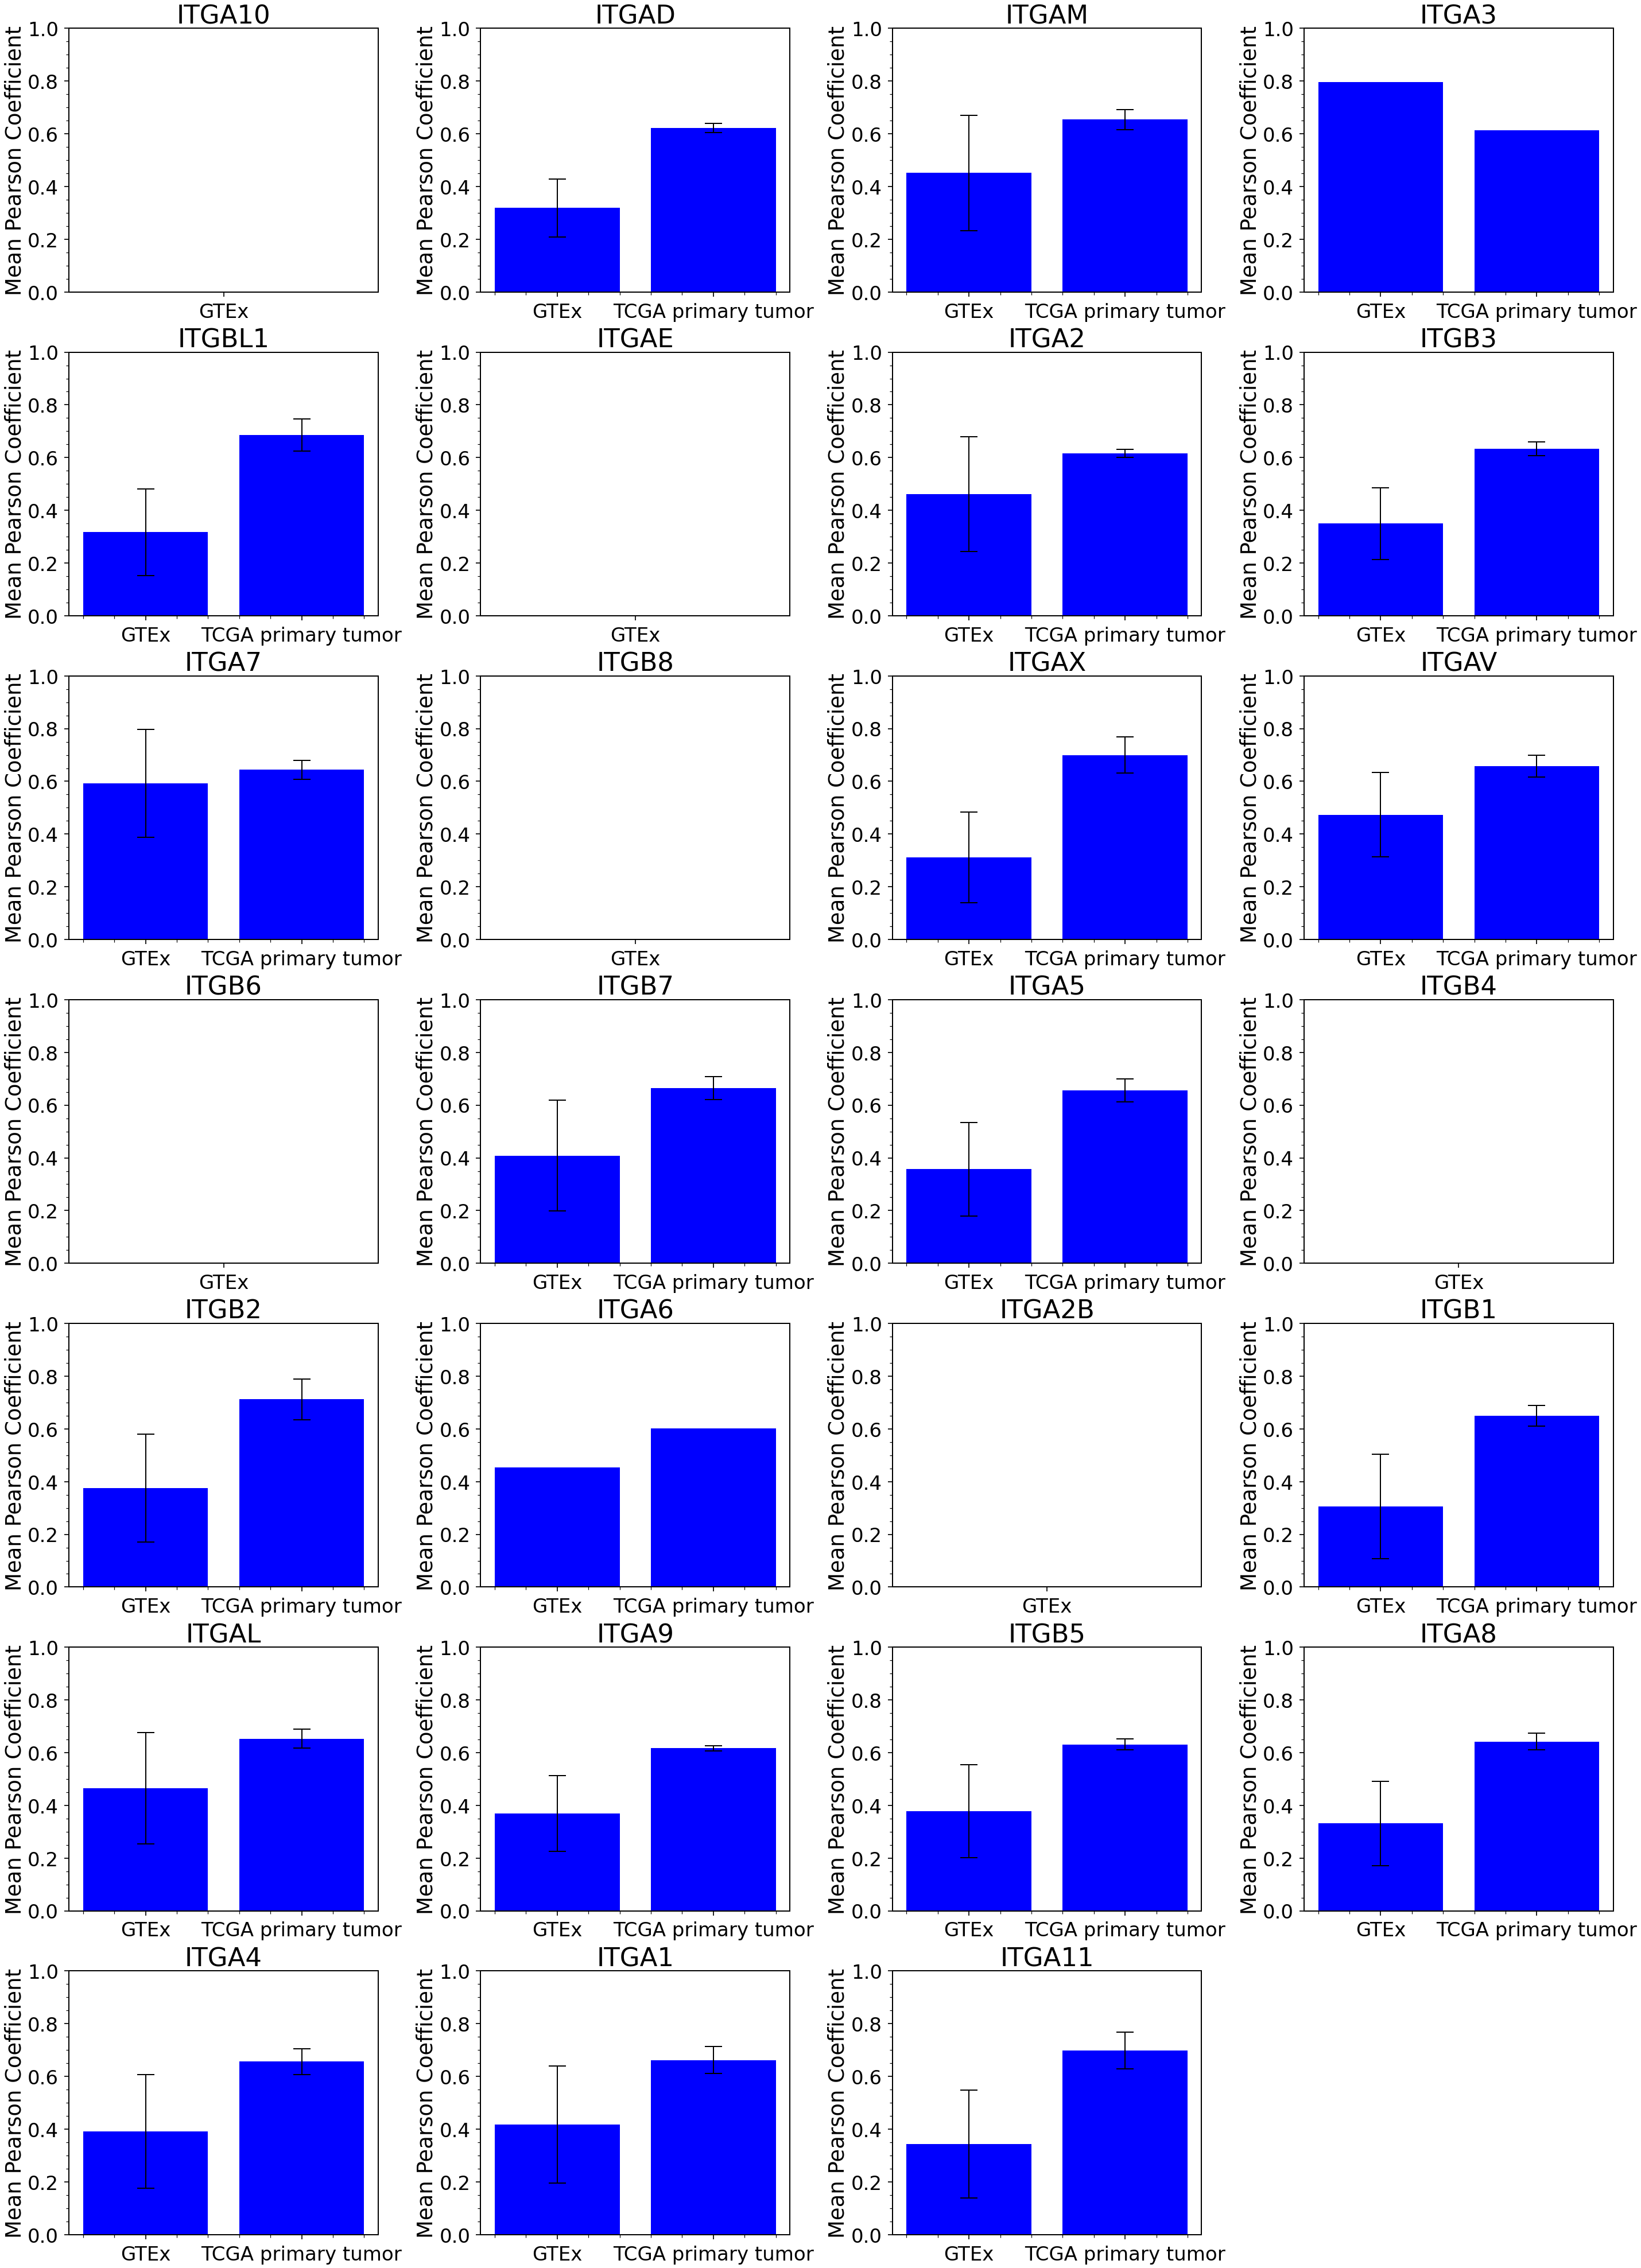

In [24]:
#comehere


#selected_integrin='ITGA2'
fig,axs=plt.subplots(nrows=7,ncols=4,figsize=(40,55))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
for selected_integrin,ax in zip(itg_list,axs.ravel()):
    highly_corr_tcgaprimtum=correlation_selected_gene(tcga_brca_df_primtum_all,selected_integrin,'pearson')
    highly_corr_tcgaprimtum=highly_corr_tcgaprimtum[highly_corr_tcgaprimtum>=correlation_cutoff]
    
    mean_t=highly_corr_tcgaprimtum.mean()

    std_t=highly_corr_tcgaprimtum.std()

    #common_genes= highly_corr_tcgaprimtum.index.intersection(df_int.index)
    #applying absolute values here since there are negative correlation coefficients
    #common_genes not really needed
    common_corr_gtex = correlation_selected_gene(df_int[highly_corr_tcgaprimtum.index.append(pd.Index([selected_integrin]))],
                                                     selected_integrin,'pearson')
    mean_p=common_corr_gtex.abs().mean()
    std_p=common_corr_gtex.abs().std()
    ax.bar('GTEx',
           height=mean_p,yerr=std_p,color='blue',error_kw=dict(elinewidth=2,capsize=15,capthick=2))    
    ax.bar('TCGA primary tumor',
           height=mean_t,yerr=std_t,color='blue',error_kw=dict(elinewidth=2,capsize=15,capthick=2))    



    ax.set_title(f'{selected_integrin}',fontsize=45)
    ax.set_ylim(0,1)
    plt.setp(ax.get_xticklabels(),fontsize=34)
#    ax.xticks(fontsize=18)
    plt.setp(ax.get_yticklabels(),fontsize=34)
#    ax.set_yticks(fontsize=16)
    ax.set_ylabel('Mean Pearson Coefficient',fontsize=37)
    
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(2)
        
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=34, width = 1.7, size = 8,pad=10)
    ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)    
    
fig.tight_layout()
axs.ravel()[-1].remove()
#plt.savefig(f'figures/mean_coefficient_tcgaprim_corr_high_all_integrins.png', dpi = 1000, bbox_inches='tight')


In [20]:
correlation_cutoff

0.6

# some previous stuff (when using HISEQ data)

In [22]:
#checking p-value for integrin-integrin network
for integrin1,integrin2 in gtex_pair_list:
    p_value=pearsonr(df_int[integrin1].values,df_int[integrin2].values)[1]
    if p_value>=0.05:
        print(integrin1,integrin2)
    


In [23]:
#checking p-value for integrin-integrin network
for integrin1,integrin2 in tcga_primtum_pair_list:
    p_value=pearsonr(tcga_brca_df_primtum_all[integrin1].values,tcga_brca_df_primtum_all[integrin2].values)[1]
    if p_value>=0.05:
        print(integrin1,integrin2)


In [24]:

#G=nx.Graph(name='Integrin Interaction Graph')
g = graphviz.Graph()
int_cols=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_gtex_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_gtex_pair.append([a,b])
                g.node(a)
                g.node(b)
                g.edge(a,b)
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_gtex_pair and [b,a] not in temp_gtex_pair:
                    interaction=int_cols[a].loc[b]
                    temp_gtex_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    g.edge(a,b)
            else:
                pass
    j+=1   



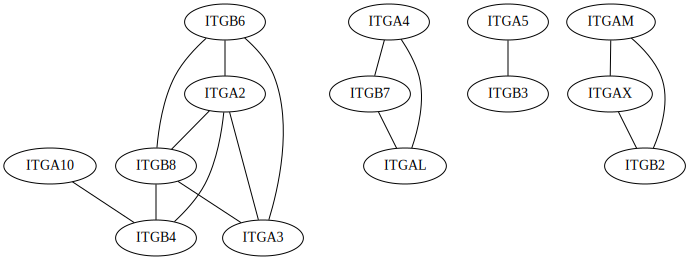

In [20]:
g

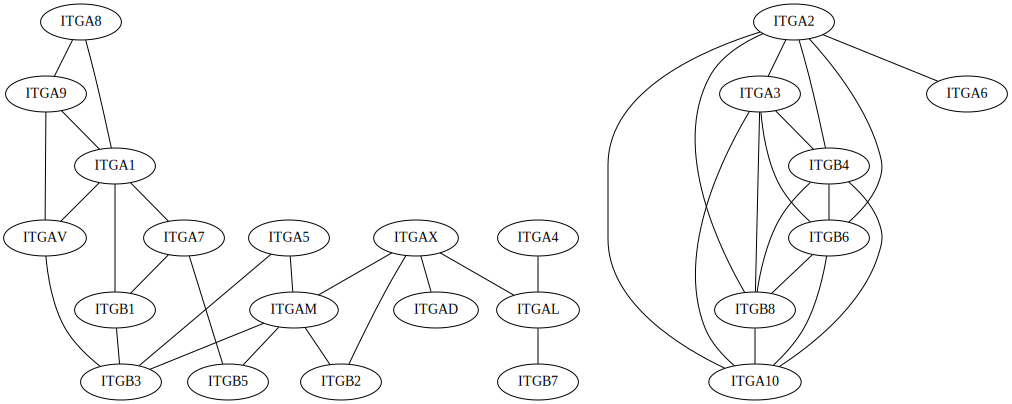

In [20]:
g = graphviz.Graph()
int_cols=tcga_normal_all_pearson_corr[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_tcga_normal_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_tcga_normal_pair.append([a,b])
                g.node(a)
                g.node(b)
                g.edge(a,b)
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_tcga_normal_pair and [b,a] not in temp_tcga_normal_pair:
                    interaction=int_cols[a].loc[b]
                    temp_tcga_normal_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    g.edge(a,b)
            else:
                pass
    j+=1   
g

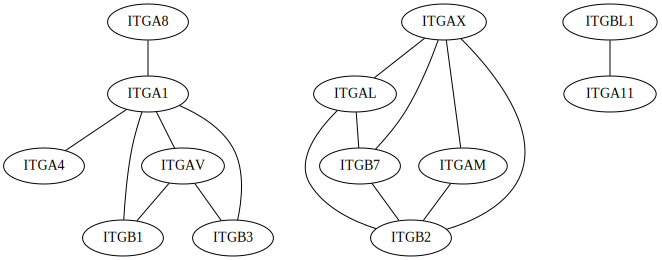

In [21]:
g = graphviz.Graph()
int_cols=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_tcga_primtum_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_tcga_primtum_pair.append([a,b])
                g.node(a)
                g.node(b)
                g.edge(a,b)
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_tcga_primtum_pair and [b,a] not in temp_tcga_primtum_pair:
                    interaction=int_cols[a].loc[b]
                    temp_tcga_primtum_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    g.edge(a,b)
            else:
                pass
    j+=1   
g

# Assign rank to integrin, based on number of genes that are highly correlated with it

In [113]:
correlation_cutoff

0.6

In [116]:
#in the pairwise corr df, some duplicate genes may be present
all_genes_in_dataset=gtex_pairwise_pearson_corr.columns
corr=[]
for all_gene in all_genes_in_dataset:
    correlation_df=gtex_pairwise_pearson_corr[all_gene].copy()        
    corr.append(correlation_df[(correlation_df.index != all_gene) & (correlation_df>=correlation_cutoff)].shape[0])

rank_df_gtex=pd.DataFrame(data=np.column_stack([all_genes_in_dataset,corr]),
             columns=['all_genes','correlations']).copy()
rank_df_gtex['ranks']=rank_df_gtex['correlations'].rank(ascending=False)    
rank_df_gtex['lowest_rank']=np.repeat(rank_df_gtex.ranks.max(),
                                  all_genes_in_dataset.shape[0])

rank_df_gtex['dataset']=np.repeat('GTEx',
                                  all_genes_in_dataset.shape[0])

del all_genes_in_dataset, correlation_df, corr


In [119]:
#save to excel
df = rank_df_gtex[rank_df_gtex.all_genes.str.contains('ITG') ].sort_values(by='ranks').copy()
df.to_excel('GTEx_integrin_rank_list.xlsx')
display(df)
del df

,all_genes,correlations,ranks,lowest_rank,dataset
6697,ITGA2,4438,127.5,17451.5,GTEx
5114,ITGA3,3264,1196.0,17451.5,GTEx
8600,ITGB8,3212,1274.5,17451.5,GTEx
16112,ITGA4,2767,1973.0,17451.5,GTEx
10845,ITGB4,2679,2127.0,17451.5,GTEx
9570,ITGB6,2385,2631.0,17451.5,GTEx
9908,ITGB7,1208,4741.0,17451.5,GTEx
18954,ITGA11,1154,4853.0,17451.5,GTEx
7614,ITGA7,582,6316.5,17451.5,GTEx
9036,ITGAV,510,6617.0,17451.5,GTEx


In [120]:

all_genes_in_dataset=tcga_primtum_all_pearson_corr.columns
corr=[]
for all_gene in all_genes_in_dataset:
    correlation_df=tcga_primtum_all_pearson_corr[all_gene].copy()        
    corr.append(correlation_df[(correlation_df.index != all_gene) & (correlation_df>=correlation_cutoff)].shape[0])

rank_df_tcga_primtum=pd.DataFrame(data=np.column_stack([all_genes_in_dataset,corr]),
             columns=['all_genes','correlations']).copy()
rank_df_tcga_primtum['ranks']=rank_df_tcga_primtum['correlations'].rank(ascending=False)    
rank_df_tcga_primtum['lowest_rank']=np.repeat(rank_df_tcga_primtum.ranks.max(),
                                  all_genes_in_dataset.shape[0])

rank_df_tcga_primtum['dataset']=np.repeat('TCGA_primtum',
                                  all_genes_in_dataset.shape[0])

del all_genes_in_dataset, correlation_df, corr


In [123]:
df = rank_df_tcga_primtum[rank_df_tcga_primtum.all_genes.str.contains('ITG')].sort_values(by='ranks').copy()
df.to_excel('TCGA_BRCA_primtum_integrin_rank_list.xlsx')
display(df)
del df

,all_genes,correlations,ranks,lowest_rank,dataset
9036,ITGAV,1201,1039.0,15557.5,TCGA_primtum
12892,ITGB1,939,1338.5,15557.5,TCGA_primtum
16112,ITGA4,559,1960.5,15557.5,TCGA_primtum
16495,ITGA1,425,2376.0,15557.5,TCGA_primtum
10859,ITGB2,394,2509.5,15557.5,TCGA_primtum
9015,ITGAX,311,2864.0,15557.5,TCGA_primtum
9908,ITGB7,276,3071.0,15557.5,TCGA_primtum
6234,ITGBL1,267,3139.5,15557.5,TCGA_primtum
18954,ITGA11,265,3155.0,15557.5,TCGA_primtum
13558,ITGAL,208,3548.0,15557.5,TCGA_primtum


# detour


In [73]:
print('this is GTEx integrin-integrin coefficients that meet correlation cutoff')

int_complete_list=gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')].tolist()

gtex_integrina=[]
gtex_integrinb=[]
for interest_gene in int_complete_list:
    single_int_corr = gtex_pairwise_pearson_corr[interest_gene]
    single_gene_corr_cutoff = single_int_corr[single_int_corr>=correlation_cutoff]
    single_int_corr_cutoff = single_gene_corr_cutoff.loc[single_gene_corr_cutoff.index.str.contains('ITG')]
    secondary_gene=[gene for gene in single_int_corr_cutoff.index if gene!=interest_gene]
    
    for integrina,integrinb in zip(np.repeat(interest_gene,np.array(secondary_gene).shape[0]),
                                  np.array(secondary_gene)):
        print(integrina,integrinb,gtex_pairwise_pearson_corr[integrina].loc[integrinb],sep='\t')
        gtex_integrina.append(integrina)
        gtex_integrinb.append(integrinb)

print('this is TCGA primary tumor integrin-integrin coefficients for the ABOVE pairs')

for integrina,integrinb in zip(gtex_integrina,gtex_integrinb):
    print(integrina,integrinb,tcga_primtum_all_pearson_corr[integrina].loc[integrinb],sep='\t')
    
del int_complete_list, single_int_corr, single_gene_corr_cutoff, single_int_corr_cutoff, secondary_gene
del gtex_integrina, gtex_integrinb    
    

this is GTEx integrin-integrin coefficients that meet correlation cutoff
ITGA10	ITGB4	0.647916608817845
ITGB6	ITGA2	0.8572809931217005
ITGB6	ITGB8	0.776114237260938
ITGB6	ITGA3	0.6504255899588504
ITGA4	ITGB7	0.642096016529722
ITGA4	ITGAL	0.7684991494680355
ITGA2	ITGB6	0.8572809931217005
ITGA2	ITGB8	0.8096288825397041
ITGA2	ITGA3	0.7394629102204545
ITGA2	ITGB4	0.6489419208405988
ITGB8	ITGB6	0.776114237260938
ITGB8	ITGA2	0.8096288825397042
ITGB8	ITGA3	0.6261651229220958
ITGB8	ITGB4	0.7657976335252512
ITGB7	ITGA4	0.6420960165297219
ITGB7	ITGAL	0.7650946084382299
ITGA5	ITGB3	0.8243095392815389
ITGAL	ITGA4	0.7684991494680355
ITGAL	ITGB7	0.7650946084382299
ITGAM	ITGAX	0.8876518276125602
ITGAM	ITGB2	0.9419239402632323
ITGAX	ITGAM	0.8876518276125602
ITGAX	ITGB2	0.9489773483410892
ITGB3	ITGA5	0.8243095392815388
ITGA3	ITGB6	0.6504255899588504
ITGA3	ITGA2	0.7394629102204545
ITGA3	ITGB8	0.6261651229220958
ITGB4	ITGA10	0.647916608817845
ITGB4	ITGA2	0.6489419208405988
ITGB4	ITGB8	0.7657976335252513


In [74]:
print('this is TCGA primary tumor integrin-integrin coefficients that meet correlation cutoff')

int_complete_list=tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')].tolist()

tcga_primarytumor_integrina=[]
tcga_primarytumor_integrinb=[]
for interest_gene in int_complete_list:
    single_int_corr = tcga_primtum_all_pearson_corr[interest_gene]
    single_gene_corr_cutoff = single_int_corr[single_int_corr>=correlation_cutoff]
    single_int_corr_cutoff = single_gene_corr_cutoff.loc[single_gene_corr_cutoff.index.str.contains('ITG')]
    secondary_gene=[gene for gene in single_int_corr_cutoff.index if gene!=interest_gene]
    
    for integrina,integrinb in zip(np.repeat(interest_gene,np.array(secondary_gene).shape[0]),
                                  np.array(secondary_gene)):
        print(integrina,integrinb,tcga_primtum_all_pearson_corr[integrina].loc[integrinb],sep='\t')
        tcga_primarytumor_integrina.append(integrina)
        tcga_primarytumor_integrinb.append(integrinb)

print('this is GTEx breast integrin-integrin coefficients for the ABOVE pairs')

for integrina,integrinb in zip(tcga_primarytumor_integrina,tcga_primarytumor_integrinb):
    print(integrina,integrinb,gtex_pairwise_pearson_corr[integrina].loc[integrinb],sep='\t')
    
del int_complete_list, single_int_corr, single_gene_corr_cutoff, single_int_corr_cutoff, secondary_gene
del tcga_primarytumor_integrina, tcga_primarytumor_integrinb    



this is TCGA primary tumor integrin-integrin coefficients that meet correlation cutoff
ITGA8	ITGA1	0.6898402432174459
ITGA1	ITGA8	0.6898402432174459
ITGA1	ITGA4	0.6103080713899457
ITGA1	ITGAV	0.6650496156072594
ITGA1	ITGB1	0.6798413186421176
ITGA1	ITGB3	0.6623798761831252
ITGA4	ITGA1	0.6103080713899457
ITGAX	ITGAL	0.6074998518795192
ITGAX	ITGAM	0.7196118133750335
ITGAX	ITGB7	0.6238848532693667
ITGAX	ITGB2	0.8765608010450248
ITGAV	ITGA1	0.6650496156072595
ITGAV	ITGB1	0.6120853543475736
ITGAV	ITGB3	0.6468853261040379
ITGAL	ITGAX	0.6074998518795192
ITGAL	ITGB7	0.6480234644716499
ITGAL	ITGB2	0.6089761734246032
ITGAM	ITGAX	0.7196118133750335
ITGAM	ITGB2	0.7294500477537341
ITGBL1	ITGA11	0.7584049842919723
ITGB1	ITGA1	0.6798413186421176
ITGB1	ITGAV	0.6120853543475736
ITGB3	ITGA1	0.6623798761831253
ITGB3	ITGAV	0.6468853261040379
ITGB7	ITGAX	0.6238848532693667
ITGB7	ITGAL	0.6480234644716499
ITGB7	ITGB2	0.7061163444650633
ITGA11	ITGBL1	0.7584049842919723
ITGB2	ITGAX	0.8765608010450248
ITGB2	ITGA

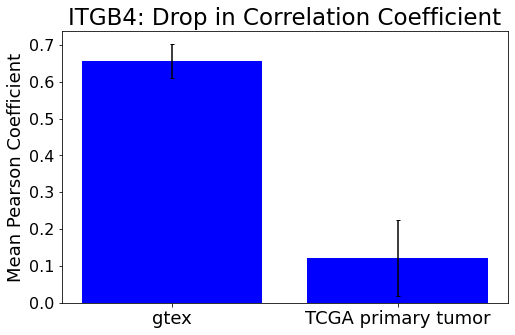

In [34]:
selected_integrin='ITGB4'
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].std()

common_genes= gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr.index)
#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_integrin}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)

plt.savefig(f'figures/mcbios_talk_figure_{selected_integrin}_dropping_gtexcorr.jpg', dpi = 1000, bbox_inches='tight')



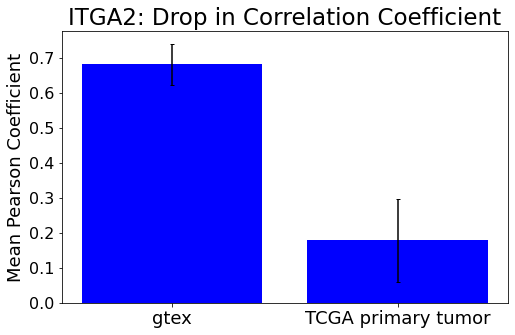

In [35]:
selected_integrin='ITGA2'
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].std()

common_genes= gtex_pairwise_pearson_corr[selected_integrin][gtex_pairwise_pearson_corr[selected_integrin]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr.index)
#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_integrin].loc[common_genes].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_integrin}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)

plt.savefig(f'figures/mcbios_talk_figure_{selected_integrin}_dropping_gtexcorr.jpg', dpi = 1000, bbox_inches='tight')



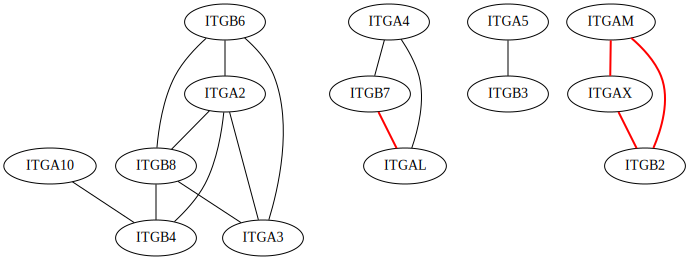

In [71]:
# need to run the above three cells again, so i can highlight the common connections/edges
#this is gtex, changing temp_gtex_common_pair variable
#G=nx.Graph(name='Integrin Interaction Graph')
g = graphviz.Graph()
int_cols=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_gtex_common_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_gtex_common_pair.append([a,b])
                g.node(a)
                g.node(b)
                if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                    g.edge(a,b,color='red',penwidth='2')
                else:
                    g.edge(a,b)
                    
                    
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_gtex_common_pair and [b,a] not in temp_gtex_common_pair:
                    interaction=int_cols[a].loc[b]
                    temp_gtex_common_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                        g.edge(a,b,color='red',penwidth='2')
                    else:
                        g.edge(a,b)
                else:
                    pass
    j+=1   
g


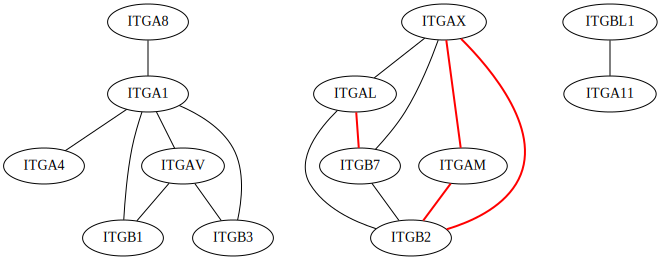

In [72]:
# need to run the above three cells again, so i can highlight the common connections/edges
#this is gtex, changing temp_tcga_primtum_common_pair variable
#G=nx.Graph(name='Integrin Interaction Graph')
g = graphviz.Graph()
int_cols=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains('ITG')]]
int_cols=int_cols.loc[int_cols.index.str.contains('ITG')]
temp_tcga_primtum_common_pair=[]
j=0
for a in int_cols.columns:
    if j==0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                interaction=int_cols[a].loc[b]
                temp_tcga_primtum_common_pair.append([a,b])
                g.node(a)
                g.node(b)
                if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                    g.edge(a,b,color='red',penwidth='2')
                else:
                    g.edge(a,b)
                    
                    
    if j>0:
        interaction_list=int_cols[a][int_cols[a]>=correlation_cutoff]
        if interaction_list.shape[0]>1:
            b_list=interaction_list.loc[interaction_list.index!=a].index
            for b in b_list:
                if [a,b] not in temp_tcga_primtum_common_pair and [b,a] not in temp_tcga_primtum_common_pair:
                    interaction=int_cols[a].loc[b]
                    temp_tcga_primtum_common_pair.append([a,b])
                    g.node(a)
                    g.node(b)
                    if ([a,b] in temp_gtex_pair or [b,a] in temp_gtex_pair) and ([a,b] in temp_tcga_primtum_pair or [b,a] in temp_tcga_primtum_pair):
                        g.edge(a,b,color='red',penwidth='2')
                    else:
                        g.edge(a,b)
                else:
                    pass
    j+=1   
g


In [18]:
chosen_genes=['ITGB7','ITGAL']
for gene in chosen_genes:
    print(gtex_pairwise_pearson_corr['ITGB2'].loc[gene])

0.14392408422088235
0.37422625135878795


In [19]:
chosen_genes=['ITGB7','ITGAL']
for gene in chosen_genes:
    print(tcga_primtum_all_pearson_corr['ITGB2'].loc[gene])

0.7061163444650632
0.6089761734246031


# continue as normal (checking gene lists for function)

In [50]:
tcga_primtum_all_pearson_corr['ITGBL1'].to_csv('tcga_primtum_all_pearson_corr_ITGBL1.csv')

In [42]:
checking_gene='ITGBL1'
tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr[checking_gene]>=correlation_cutoff].sort_values(by=checking_gene)[checking_gene].loc['MXRA8']



0.6024477570630726

In [27]:
#common between gtex and tcga normal
interest_gene='ITGB8'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_normal_all_pearson_corr[interest_gene].index)


common_tcga_normal=tcga_normal_all_pearson_corr[interest_gene].loc[gtex_tcga_primtum_common]

#print those that meet correlation cutoff in TCGA normal
#print(*common_tcga_normal[common_tcga_normal>=correlation_cutoff].index.tolist(),sep='\n')

#print those that don't meet correlation cutoff in TCGA normal
print(*common_tcga_normal.index.tolist(),sep='\n')


PLEKHN1
AGRN
C1orf159
ATAD3C
PRKCZ
MORN1
PLCH2
TP73
RNF207
KLHL21
PHF13
GPR157
PIK3CD
CLSTN1
CASZ1
TARDBP
EXOSC10
FBXO44
PRDM2
TMEM51
DNAJC16
SPEN
ARHGEF19
PADI2
RCC2
ARHGEF10L
IFFO2
TMCO4
OTUD3
UBXN10
USP48
KDM1A
GRHL3
NIPAL3
RCAN3
SRRM1
RUNX3
PAQR7
PDIK1L
CNKSR1
ARID1A
SFN
GPN2
FAM46B
SLC9A1
WDTC1
SYTL1
CD164L2
AHDC1
EYA3
PHACTR4
YTHDF2
PTPRU
PUM1
IQCC
DCDC2B
BSDC1
RBBP4
KIAA1522
SFPQ
ZMYM4
KIAA0319L
COL8A2
MEAF6
SNIP1
PPIEL
TRIT1
RIMS3
NFYC
KCNQ4
CITED4
SCMH1
HIVEP3
CCDC30
FAM183A
TMEM125
C1orf210
KDM4A
DMAP1
ZSWIM5
GPBP1L1
SPATA6
FAF1
OSBPL9
PRPF38A
ZCCHC11
TTC22
TMEM61
TACSTD2
MYSM1
FGGY
HOOK1
DOCK7
EFCAB7
DLEU2L
PDE4B
WLS
ZRANB2
ST6GALNAC5
AK5
ZZZ3
FUBP1
ODF2L
LRRC8D
ZNF326
ZNF644
RPAP2
MTF2
SASS6
RNPC3
VAV3
PRPF38B
STXBP3
KIAA1324
KCNC4
SLC16A4
ST7L
LRIG2
RSBN1
TRIM33
DENND2C
ATP1A1
IGSF3
PTGFRN
CD101
TTF2
NUDT17
PIAS3
PEX11B
GNRHR2
ACP6
GPR89B
APH1A
RPRD2
MCL1
GOLPH3L
SETDB1
CDC42SE1
PIP5K1A
ZNF687
PI4KB
POGZ
CGN
TUFT1
RORC
C2CD4D
THEM5
S100A14
GATAD2B
UBAP2L
DCST2
DCST1
EFNA3


In [47]:
#present in gtex but not TCGA normal
interest_gene='ITGB8'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_uncommon=[gene_index for gene_index in gtex_side if gene_index not in tcga_normal_all_pearson_corr[interest_gene].index]


uncommon_gtex=gtex_pairwise_pearson_corr[interest_gene].loc[gtex_tcga_primtum_uncommon]

#print all genes
#print(*uncommon_gtex.index.tolist(),sep='\n')

#print only genes without a number 
print(*[gene for gene in uncommon_gtex.index.tolist() if not any(x.isdigit() for x in gene) and '.' not in gene],sep='\n')

KAZN
MYCL
PATJ
PIFO
CHTOP
SUCO
DIEXF
CCSAP
CEBPZOS
HNRNPLL
SOWAHC
CARF
NEPRO
MELTF
NELFA
CENPC
SOWAHB
MRNIP
FAXC
PNISR
APTR
TDRP
AARD
DEPTOR
CTSV
WHRN
WAPL
NRAV
AJUBA
NEMF
CIPC
MOK
CRNDE
URAHP
ENDOV
NELFCD


In [44]:
#any(x.isdigit() for x in uncommon_gtex.index.tolist())


['KAZN',
 'MYCL',
 'PATJ',
 'PIFO',
 'CHTOP',
 'SUCO',
 'DIEXF',
 'CCSAP',
 'CEBPZOS',
 'HNRNPLL',
 'SOWAHC',
 'CARF',
 'NEPRO',
 'MELTF',
 'NELFA',
 'CENPC',
 'SOWAHB',
 'MRNIP',
 'FAXC',
 'PNISR',
 'APTR',
 'TDRP',
 'AARD',
 'DEPTOR',
 'CTSV',
 'WHRN',
 'WAPL',
 'NRAV',
 'AJUBA',
 'NEMF',
 'CIPC',
 'MOK',
 'CRNDE',
 'URAHP',
 'ENDOV',
 'NELFCD']

In [12]:
#from gtex to tcga primtum, genes correlated with interest_gene = ITGA2 go from 4047 to 0
#so identifying the common genes between the two datasets 
# to see if any functional enrichment
#by printing out the list of genes correlated with ITGA2 that lose from gtex to tcga primtum
interest_gene='ITGA2'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)

print(*gtex_tcga_primtum_common.tolist(),sep='\n')


PLEKHN1
AGRN
C1orf159
ATAD3C
PRKCZ
MORN1
PLCH2
TP73
RNF207
ZBTB48
PHF13
PIK3CD
CLSTN1
CASZ1
TARDBP
EXOSC10
FBXO2
FBXO44
PRDM2
TMEM51
CASP9
DNAJC16
ARHGEF19
MST1P2
CROCC
PADI2
RCC2
IFFO2
TMCO4
OTUD3
UBXN10
RAP1GAP
USP48
KDM1A
TCEA3
GRHL3
NIPAL3
RCAN3
SRRM1
RUNX3
LDLRAP1
PAQR7
PAFAH2
PDIK1L
CNKSR1
ARID1A
SFN
SLC9A1
WDTC1
SYTL1
CD164L2
AHDC1
EYA3
PHACTR4
GMEB1
YTHDF2
PUM1
COL16A1
KPNA6
CCDC28B
IQCC
DCDC2B
HDAC1
BSDC1
RBBP4
KIAA1522
S100PBP
ZNF362
GJB3
ZMYM1
SFPQ
ZMYM4
KIAA0319L
NCDN
TFAP2E
COL8A2
ZC3H12A
MEAF6
SNIP1
DNALI1
MANEAL
PPIEL
TRIT1
COL9A2
RIMS3
NFYC
KCNQ4
CITED4
SCMH1
HIVEP3
CCDC30
FAM183A
TMEM125
KDM4A
CCDC24
DMAP1
ZSWIM5
MUTYH
TESK2
GPBP1L1
TMEM69
POMGNT1
LRRC41
SPATA6
BEND5
FAF1
PRPF38A
ZCCHC11
TTC22
OMA1
TACSTD2
MYSM1
FGGY
HOOK1
CYP2J2
DOCK7
ALG6
EFCAB7
DLEU2L
RAVER2
PDE4B
WDR78
WLS
ZRANB2
ST6GALNAC5
AK5
ZZZ3
FUBP1
SSX2IP
SYDE2
ODF2L
PKN2
LRRC8D
ZNF326
ZNF644
RPAP2
MTF2
FNBP1L
SLC44A3
FRRS1
SLC35A3
SASS6
RNPC3
VAV3
FAM102B
PRPF38B
STXBP3
CLCC1
KIAA1324
CELSR2
GSTM2
KCNC4
SLC

In [14]:
#same as previous ITGA2 cell:
interest_gene='ITGB8'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)
testb=gtex_tcga_primtum_common
print(*gtex_tcga_primtum_common.tolist(),sep='\n')


PLEKHN1
AGRN
C1orf159
ATAD3C
PRKCZ
MORN1
PLCH2
TP73
RNF207
KLHL21
PHF13
GPR157
PIK3CD
CLSTN1
CASZ1
TARDBP
EXOSC10
FBXO44
PRDM2
TMEM51
DNAJC16
SPEN
ARHGEF19
PADI2
RCC2
ARHGEF10L
IFFO2
TMCO4
OTUD3
UBXN10
USP48
KDM1A
GRHL3
NIPAL3
RCAN3
SRRM1
RUNX3
PAQR7
PDIK1L
CNKSR1
ARID1A
SFN
GPN2
FAM46B
SLC9A1
WDTC1
SYTL1
CD164L2
AHDC1
EYA3
PHACTR4
YTHDF2
PTPRU
PUM1
IQCC
DCDC2B
BSDC1
RBBP4
KIAA1522
SFPQ
ZMYM4
KIAA0319L
COL8A2
MEAF6
SNIP1
PPIEL
TRIT1
RIMS3
NFYC
KCNQ4
CITED4
SCMH1
HIVEP3
CCDC30
FAM183A
TMEM125
C1orf210
KDM4A
DMAP1
ZSWIM5
GPBP1L1
SPATA6
FAF1
OSBPL9
PRPF38A
ZCCHC11
TTC22
TMEM61
TACSTD2
MYSM1
FGGY
HOOK1
DOCK7
EFCAB7
DLEU2L
PDE4B
WLS
ZRANB2
ST6GALNAC5
AK5
ZZZ3
FUBP1
ODF2L
LRRC8D
ZNF326
ZNF644
RPAP2
MTF2
SASS6
RNPC3
VAV3
PRPF38B
STXBP3
KIAA1324
KCNC4
SLC16A4
ST7L
LRIG2
RSBN1
TRIM33
DENND2C
ATP1A1
IGSF3
PTGFRN
CD101
TTF2
NUDT17
PIAS3
PEX11B
GNRHR2
ACP6
GPR89B
APH1A
RPRD2
MCL1
GOLPH3L
SETDB1
CDC42SE1
PIP5K1A
ZNF687
PI4KB
POGZ
CGN
TUFT1
RORC
C2CD4D
THEM5
S100A14
GATAD2B
UBAP2L
DCST2
DCST1
EFNA3


In [15]:
#same as previous ITGA2 cell:
interest_gene='ITGB6'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)
testc=gtex_tcga_primtum_common
print(*gtex_tcga_primtum_common.tolist(),sep='\n')


PLEKHN1
AGRN
ATAD3C
PRKCZ
MORN1
PLCH2
TP73
RNF207
PHF13
CLSTN1
FBXO44
TMEM51
ARHGEF19
MST1P2
PADI2
RCC2
IFFO2
TMCO4
OTUD3
GRHL3
NIPAL3
RCAN3
SRRM1
RUNX3
PAQR7
CNKSR1
SFN
SLC9A1
SYTL1
CD164L2
AHDC1
YTHDF2
PUM1
IQCC
DCDC2B
KIAA1522
ZMYM4
COL8A2
TRIT1
NFYC
CITED4
HIVEP3
CCDC30
FAM183A
TMEM125
KDM4A
DMAP1
TTC22
TACSTD2
HOOK1
DOCK7
EFCAB7
RAVER2
PDE4B
WLS
ZRANB2
ST6GALNAC5
AK5
ZZZ3
FUBP1
LRRC8D
ZNF644
KCNC4
SLC16A4
IGSF3
PTGFRN
CD101
VTCN1
NUDT17
ACP6
MCL1
GOLPH3L
SETDB1
PIP5K1A
ZNF687
PI4KB
POGZ
CGN
TUFT1
RORC
C2CD4D
THEM5
S100A14
DCST2
DCST1
EFNA3
TRIM46
KIAA0907
RAB25
MEX3A
SEMA4A
TMEM79
CRABP2
ISG20L2
C1orf204
IGSF9
VANGL2
NOS1AP
C1orf226
MPZL1
TBX19
ATP1B1
SCYL3
QSOX1
MR1
ZNF648
LAMC2
DENND1B
LAD1
CSRP1
ELF3
LGR6
KDM5B
PLEKHA6
LRRN2
NFASC
CDK18
IKBKE
C1orf116
YOD1
LAMB3
C1orf74
IRF6
RCOR3
SMYD2
ESRRG
GPATCH2
TLR5
SUSD4
NVL
TMEM63A
OBSCN
TRIM11
TRIM17
KCNK1
SLC35F3
IRF2BP2
KIF26B
FAM110C
SH3YL1
GRHL1
RAD51AP2
VSNL1
KCNS3
SDC1
DTNB
GTF3C2
KRTCAP3
IFT172
ZNF512
CLIP4
EHD3
ATL2
THUMPD2
EML

In [16]:
#same as previous ITGA2 cell:
interest_gene='ITGB4'
gtex_side=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index
gtex_tcga_primtum_common=gtex_pairwise_pearson_corr[interest_gene][gtex_pairwise_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(tcga_primtum_all_pearson_corr[interest_gene].index)
testd=gtex_tcga_primtum_common
print(*gtex_tcga_primtum_common.tolist(),sep='\n')


PLEKHN1
AGRN
PRKCZ
PLCH2
KLHL21
GPR157
CLSTN1
EXOSC10
FBXO2
FBXO44
PRDM2
TMEM51
ARHGEF19
PADI2
ARHGEF10L
TMCO4
OTUD3
UBXN10
KDM1A
NIPAL3
RCAN3
RUNX3
CNKSR1
SFN
GPN2
GPATCH3
TRNP1
SLC9A1
WDTC1
SYTL1
CD164L2
AHDC1
SMPDL3B
YTHDF2
PTPRU
PUM1
SERINC2
RBBP4
KIAA1522
ZNF362
COL8A2
TRIT1
RIMS3
NFYC
KCNQ4
CITED4
HIVEP3
TMEM125
C1orf210
KDM4A
DMAP1
RNF220
ZSWIM5
BEND5
FAF1
OSBPL9
PARS2
TTC22
TMEM61
TACSTD2
FGGY
HOOK1
EFCAB7
WLS
ZRANB2
AK5
ZZZ3
LRRC8D
KIAA1324
KCNC4
SLC16A4
ATP1A1
CD101
PIAS3
ITGA10
PEX11B
GNRHR2
ACP6
APH1A
RPRD2
GOLPH3L
SETDB1
ZNF687
PI4KB
CGN
RORC
C2CD4D
THEM5
S100A14
DCST2
DCST1
TRIM46
MUC1
THBS3
KIAA0907
RAB25
SEMA4A
TMEM79
VANGL2
C1orf226
MPZL1
ATP1B1
SCYL3
PIGC
QSOX1
MR1
TMEM9
LAD1
CSRP1
RNPEP
KDM5B
PLEKHA6
LRRN2
DSTYK
C1orf116
C1orf74
IRF6
SERTAD4
RCOR3
PTPN14
TLR5
SUSD4
NVL
SNAP47
JMJD4
OBSCN
TRIM11
TRIM17
RAB4A
NUP133
KCNK1
SLC35F3
TOMM20
FAM110C
SH3YL1
GRHL1
KCNS3
TTC32
DTNB
AGBL5
GTF3C2
KRTCAP3
C2orf16
ZNF512
LBH
EHD3
DHX57
THUMPD2
MSH6
PSME4
FANCL
BCL11A
AFTPH
PAIP2B


In [29]:
#now trying to find funcitonal enrichment for integrin that seems to gain correlations in primtum compared to gtex
#manipulating it a little differently
interest_gene='ITGA4'

tcga_primtum_gtex_common=tcga_primtum_all_pearson_corr[interest_gene][tcga_primtum_all_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(gtex_pairwise_pearson_corr[interest_gene].index)
gtex_side= gtex_pairwise_pearson_corr[interest_gene].loc[gtex_pairwise_pearson_corr[interest_gene].index.isin(tcga_primtum_gtex_common)]
#getting the common genes that are NOT highly correlated in gtex but highly correlated in TCGA tumor
#these gtex genes could be oppositely correlated or uncorrelated

print(*gtex_side[gtex_side<correlation_cutoff].index.tolist(),sep='\n')


TNFRSF9
PTAFR
LRRC8C
DPYD
VCAM1
CD53
CTSS
SYT11
MNDA
SLAMF6
CD84
RCSD1
RGS18
LAX1
NLRP3
NLRC4
SLC8A1
PLEK
ARHGAP25
ARHGAP15
ZEB2
WIPF1
ZNF804A
STK17B
ANKRD44
CD28
WDFY1
INPP5D
PLCL2
TGFBR2
CCR4
CCR8
CCR1
CCR2
KBTBD8
TRAT1
CD200R1
ARHGAP31
CD80
CD86
PARP15
HEG1
SLC9A9
P2RY14
P2RY13
SUCNR1
KLHL6
TLR10
TLR1
GPRIN3
MARCH1
IL7R
PTGER4
ITGA1
SGTB
CD180
ZNF366
MEF2C
ST8SIA4
STARD4
CSF1R
DOCK2
LCP2
SERPINB9
HLA-DMB
HLA-DOA
FGD2
PRDM1
DSE
PHACTR2
ZC3H12D
SYNE1
IPCEF1
FGL2
HGF
PIK3CG
DOCK4
TFEC
GIMAP8
GIMAP4
GIMAP6
PAG1
SLA
DOCK8
PDCD1LG2
AKAP2
TNFSF8
TLR4
SETX
CELF2
APBB1IP
WDFY4
C10orf128
SRGN
PIK3AP1
MPEG1
MS4A6A
SLCO2B1
IL10RA
CRTAM
ETS1
FLI1
CD4
C3AR1
PTPRO
LRMP
ABCD2
FMNL3
BIN2
NCKAP1L
ELK3
CMKLR1
SH2B3
P2RX7
CYSLTR2
KCTD12
MYCBP2
TNFSF13B
SLC7A7
GNG2
GPR65
RAB8B
IL16
IGSF6
PRKCB
SPN
ADCY7
SNX20
IRF8
PIK3R5
ADAP2
EVI2B
EVI2A
SLFN12L
SIGLEC10
SIGLEC5
FPR3
LAIR1
LILRB1
SIRPB2
RASSF2
SAMHD1
NFATC2
CASS4
ZNF831
SAMSN1
CSF2RB
TLR7
TLR8
AP1S2
CXorf21
CYBB
GPR34
GPR82
BTK
ACSL4
DOCK11
SASH3
GAB3


In [108]:
print(*tcga_primtum_all_pearson_corr['ITGB2'][tcga_primtum_all_pearson_corr['ITGB2']>=correlation_cutoff].index.tolist(),sep='\n')
#tcga_primtum_all_pearson_corr['ITGAL'][tcga_primtum_all_pearson_corr['ITGAL']>=correlation_cutoff]['CXCR6']

#according to this result, CXCR6 and CCRL2 are correlated highly in TCGA primtum but not in gtex, with ITGB2, ITGB7
#these are chemokine receptors


0.6942262808904545

In [18]:
#now trying to find funcitonal enrichment for integrin that seems to gain correlations in primtum compared to gtex
#manipulating it a little differently
interest_gene='ITGB2'

tcga_primtum_gtex_common=tcga_primtum_all_pearson_corr[interest_gene][tcga_primtum_all_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(gtex_pairwise_pearson_corr[interest_gene].index)
gtex_side= gtex_pairwise_pearson_corr[interest_gene].loc[gtex_pairwise_pearson_corr[interest_gene].index.isin(tcga_primtum_gtex_common)]
#getting the common genes that are NOT highly correlated in gtex but highly correlated in TCGA tumor
#these gtex genes could be oppositely correlated or uncorrelated

print(*gtex_side[gtex_side<correlation_cutoff].index.tolist(),sep='\n')

TNFRSF9
SLC2A5
PIK3CD
TNFRSF8
TNFRSF1B
PLA2G2D
C1QA
RUNX3
ZNF683
PTAFR
LCK
GBP5
GFI1
C1orf162
PTPN22
CD2
FCGR1B
FCGR1A
PLEKHO1
S100A4
PYHIN1
AIM2
SLAMF6
SLAMF1
CD48
SLAMF7
LY9
CD244
FCGR2A
FCGR3A
FCGR2C
FCGR2B
CD247
RCSD1
XCL2
FASLG
RGS18
PTPRC
IL10
CR1
TRAF3IP3
NLRP3
ARHGAP25
CD8A
ZAP70
IL18RAP
ARHGAP15
CYTIP
WIPF1
CD28
CTLA4
ICOS
SP140
INPP5D
PDCD1
EOMES
CXCR6
CCR2
CCRL2
STAB1
TRAT1
CD96
ZBED2
BTLA
CD200R1
TIGIT
CD80
HCLS1
SLC9A9
GPR171
KLHL6
CD38
TLR1
CXCL9
SLC1A3
PTGER4
GZMK
GZMA
ST8SIA4
IRF1
TIFAB
CD14
CD74
ITK
LCP2
STK10
MGAT1
IRF4
CD83
HLA-F
HLA-E
LTA
LTB
NCR3
AIF1
C2
HLA-DRA
HLA-DRB5
HLA-DRB1
HLA-DQA1
HLA-DQB1
HLA-DQB2
PSMB9
HLA-DMB
HLA-DMA
HLA-DOA
HLA-DPA1
HLA-DPB1
TREML2
SCML4
FAM26F
THEMIS
SAMD3
VNN2
STX11
ZC3H12D
TAGAP
CARD11
CPVL
AOAH
MYO1G
IKZF1
NCF1B
NCF1
NCF1C
FGL2
PILRA
PIK3CG
GIMAP4
GIMAP1
GIMAP5
ADAMDEC1
PNOC
HTRA4
LYN
LY96
SLA
PDCD1LG2
CD72
SIT1
AKNA
TNFSF8
TLR4
TRAF1
FCN1
CARD9
FUT7
IL15RA
IL2RA
PRKCQ
CELF2
MRC1
APBB1IP
RASSF4
ALOX5
SRGN
PRF1
SPOCK2
ADAM8
C11orf21


In [25]:
#now trying to find funcitonal enrichment for integrin that seems to gain correlations in primtum compared to gtex
#manipulating it a little differently
interest_gene='ITGBL1'

tcga_primtum_gtex_common=tcga_primtum_all_pearson_corr[interest_gene][tcga_primtum_all_pearson_corr[interest_gene]>=correlation_cutoff].index.intersection(gtex_pairwise_pearson_corr[interest_gene].index)
gtex_side= gtex_pairwise_pearson_corr[interest_gene].loc[gtex_pairwise_pearson_corr[interest_gene].index.isin(tcga_primtum_gtex_common)]
#getting the common genes that are NOT highly correlated in gtex but highly correlated in TCGA tumor
#these gtex genes could be oppositely correlated or uncorrelated

print(*gtex_side[gtex_side<correlation_cutoff].index.tolist(),sep='\n')

MXRA8
HSPG2
COL8A2
PODN
SLC1A7
SGIP1
NEGR1
COL11A1
CTSK
OLFML2B
DPT
PRRX1
HMCN1
CFH
LMOD1
NID1
CYS1
CNRIP1
ANTXR1
ST6GAL2
FAP
COL3A1
COL5A2
RFTN2
GPR1
FN1
COL6A3
SNED1
RBMS3
CCDC36
GXYLT2
COL8A1
FILIP1L
CCDC80
FSTL1
HEG1
LRRC15
EVC
SORCS2
HTRA3
C1QTNF7
PCDH7
CORIN
PDGFRA
IGFBP7
SPARCL1
FAT4
EDNRA
SFRP2
TLL1
PALLD
ADAMTS16
C1QTNF3
FST
ADAMTS6
F2R
RASGRF2
VCAN
LOX
CHSY3
SPOCK1
FGF1
DPYSL3
PDGFRB
SPARC
SGCD
SLIT3
ADAMTS2
F13A1
COL12A1
LAMA4
COL10A1
FAM26E
PLN
LAMA2
AKAP12
FNDC1
THBS2
SFRP4
INHBA
AEBP1
COL1A2
LRRC17
WNT2
PDGFRL
ZFHX4
RUNX1T1
ZFPM2
COL14A1
WISP1
BNC2
SLC24A2
RECK
OGN
OMD
ASPN
ECM2
SVEP1
ANGPTL2
COL5A1
KIAA1462
ZEB1
CXCL12
ZCCHC24
EMX2OS
HTRA1
ADAM12
OLFML1
MRVI1
DKK3
SPON1
FIBIN
EFEMP2
P4HA3
LRRC32
NOX4
FAT3
LAYN
THY1
FEZ1
NTM
JAM3
MFAP5
SLC38A4
LRP1
MSRB3
KERA
LUM
DCN
GLT8D2
NUAK1
TMEM119
TBX5
POSTN
LHFP
PRKD1
NID2
C14orf37
DACT1
LTBP2
FLRT2
MAGEL2
NDN
FBN1
FGF7
CILP
ITGA11
LOXL1
ISLR
ZNF423
SALL1
MMP2
CDH11
CMTM3
CRISPLD2
SERPINF1
GAS7
COPZ2
COL1A1
TCF4
KANK2
PODNL1
COMP


In [9]:
#just numpy array version of the pandas pairwise correlation cell's contents (corrcoef of datasets)
#df_int is gtex dataframe. CAUTION multiple instances of dataframe variable in below codes per line
gtex_pairwise_pearson_corr = np.corrcoef(df_int,rowvar=False)
                                          
#tcga_brca_df_normal_all is tcga normal dataframe
tcga_normal_all_pearson_corr = np.corrcoef(tcga_brca_df_normal_all,rowvar=False)
#tcga_brca_df_primtum_all is tcga tumor dataframe

tcga_primtum_all_pearson_corr = np.corrcoef(tcga_brca_df_primtum_all,rowvar=False)
                                          




/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [29]:
#continuing from above cell.NUMPY array version (or the pandas version) of pairwise correlations
list_gtex_corr=[]
list_gtex_oppcorr=[]
list_tcga_normal_all_corr=[]
list_tcga_normal_all_oppcorr=[]
list_tcga_primtum_all_corr=[]
list_tcga_primtum_all_oppcorr=[]


for col in np.arange(0,gtex_pairwise_pearson_corr.shape[1]):
    list_gtex_corr.append((gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_gtex_oppcorr.append((gtex_pairwise_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    if (gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()>=4000:
        print(f'GTEx: {gtex_pairwise_pearson_corr.iloc[:,col].name} is {(gtex_pairwise_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()}')


for col in np.arange(0,tcga_normal_all_pearson_corr.shape[1]):
    list_tcga_normal_all_corr.append((tcga_normal_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_tcga_normal_all_oppcorr.append((tcga_normal_all_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    
for col in np.arange(0,tcga_primtum_all_pearson_corr.shape[1]):
    list_tcga_primtum_all_corr.append((tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum())
    list_tcga_primtum_all_oppcorr.append((tcga_primtum_all_pearson_corr.iloc[:,col]<=opposing_corr_cutoff).sum())
    if (tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()>=400:
        print(f'TCGA primtum: {tcga_primtum_all_pearson_corr.iloc[:,col].name} is {(tcga_primtum_all_pearson_corr.iloc[:,col]>=correlation_cutoff).sum()}')


GTEx: AGRN is 4989
GTEx: INTS11 is 5356
GTEx: RP5-890O3.9 is 5429
GTEx: CCNL2 is 4281
GTEx: SLC35E2B is 4054
GTEx: PRKCZ is 5367
GTEx: PRKCZ-AS1 is 5897
GTEx: MORN1 is 5669
GTEx: TP73-AS1 is 5170
GTEx: ZBTB48 is 4850
GTEx: CLSTN1 is 6065
GTEx: CASZ1 is 5037
GTEx: TARDBP is 6105
GTEx: EXOSC10 is 5968
GTEx: RP4-635E18.7 is 4357
GTEx: FBXO44 is 5600
GTEx: CLCN6 is 4034
GTEx: PRDM2 is 5157
GTEx: DNAJC16 is 6099
GTEx: ARHGEF19 is 4662
GTEx: LINC01772 is 4569
GTEx: CROCCP3 is 5246
GTEx: USP48 is 5649
GTEx: KDM1A is 6303
GTEx: SRSF10 is 4132
GTEx: RCAN3 is 5163
GTEx: SRRM1 is 5096
GTEx: RSRP1 is 5072
GTEx: LDLRAP1 is 4067
GTEx: MTFR1L is 4839
GTEx: PAQR7 is 5659
GTEx: PAFAH2 is 4230
GTEx: PDIK1L is 4337
GTEx: CNKSR1 is 5672
GTEx: CEP85 is 4766
GTEx: ARID1A is 5426
GTEx: GPN2 is 4833
GTEx: KDF1 is 4677
GTEx: SLC9A1 is 5556
GTEx: WDTC1 is 5305
GTEx: SYTL1 is 4472
GTEx: AHDC1 is 5038
GTEx: EYA3 is 5423
GTEx: PHACTR4 is 5509
GTEx: YTHDF2 is 4671
GTEx: PUM1 is 5346
GTEx: IQCC is 6006
GTEx: TMEM234

GTEx: RP11-379B18.5 is 4007
GTEx: ZXDC is 4867
GTEx: RPL32P3 is 5989
GTEx: MBD4 is 5204
GTEx: IFT122 is 4349
GTEx: TMCC1 is 4736
GTEx: PIK3R4 is 4390
GTEx: NEK11 is 4638
GTEx: TOPBP1 is 4698
GTEx: MSL2 is 4199
GTEx: CEP70 is 6229
GTEx: SLC25A36 is 4997
GTEx: PXYLP1 is 5718
GTEx: RASA2 is 4422
GTEx: GK5 is 4129
GTEx: ATR is 4695
GTEx: U2SURP is 4429
GTEx: COMMD2 is 4337
GTEx: SLC33A1 is 4377
GTEx: IFT80 is 5535
GTEx: PRKCI is 5657
GTEx: NAALADL2 is 4624
GTEx: MFN1 is 4752
GTEx: TTC14 is 5267
GTEx: EIF2B5 is 6277
GTEx: MAGEF1 is 6024
GTEx: MAP3K13 is 4344
GTEx: TMEM41A is 4630
GTEx: TNK2 is 4279
GTEx: RP11-480A16.1 is 4847
GTEx: LRCH3 is 4948
GTEx: LMLN is 5169
GTEx: ZNF141 is 5300
GTEx: ZNF721 is 5082
GTEx: PIGG is 6260
GTEx: PDE6B is 4487
GTEx: RP11-1191J2.5 is 4162
GTEx: GAK is 5029
GTEx: NELFA is 5457
GTEx: NOP14-AS1 is 4987
GTEx: RGS12 is 5776
GTEx: ZBTB49 is 4331
GTEx: STX18-AS1 is 5184
GTEx: AC093323.3 is 5234
GTEx: MRFAP1L1 is 5659
GTEx: RP11-774O3.3 is 5353
GTEx: ACOX3 is 4098
G

GTEx: CASP2 is 6470
GTEx: EPHA1 is 5748
GTEx: ZNF786 is 4207
GTEx: ZNF398 is 4764
GTEx: ZNF282 is 5610
GTEx: ZNF212 is 6017
GTEx: ZNF783 is 5001
GTEx: ZNF777 is 4271
GTEx: ZNF767P is 5921
GTEx: KRBA1 is 5241
GTEx: ZNF862 is 5721
GTEx: ACTR3C is 4619
GTEx: AGAP3 is 4474
GTEx: KMT2C is 4435
GTEx: PAXIP1 is 6385
GTEx: PAXIP1-AS1 is 4223
GTEx: TDRP is 4437
GTEx: MCPH1 is 4999
GTEx: FAM86B3P is 5521
GTEx: TNKS is 5066
GTEx: RP11-177H2.1 is 4257
GTEx: KIAA1456 is 4299
GTEx: PCM1 is 4360
GTEx: XPO7 is 5624
GTEx: CCAR2 is 5722
GTEx: FBXO16 is 4207
GTEx: FZD3 is 5270
GTEx: EXTL3-AS1 is 4734
GTEx: KIF13B is 4399
GTEx: FUT10 is 4493
GTEx: ERLIN2 is 4861
GTEx: PLPP5 is 5005
GTEx: NSD3 is 4459
GTEx: IKBKB is 5721
GTEx: TMEM68 is 5196
GTEx: UBXN2B is 4591
GTEx: C8orf44 is 4113
GTEx: CSPP1 is 5876
GTEx: ARFGEF1 is 4942
GTEx: NCOA2 is 5785
GTEx: PEX2 is 4599
GTEx: E2F5 is 4927
GTEx: RBM12B is 4203
GTEx: TMEM67 is 6410
GTEx: ESRP1 is 5585
GTEx: INTS8 is 4502
GTEx: NDUFAF6 is 4916
GTEx: C8orf37 is 4665


GTEx: RAB5B is 5821
GTEx: ERBB3 is 4163
GTEx: SMARCC2 is 5556
GTEx: ANKRD52 is 4223
GTEx: PAN2 is 5157
GTEx: R3HDM2 is 4306
GTEx: MBD6 is 4137
GTEx: PIP4K2C is 5948
GTEx: DTX3 is 5749
GTEx: MON2 is 4521
GTEx: C12orf66 is 5042
GTEx: GRIP1 is 4203
GTEx: CAND1 is 5597
GTEx: MDM1 is 5381
GTEx: SLC35E3 is 4708
GTEx: CPSF6 is 5727
GTEx: FRS2 is 5111
GTEx: ZFC3H1 is 4392
GTEx: ATXN7L3B is 6381
GTEx: CAPS2 is 4951
GTEx: KRR1 is 4043
GTEx: PAWR is 4303
GTEx: METTL25 is 4328
GTEx: CEP290 is 4394
GTEx: POC1B-AS1 is 5201
GTEx: RP11-981P6.1 is 4481
GTEx: TMPO is 4306
GTEx: GOLGA2P5 is 5654
GTEx: RP11-175P13.3 is 5231
GTEx: ACTR6 is 4201
GTEx: DEPDC4 is 4099
GTEx: GNPTAB is 5201
GTEx: RP11-651L5.3 is 4732
GTEx: SART3 is 6456
GTEx: UBE3B is 4754
GTEx: TCHP is 5916
GTEx: ANKRD13A is 4626
GTEx: C12orf76 is 6131
GTEx: IFT81 is 6256
GTEx: ACAD10 is 5782
GTEx: MAPKAPK5 is 6217
GTEx: TMEM116 is 5483
GTEx: ERP29 is 4585
GTEx: TRAFD1 is 4112
GTEx: HECTD4 is 6079
GTEx: RBM19 is 5561
GTEx: FBXW8 is 4933
GTEx: 

GTEx: CTC1 is 5516
GTEx: USP43 is 4643
GTEx: MAP2K4 is 5185
GTEx: COX10-AS1 is 4649
GTEx: CDRT4 is 5165
GTEx: TVP23C is 5149
GTEx: AC005517.3 is 4005
GTEx: ZNF286A is 4911
GTEx: TTC19 is 6107
GTEx: RAI1 is 5356
GTEx: DRC3 is 5553
GTEx: DRG2 is 4560
GTEx: MYO15A is 4048
GTEx: LLGL1 is 4472
GTEx: MIEF2 is 5147
GTEx: TOP3A is 4185
GTEx: SMCR8 is 4272
GTEx: PRPSAP2 is 5429
GTEx: AKAP10 is 4860
GTEx: USP22 is 4036
GTEx: CTD-2008P7.9 is 4577
GTEx: TMEM199 is 4344
GTEx: SARM1 is 5540
GTEx: UNC119 is 4261
GTEx: SGK494 is 4092
GTEx: NEK8 is 5729
GTEx: TRAF4 is 4342
GTEx: PHF12 is 6710
GTEx: GOSR1 is 4924
GTEx: LRRC37BP1 is 5949
GTEx: SUZ12P1 is 5703
GTEx: ATAD5 is 4570
GTEx: NF1 is 5523
GTEx: LRRC37B is 5344
GTEx: C17orf75 is 5490
GTEx: ZNF207 is 5640
GTEx: TMEM98 is 4577
GTEx: ZNF830 is 4755
GTEx: LIG3 is 5464
GTEx: RFFL is 4865
GTEx: AP2B1 is 4889
GTEx: SYNRG is 4727
GTEx: SOCS7 is 4093
GTEx: MLLT6 is 4317
GTEx: PIP4K2B is 4452
GTEx: CDK12 is 5340
GTEx: RP11-390P24.1 is 5005
GTEx: JUP is 5510

GTEx: GGT7 is 6281
GTEx: CEP250 is 5295
GTEx: RBM39 is 5904
GTEx: SOGA1 is 4764
GTEx: SRC is 4315
GTEx: TTI1 is 5643
GTEx: RALGAPB is 5449
GTEx: ACTR5 is 4566
GTEx: CHD6 is 6660
GTEx: SRSF6 is 4725
GTEx: L3MBTL1 is 6577
GTEx: PABPC1L is 5453
GTEx: ZNF335 is 4874
GTEx: SLC35C2 is 5292
GTEx: ZNF334 is 4129
GTEx: ARFGEF2 is 5036
GTEx: DDX27 is 4693
GTEx: SPATA2 is 4496
GTEx: RNF114 is 4766
GTEx: ADNP is 6335
GTEx: ZFP64 is 4321
GTEx: CSTF1 is 4158
GTEx: RAE1 is 4873
GTEx: STX16 is 4978
GTEx: NELFCD is 5886
GTEx: LSM14B is 6089
GTEx: SS18L1 is 5304
GTEx: MTG2 is 4929
GTEx: OSBPL2 is 5910
GTEx: CABLES2 is 5142
GTEx: DIDO1 is 5809
GTEx: GID8 is 5121
GTEx: ZNF512B is 4977
GTEx: SAMD10 is 4170
GTEx: PRPF6 is 4882
GTEx: LTN1 is 4476
GTEx: SCAF4 is 4310
GTEx: MIS18A is 4230
GTEx: C21orf59 is 5751
GTEx: PAXBP1 is 4731
GTEx: SETD4 is 6759
GTEx: HLCS is 4395
GTEx: DYRK1A is 5164
GTEx: BRWD1 is 5333
GTEx: HMGN1 is 5684
GTEx: AP001062.7 is 5073
GTEx: POFUT2 is 5270
GTEx: MCM3AP-AS1 is 4380
GTEx: MCM3

TCGA primtum: NR2C2 is 434
TCGA primtum: DOCK2 is 541
TCGA primtum: SLAMF8 is 455
TCGA primtum: GIMAP4 is 498
TCGA primtum: GIMAP5 is 484
TCGA primtum: GIMAP6 is 410
TCGA primtum: GIMAP7 is 446
TCGA primtum: CORO1A is 504
TCGA primtum: LOC100233209 is 426
TCGA primtum: SNX20 is 594
TCGA primtum: FSTL1 is 410
TCGA primtum: HEG1 is 404
TCGA primtum: KBTBD7 is 413
TCGA primtum: SSNA1 is 402
TCGA primtum: RBM27 is 436
TCGA primtum: PDCD1LG2 is 511
TCGA primtum: ZC3H12D is 405
TCGA primtum: STAG1 is 407
TCGA primtum: TRPV2 is 414
TCGA primtum: UHMK1 is 636
TCGA primtum: CIITA is 503
TCGA primtum: LCP2 is 580
TCGA primtum: RASAL3 is 508
TCGA primtum: FGR is 473
TCGA primtum: CCDC124 is 488
TCGA primtum: SLC9A9 is 479
TCGA primtum: SLC30A6 is 439
TCGA primtum: HLA-DPB1 is 448
TCGA primtum: PLCB2 is 432
TCGA primtum: CCR2 is 473
TCGA primtum: CCR5 is 561
TCGA primtum: CCR7 is 403
TCGA primtum: CD86 is 463
TCGA primtum: LOC284441 is 414
TCGA primtum: CD8A is 425
TCGA primtum: HLA-DOA is 448
TCG

# detour -- checking other genes that have high correlations in gtex if their correlations drop

mean expression of HMGN1 in gtex: 83.5368191721133
mean expression of HMGN1 in TCGA primtum: 11.957627529626254
28.08% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

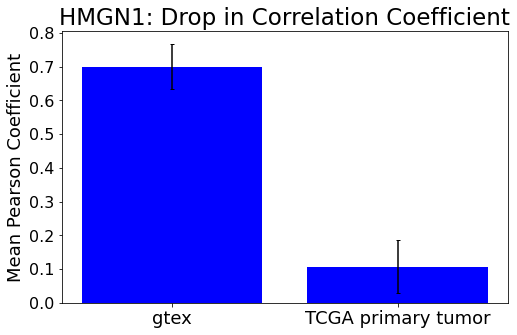

In [84]:
selected_gene='HMGN1'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


mean expression of ZMYM4 in gtex: 18.8049651416122
mean expression of ZMYM4 in TCGA primtum: 10.787575296262533
22.72% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

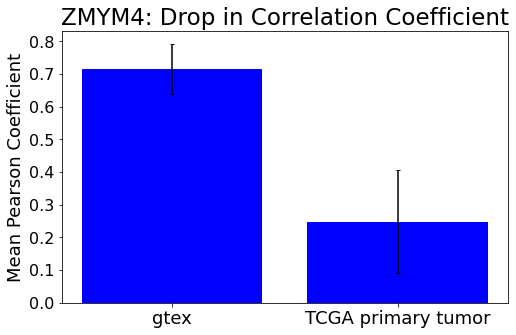

In [88]:
selected_gene='ZMYM4'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


mean expression of NFYC in gtex: 30.407952069716774
mean expression of NFYC in TCGA primtum: 10.014592433910666
6.15% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

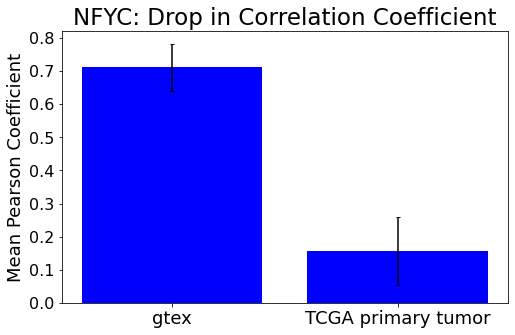

In [89]:
selected_gene='NFYC'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


mean expression of PI4KB in gtex: 58.44333333333333
mean expression of PI4KB in TCGA primtum: 11.137148222424795
3.05% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

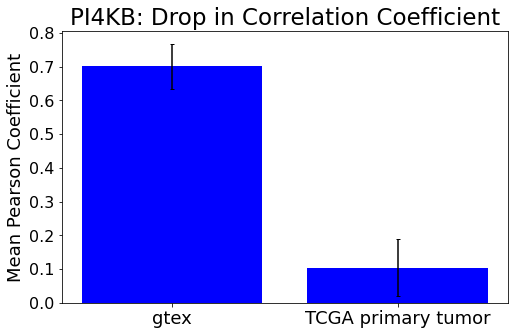

In [90]:
selected_gene='PI4KB'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


mean expression of POFUT2 in gtex: 24.290525054466233
mean expression of POFUT2 in TCGA primtum: 9.199047219690065
10.80% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

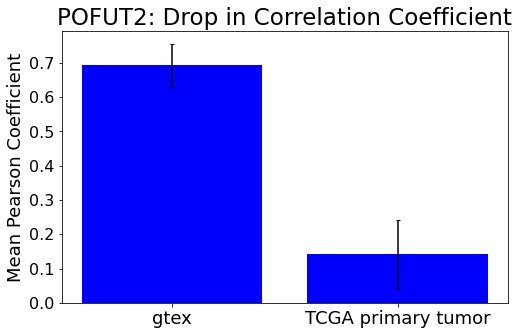

In [85]:
selected_gene='POFUT2'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


mean expression of DGCR2 in gtex: 51.71980392156863
mean expression of DGCR2 in TCGA primtum: 11.414161713764813
24.56% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

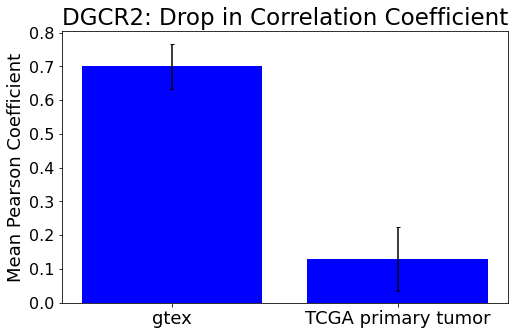

In [86]:
selected_gene='DGCR2'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


mean expression of DIDO1 in gtex: 20.298148148148147
mean expression of DIDO1 in TCGA primtum: 10.916486964448495
22.45% maintained in TCGA normal


Text(0, 0.5, 'Mean Pearson Coefficient')

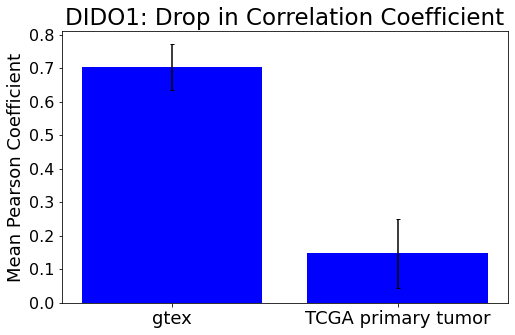

In [87]:

selected_gene='DIDO1'
print(f'mean expression of {selected_gene} in gtex: {df_int[selected_gene].mean()}')
print(f'mean expression of {selected_gene} in TCGA primtum: {tcga_brca_df_primtum_all[selected_gene].mean()}')
gtx_highcorr_list=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff]
common_gtx_tcga_primtum=gtx_highcorr_list.index.intersection(tcga_primtum_all_pearson_corr.index)
common_gtx_tcga_primtum=common_gtx_tcga_primtum.intersection(tcga_normal_all_pearson_corr.index)
#just counting how much maintained in TCGA normal
print(f'{tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape[0]/gtx_highcorr_list.shape[0]*100:.2f}% maintained in TCGA normal')
tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum][tcga_normal_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum]>=correlation_cutoff].shape
fig=plt.figure(figsize=(8,5))
#did not apply absolute values because i already set a positie correlation cutoff for gtex
#be careful
mean_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].mean()

std_t=gtex_pairwise_pearson_corr[selected_gene][gtex_pairwise_pearson_corr[selected_gene]>=correlation_cutoff].std()


#applying absolute values here since there are negative correlation coefficients
mean_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().mean()
std_p=tcga_primtum_all_pearson_corr[selected_gene].loc[common_gtx_tcga_primtum].abs().std()
plt.bar('gtex',height=mean_t,yerr=std_t,capsize=2,color='blue')


plt.bar('TCGA primary tumor',height=mean_p,yerr=std_p,capsize=2,color='blue')
plt.title(f'{selected_gene}: Drop in Correlation Coefficient',fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Mean Pearson Coefficient',fontsize=18)


# continue as normal from here on -- didn't change variables in detour

In [30]:
itg_gtex_corr=gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains("ITG")]].loc[gtex_pairwise_pearson_corr.columns[gtex_pairwise_pearson_corr.columns.str.contains("ITG")],:]
itg_tcga_normal_corr=tcga_normal_all_pearson_corr[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains("ITG")]].loc[tcga_normal_all_pearson_corr.columns[tcga_normal_all_pearson_corr.columns.str.contains("ITG")],:]
itg_tcga_primtum_corr=tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains("ITG")]].loc[tcga_primtum_all_pearson_corr.columns[tcga_primtum_all_pearson_corr.columns.str.contains("ITG")],:]



In [31]:
itg_gtex_corr_list=[]
itg_tcga_normal_list=[]
itg_tcga_primtum_list=[]

for integrin in itg_gtex_corr.columns:
    itg_gtex_corr_list.append([integrin+':',itg_gtex_corr[integrin][(itg_gtex_corr[integrin]>=correlation_cutoff) & (itg_gtex_corr[integrin].index!=integrin)].index.values])
for integrin in itg_gtex_corr.columns:
    itg_tcga_normal_list.append([integrin+':',itg_tcga_normal_corr[integrin][(itg_tcga_normal_corr[integrin]>=correlation_cutoff) & (itg_tcga_normal_corr[integrin].index!=integrin)].index.values])
for integrin in itg_gtex_corr.columns:
    itg_tcga_primtum_list.append([integrin+':',itg_tcga_primtum_corr[integrin][(itg_tcga_primtum_corr[integrin]>=correlation_cutoff) & (itg_tcga_primtum_corr[integrin].index!=integrin)].index.values])
    


In [32]:
itg_gtex_corr_list

[['ITGA10:', array(['ITGB4'], dtype=object)],
 ['ITGB6:', array(['ITGA2', 'ITGB8', 'ITGA3'], dtype=object)],
 ['ITGA6:', array([], dtype=object)],
 ['ITGA4:', array(['ITGB7', 'ITGAL'], dtype=object)],
 ['ITGAV:', array([], dtype=object)],
 ['ITGA9:', array([], dtype=object)],
 ['ITGB5:', array([], dtype=object)],
 ['ITGA1:', array([], dtype=object)],
 ['ITGA2:', array(['ITGB6', 'ITGB8', 'ITGA3', 'ITGB4'], dtype=object)],
 ['ITGB8:', array(['ITGB6', 'ITGA2', 'ITGA3', 'ITGB4'], dtype=object)],
 ['ITGA8:', array([], dtype=object)],
 ['ITGB1:', array([], dtype=object)],
 ['ITGB7:', array(['ITGA4', 'ITGAL'], dtype=object)],
 ['ITGA5:', array(['ITGB3'], dtype=object)],
 ['ITGA7:', array([], dtype=object)],
 ['ITGBL1:', array([], dtype=object)],
 ['ITGA11:', array([], dtype=object)],
 ['ITGAL:', array(['ITGA4', 'ITGB7'], dtype=object)],
 ['ITGAM:', array(['ITGAX', 'ITGB2'], dtype=object)],
 ['ITGAX:', array(['ITGAM', 'ITGB2'], dtype=object)],
 ['ITGAD:', array([], dtype=object)],
 ['ITGAE:', 

In [33]:
itg_tcga_normal_list

[['ITGA10:',
  array(['ITGA2', 'ITGA3', 'ITGB4', 'ITGB6', 'ITGB8'], dtype=object)],
 ['ITGB6:',
  array(['ITGA2', 'ITGA3', 'ITGB4', 'ITGB8', 'ITGA10'], dtype=object)],
 ['ITGA6:', array(['ITGA2'], dtype=object)],
 ['ITGA4:', array(['ITGAL'], dtype=object)],
 ['ITGAV:', array(['ITGA9', 'ITGA1', 'ITGB3'], dtype=object)],
 ['ITGA9:', array(['ITGA8', 'ITGA1', 'ITGAV'], dtype=object)],
 ['ITGB5:', array(['ITGA7', 'ITGAM'], dtype=object)],
 ['ITGA1:',
  array(['ITGA8', 'ITGA9', 'ITGA7', 'ITGAV', 'ITGB1'], dtype=object)],
 ['ITGA2:', array(['ITGA3', 'ITGA6', 'ITGB4', 'ITGB6', 'ITGB8', 'ITGA10'],
        dtype=object)],
 ['ITGB8:',
  array(['ITGA2', 'ITGA3', 'ITGB4', 'ITGB6', 'ITGA10'], dtype=object)],
 ['ITGA8:', array(['ITGA9', 'ITGA1'], dtype=object)],
 ['ITGB1:', array(['ITGA1', 'ITGA7', 'ITGB3'], dtype=object)],
 ['ITGB7:', array(['ITGAL'], dtype=object)],
 ['ITGA5:', array(['ITGAM', 'ITGB3'], dtype=object)],
 ['ITGA7:', array(['ITGA1', 'ITGB1', 'ITGB5'], dtype=object)],
 ['ITGBL1:', arra

In [34]:
itg_tcga_primtum_list


[['ITGA10:', array([], dtype=object)],
 ['ITGB6:', array([], dtype=object)],
 ['ITGA6:', array([], dtype=object)],
 ['ITGA4:', array(['ITGA1'], dtype=object)],
 ['ITGAV:', array(['ITGA1', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGA9:', array([], dtype=object)],
 ['ITGB5:', array([], dtype=object)],
 ['ITGA1:',
  array(['ITGA8', 'ITGA4', 'ITGAV', 'ITGB1', 'ITGB3'], dtype=object)],
 ['ITGA2:', array([], dtype=object)],
 ['ITGB8:', array([], dtype=object)],
 ['ITGA8:', array(['ITGA1'], dtype=object)],
 ['ITGB1:', array(['ITGA1', 'ITGAV'], dtype=object)],
 ['ITGB7:', array(['ITGAX', 'ITGAL', 'ITGB2'], dtype=object)],
 ['ITGA5:', array([], dtype=object)],
 ['ITGA7:', array([], dtype=object)],
 ['ITGBL1:', array(['ITGA11'], dtype=object)],
 ['ITGA11:', array(['ITGBL1'], dtype=object)],
 ['ITGAL:', array(['ITGAX', 'ITGB7', 'ITGB2'], dtype=object)],
 ['ITGAM:', array(['ITGAX', 'ITGB2'], dtype=object)],
 ['ITGAX:', array(['ITGAL', 'ITGAM', 'ITGB7', 'ITGB2'], dtype=object)],
 ['ITGAD:', array([],

In [59]:
tcga_primtum_all_pearson_corr[tcga_primtum_all_pearson_corr['ITGA11']>=correlation_cutoff]['ITGA11']

sample
GRP             0.638354
DPYSL3          0.731083
RUNX2           0.632867
KIAA1199        0.668260
LOC100192378    0.605808
                  ...   
VCAN            0.767879
PODNL1          0.697407
KIF26B          0.696320
PLAU            0.747129
ETV1            0.616663
Name: ITGA11, Length: 188, dtype: float64

In [60]:
gtex_pairwise_pearson_corr[gtex_pairwise_pearson_corr['ITGA11']>=correlation_cutoff]['ITGA11']

Description
FAM43B           0.607465
LINC01133        0.603542
HMCN1            0.640679
VASH2            0.668631
COL6A6           0.628378
SPSB4            0.671730
CTD-2297D10.2    0.622863
ADAMTS16         0.699766
NREP             0.600089
SOBP             0.634297
RP11-13P5.2      0.664702
FNDC1            0.656591
FNDC1-IT1        0.609305
KCNB2            0.614278
DNM1             0.646141
PRTFDC1          0.641837
PRR33            0.638812
WNT10B           0.683117
GALNT16          0.695860
CTD-2525P14.5    0.613385
IGDCC4           0.601744
ITGA11           1.000000
GAS7             0.624465
CTD-3035K23.7    0.629566
MRC2             0.672988
CTD-3035K23.3    0.618022
SSC5D            0.625283
MIR99AHG         0.616535
Name: ITGA11, dtype: float64

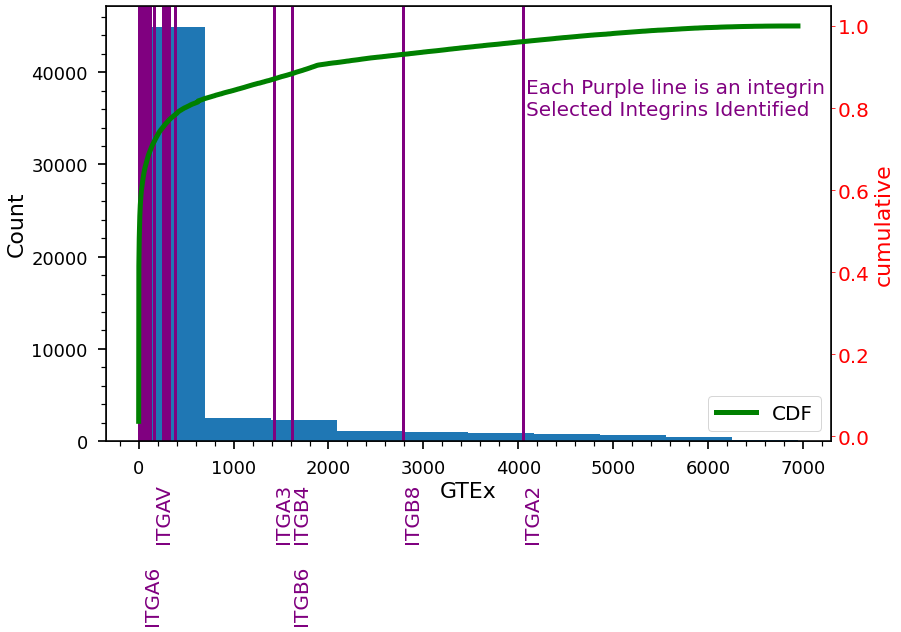

In [70]:
%matplotlib inline
fig,axs= plt.subplots(figsize=(13,8))
data=np.array(list_gtex_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count',fontsize=22)
plt.xlabel('GTEx',fontsize=22)

ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='green',linewidth=5,zorder=10)
ax.set_ylabel('cumulative', color='red',fontsize=22)
ax.tick_params(axis="y", colors="red",labelsize=20)
plt.axvline(43,color='purple',linewidth=3)
plt.text(43,-0.45,'ITGA6',rotation=90,color='purple',fontsize=20)
plt.axvline(5,color='purple',linewidth=3)
# plt.text(5,-0.2,'ITGA2B',rotation=90)
plt.axvline(24,color='purple',linewidth=3)
# plt.text(24,-0.3,'ITGAE',rotation=90)
plt.axvline(378,color='purple',linewidth=3)
# plt.text(378,-0.1,'ITGA10',rotation=90)
plt.axvline(1430,color='purple',linewidth=3)
plt.text(1430,-0.25,'ITGA3',rotation=90,color='purple',fontsize=20)
plt.axvline(1612,color='purple',linewidth=3)
plt.text(1612,-0.45,'ITGB6',rotation=90,fontsize=20,color='purple')
plt.axvline(1617,color='purple',linewidth=3)
plt.text(1617,-0.25,'ITGB4',rotation=90,fontsize=20,color='purple')
plt.axvline(2784,color='purple',linewidth=3)
plt.text(2784,-0.25,'ITGB8',rotation=90,color='purple',fontsize=20)
plt.axvline(4047,color='purple',linewidth=3)
plt.text(4047,-0.25,'ITGA2',rotation=90,color='purple',fontsize=20)
plt.axvline(22,color='purple',linewidth=3)
# plt.text(22,-0.4,'ITGB5',rotation=90)
plt.axvline(3,color='purple',linewidth=3)
# plt.text(3,-0.5,'ITGA9',rotation=90)
plt.axvline(4,color='purple',linewidth=3)
# plt.text(4,-0.6,'ITGAD',rotation=90)
plt.axvline(57,color='purple',linewidth=3)
# plt.text(57,-0.7,'ITGB3',rotation=90)
plt.axvline(70,color='purple',linewidth=3)
# plt.text(70,-0.8,'ITGB1',rotation=90)
plt.axvline(161,color='purple',linewidth=3)
plt.text(161,-0.25,'ITGAV',rotation=90,color='purple',fontsize=20)
plt.axvline(31,color='purple',linewidth=3)
# plt.text(31,-0.87,'ITGA8',rotation=90)
plt.axvline(317,color='purple',linewidth=3)
# plt.text(317,-0.18,'ITGA7',rotation=90)
plt.axvline(59,color='purple',linewidth=3)
# plt.text(59,-0.98,'ITGA5',rotation=90)
plt.axvline(314,color='purple',linewidth=3)
# plt.text(314,-0.3,'ITGAM',rotation=90)
plt.axvline(67,color='purple',linewidth=3)
# plt.text(67,-1.1,'ITGA1',rotation=90)
plt.axvline(115,color='purple',linewidth=3)
# plt.text(115,-0.43,'ITGA4',rotation=90)
plt.axvline(27,color='purple',linewidth=3)
# plt.text(27,-1.2,'ITGA11',rotation=90)
plt.axvline(7,color='purple',linewidth=3)
# plt.text(7,-1.3,'ITGBL1',rotation=90)
plt.axvline(101,color='purple',linewidth=3)
# plt.text(101,-0.53,'ITGAL',rotation=90)
plt.axvline(257,color='purple',linewidth=3)
# plt.text(257,-0.38,'ITGAX',rotation=90)
plt.axvline(83,color='purple',linewidth=3)
# plt.text(83,-1.4,'ITGB7',rotation=90)
plt.axvline(293,color='purple',linewidth=3)
# plt.text(293,-0.45,'ITGB2',rotation=90)


plt.text(0.58,0.75,'Each Purple line is an integrin\nSelected Integrins Identified',
         color='purple',fontsize=20,transform=axs.transAxes)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

    
    
axs.minorticks_on()
axs.tick_params(axis='both', which='major', labelsize=18, width = 1.7, size = 8,pad=10)
axs.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


plt.legend(fontsize=20)

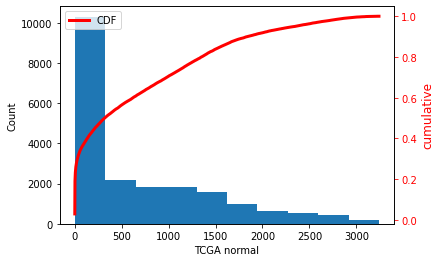

In [12]:
%matplotlib inline
data=np.array(list_tcga_normal_all_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count')
plt.xlabel('TCGA normal')
ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='red',linewidth=3)
ax.set_ylabel('cumulative', color='red',fontsize=12)
ax.tick_params(axis="y", colors="red")

plt.legend()

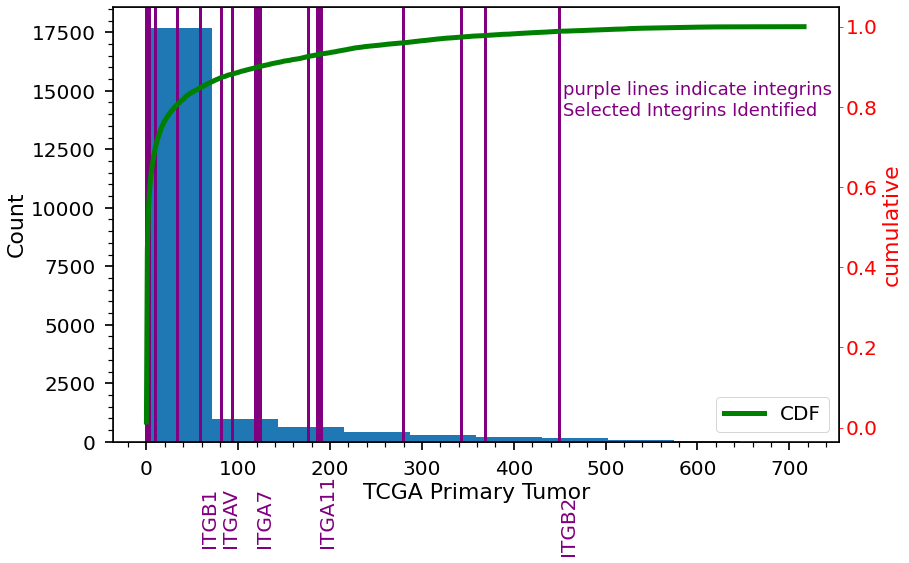

In [69]:
%matplotlib inline
fig,axs= plt.subplots(figsize=(13,8))
data=np.array(list_tcga_primtum_all_corr)  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=np.arange(0,max(data),1))
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.hist(data)
plt.ylabel('Count',fontsize=22)
plt.xlabel('TCGA Primary Tumor',fontsize=22)
ax=plt.twinx()

#plt.plot(bins_count[1:], pdf, color="red", label="PDF")
ax.plot(cdf, label="CDF",color='green',linewidth=5,zorder=10)
ax.set_ylabel('cumulative', color='red',fontsize=22)
ax.tick_params(axis="y", colors="red",labelsize=20)

plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.1,'ITGA6',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.2,'ITGA2B',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.3,'ITGAE',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.4,'ITGA10',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.5,'ITGA3',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.6,'ITGB6',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.7,'ITGB4',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.8,'ITGB8',rotation=90)
plt.axvline(0,color='purple',linewidth=3)
# plt.text(-14,0.9,'ITGA2',rotation=90)
plt.axvline(3,color='purple',linewidth=3)
# plt.text(3,-0.12,'ITGB5',rotation=90)
plt.axvline(9,color='purple',linewidth=3)
# plt.text(9,-0.2,'ITGA9',rotation=90)
plt.axvline(9,color='purple',linewidth=3)
# plt.text(9,-0.3,'ITGAD',rotation=90)
plt.axvline(33,color='purple',linewidth=3)
# plt.text(33,-0.1,'ITGB3',rotation=90)
plt.axvline(58,color='purple',linewidth=3)
plt.text(58,-0.29,'ITGB1',rotation=90,color='purple',fontsize=20)
plt.axvline(81,color='purple',linewidth=3)
plt.text(81,-0.29,'ITGAV',rotation=90,color='purple',fontsize=20)
plt.axvline(93,color='purple',linewidth=3)
# plt.text(93,-0.2,'ITGA8',rotation=90)
plt.axvline(118,color='purple',linewidth=3)
plt.text(118,-0.29,'ITGA7',rotation=90,color='purple',fontsize=20)
plt.axvline(122,color='purple',linewidth=3)
# plt.text(122,-0.3,'ITGA5',rotation=90)
plt.axvline(124,color='purple',linewidth=3)
# plt.text(124,-0.2,'ITGAM',rotation=90)
plt.axvline(176,color='purple',linewidth=3)
# plt.text(176,-0.1,'ITGA1',rotation=90)
plt.axvline(186,color='purple',linewidth=3)
# plt.text(186,-0.15,'ITGA4',rotation=90)
plt.axvline(187,color='purple',linewidth=3)
plt.text(187,-0.29,'ITGA11',rotation=90,color='purple',fontsize=20)
plt.axvline(190,color='purple',linewidth=3)
#plt.text(190,-0.29,'ITGBL1',rotation=90,color='purple',fontsize=20)
plt.axvline(279,color='purple',linewidth=3)
# plt.text(279,-0.1,'ITGAL',rotation=90)
plt.axvline(342,color='purple',linewidth=3)
# plt.text(342,-0.2,'ITGAX',rotation=90)
plt.axvline(369,color='purple',linewidth=3)
# plt.text(369,-0.2,'ITGB7',rotation=90)
plt.axvline(449,color='purple',linewidth=3)
plt.text(449,-0.31,'ITGB2',rotation=90,color='purple',fontsize=20)

plt.text(0.62,0.75,'purple lines indicate integrins\nSelected Integrins Identified',
         color='purple',fontsize=18,transform=axs.transAxes)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)

    
    
axs.minorticks_on()
axs.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
axs.tick_params(axis='both', which='minor', width = 1.2, size = 5)    


plt.legend(fontsize=20)

In [19]:
print('max # of highly correlated in gtex\t',np.max(np.array(list_gtex_corr)))
print('max # of lowly correlated in  gtex\t',np.max(np.array(list_gtex_oppcorr)))
print('max # of highly correlated in tcga normal',np.max(np.array(list_tcga_normal_all_corr)))
print('max # of lowly correlated in tcga normal',np.max(np.array(list_tcga_normal_all_oppcorr)))
print('max # of highly correlated in tcga tumor',np.max(np.array(list_tcga_primtum_all_corr)))
print('max # of lowly correlated in tcga tumor',np.max(np.array(list_tcga_primtum_all_oppcorr)))




max # of highly correlated in gtex	 6948
max # of lowly correlated in  gtex	 2560
max # of highly correlated in tcga normal 3243
max # of lowly correlated in tcga normal 3077
max # of highly correlated in tcga tumor 718
max # of lowly correlated in tcga tumor 464


In [111]:
#this is a chunking function. breaks down big dataframe into chunks
#this is a python generator. read about python generator
def chunkify(df: pd.DataFrame, chunk_size: int):
    global chunk_list
    chunk_list=[] 
    start = 0
    length = df.shape[0]

    # If DF is smaller than the chunk, return the DF
    if length <= chunk_size:
        chunk_list.append(df[:])
        yield df[:]
        return

    # Yield individual chunks
    while start + chunk_size <= length:
        chunk_list.append(df[start:chunk_size + start])
        yield df[start:chunk_size + start]
        start = start + chunk_size

    # Yield the remainder chunk, if needed
    if start < length:
        chunk_list.append(df[start:])
        yield df[start:]
    return chunk_list



<generator object chunkify at 0x2ab975d0a660>

# overlap tables

In [32]:
#gtex and tcga normal
gtex_overlap_tcganorm=tcga_brca_df_normal_all.columns.intersection(df_int.columns)
gtex_overlap_tcgaprim=tcga_brca_df_primtum_all.columns.intersection(df_int.columns)
tcganorm_overlap_tcgaprim=tcga_brca_df_primtum_all.columns.intersection(tcga_brca_df_normal_all.columns)
all_overlap_3datasets=tcga_brca_df_normal_all.columns.intersection(tcga_brca_df_primtum_all.columns.intersection(df_int.columns))

In [29]:
#gtex overlap with tcga normal
gtex_overlap_tcganorm

Index(['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1',
       'REM1', 'RTN4RL2', 'FGFR1OP2',
       ...
       'PLA2G2C', 'TULP2', 'NPY5R', 'GNGT2', 'GNGT1', 'TULP3', 'PTRF', 'BCL6B',
       'GSTK1', 'SELP'],
      dtype='object', length=17882)

In [30]:
#gtex overlap with tcga primtum
gtex_overlap_tcgaprim

Index(['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1',
       'REM1', 'RTN4RL2', 'FGFR1OP2',
       ...
       'PLA2G2C', 'TULP2', 'NPY5R', 'GNGT2', 'GNGT1', 'TULP3', 'PTRF', 'BCL6B',
       'GSTK1', 'SELP'],
      dtype='object', length=17882)

In [31]:
#tcga normal overlap with tcga primtum
tcganorm_overlap_tcgaprim

Index(['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1',
       'REM1', 'MTVR2', 'RTN4RL2',
       ...
       'TULP2', 'NPY5R', 'GNGT2', 'GNGT1', 'TULP3', 'PTRF', 'BCL6B', 'GSTK1',
       'SELP', 'SELS'],
      dtype='object', name='sample', length=20526)

In [33]:
#intersection between gtex, tcga normal, tcga primtum
all_overlap_3datasets

Index(['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1',
       'REM1', 'RTN4RL2', 'FGFR1OP2',
       ...
       'PLA2G2C', 'TULP2', 'NPY5R', 'GNGT2', 'GNGT1', 'TULP3', 'PTRF', 'BCL6B',
       'GSTK1', 'SELP'],
      dtype='object', length=17882)

# mean expression

In [65]:
print('GTEX mean expression',
     df_int[df_int.columns[df_int.columns.str.contains("ITG")]].mean())
#plt.hist(df_int[df_int.columns[df_int.columns.str.contains("ITG")]].stack().values)
#plt.xlabel("GTEX expression of integrins")

GTEX mean expression Description
ITGA10     18.636163
ITGB6       8.011653
ITGA6      74.201394
ITGA4       2.537199
ITGAV      33.549281
ITGA9      10.789229
ITGB5     105.482070
ITGA1      25.240782
ITGA2       6.582717
ITGB8       8.347091
ITGA8       5.356911
ITGB1     165.202745
ITGB7       1.772337
ITGA5     101.974597
ITGA7     152.552854
ITGBL1     12.984770
ITGA11      4.763115
ITGAL       4.353107
ITGAM       6.857535
ITGAX       8.938757
ITGAD       0.191340
ITGAE       8.233599
ITGA2B      1.354293
ITGB3       9.450959
ITGA3      42.656767
ITGB4      79.547183
ITGB2      22.760176
dtype: float64


In [41]:
print('GTEX stdev')
df_int[df_int.columns[df_int.columns.str.contains("ITG")]].std()

GTEX stdev


Description
ITGA10     21.482509
ITGB6      10.906813
ITGA6      27.932640
ITGA4       1.805284
ITGAV      10.379794
ITGA9       3.999900
ITGB5      37.792078
ITGA1      11.047026
ITGA2       6.178808
ITGB8       8.815133
ITGA8      10.317605
ITGB1      60.525226
ITGB7       1.301917
ITGA5      69.008709
ITGA7     102.063463
ITGBL1     10.195488
ITGA11      4.559201
ITGAL       3.455074
ITGAM       8.569870
ITGAX      23.171772
ITGAD       0.248363
ITGAE       2.104676
ITGA2B      0.718481
ITGB3       7.850063
ITGA3      23.391662
ITGB4      62.625597
ITGB2      42.348579
dtype: float64

In [43]:
print('tcga normal mean expression')
tcga_brca_df_normal_all[tcga_brca_df_normal_all.columns[tcga_brca_df_normal_all.columns.str.contains("ITG")]].mean()

tcga normal mean expression


sample
ITGA8      5.701889
ITGA9      8.637365
ITGA1     10.486270
ITGA2     10.225679
ITGA3     11.127952
ITGA4      7.999898
ITGA5     10.850209
ITGA6     12.336755
ITGA7     10.879302
ITGAX      7.285686
ITGAV     11.684366
ITGAL      8.069091
ITGAM      8.076772
ITGA2B     2.592046
ITGAD      2.051825
ITGAE      7.915842
ITGBL1     9.169968
ITGB1     14.179339
ITGB3      8.122284
ITGB5     12.061787
ITGB4     11.849429
ITGB7      6.483920
ITGB6      9.843988
ITGB8      9.714920
ITGA10     7.380227
ITGA11     9.395983
ITGB2      9.847525
dtype: float64

In [44]:
print('tcga normal stdev')
tcga_brca_df_normal_all[tcga_brca_df_normal_all.columns[tcga_brca_df_normal_all.columns.str.contains("ITG")]].std()

tcga normal stdev


sample
ITGA8     1.547120
ITGA9     0.639188
ITGA1     0.935311
ITGA2     1.485973
ITGA3     0.927977
ITGA4     0.890640
ITGA5     0.691093
ITGA6     0.479265
ITGA7     1.591815
ITGAX     1.136931
ITGAV     0.549901
ITGAL     0.812636
ITGAM     1.011695
ITGA2B    0.918122
ITGAD     1.375498
ITGAE     0.439250
ITGBL1    0.706996
ITGB1     0.587906
ITGB3     0.904626
ITGB5     0.592331
ITGB4     0.978342
ITGB7     0.836718
ITGB6     2.839599
ITGB8     1.723763
ITGA10    1.293408
ITGA11    0.770331
ITGB2     1.004598
dtype: float64

In [45]:
print('tcga primary tumor mean expression')
tcga_brca_df_primtum_all[tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains("ITG")]].mean()

tcga primary tumor mean expression


sample
ITGA8      4.553092
ITGA9      6.862222
ITGA1      9.271980
ITGA2      9.587534
ITGA3     10.601134
ITGA4      8.256462
ITGA5     11.028041
ITGA6     10.931272
ITGA7      7.362384
ITGAX      8.363760
ITGAV     11.654986
ITGAL      8.754285
ITGAM      8.332223
ITGA2B     2.932375
ITGAD      2.530253
ITGAE      7.850368
ITGBL1     9.391825
ITGB1     13.503200
ITGB3      6.810198
ITGB5     12.131903
ITGB4     10.972243
ITGB7      7.031608
ITGB6      9.566721
ITGB8      8.605474
ITGA10     6.115233
ITGA11     9.877239
ITGB2     10.474842
dtype: float64

In [47]:
print('tcga primary tumor stdev')
tcga_brca_df_primtum_all[tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains("ITG")]].std()

tcga primary tumor stdev


sample
ITGA8     1.788216
ITGA9     1.346935
ITGA1     1.036842
ITGA2     1.372044
ITGA3     1.064084
ITGA4     1.168296
ITGA5     0.797567
ITGA6     1.179812
ITGA7     1.465651
ITGAX     1.067021
ITGAV     0.830474
ITGAL     1.329156
ITGAM     1.164785
ITGA2B    1.526727
ITGAD     1.531709
ITGAE     0.652547
ITGBL1    1.504451
ITGB1     0.607595
ITGB3     1.338863
ITGB5     0.918715
ITGB4     1.422951
ITGB7     1.358623
ITGB6     2.130994
ITGB8     1.825466
ITGA10    1.492357
ITGA11    1.588570
ITGB2     1.166095
dtype: float64

# formally do all integrins, tables 1, 2 and 3 using the functions

In [7]:
#table 1
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                             tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA7,317,77.287066(245),7.886435(25),7.886435(25)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB8,2784,40.696839(1133),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB6,1612,40.198511(648),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA10,378,38.095238(144),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA6,43,16.279070(7),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA4,115,37.391304(43),20.000000(23),17.391304(20)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAV,161,73.291925(118),1.863354(3),1.863354(3)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA9,3,33.333333(1),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB5,22,68.181818(15),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA1,67,71.641791(48),34.328358(23),34.328358(23)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA2,4047,37.385718(1513),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA8,31,6.451613(2),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB1,70,91.428571(64),2.857143(2),2.857143(2)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB7,83,33.734940(28),48.192771(40),31.325301(26)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA5,59,18.644068(11),3.389831(2),1.694915(1)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGBL1,7,14.285714(1),57.142857(4),14.285714(1)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA11,27,18.518519(5),14.814815(4),3.703704(1)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAL,101,77.227723(78),75.247525(76),66.336634(67)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAM,314,43.630573(137),24.203822(76),21.337580(67)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAX,257,40.077821(103),36.964981(95),30.350195(78)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAD,4,0.000000(0),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAE,24,8.333333(2),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA2B,5,0.000000(0),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB3,57,10.526316(6),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGA3,1430,48.881119(699),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB4,1617,47.619048(770),0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGB2,293,45.733788(134),40.614334(119),32.764505(96)


In [11]:
#table 2
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA7,317,0.000000(0),21.766562(69)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB8,2784,3.268678(91),39.152299(1090)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB6,1612,1.116625(18),44.044665(710)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA10,378,0.793651(3),40.476190(153)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA6,43,16.279070(7),11.627907(5)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA4,115,0.869565(1),0.869565(1)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAV,161,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA9,3,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB5,22,0.000000(0),22.727273(5)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA1,67,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA2,4047,3.187546(129),35.211268(1425)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA8,31,32.258065(10),32.258065(10)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB1,70,0.000000(0),7.142857(5)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB7,83,1.204819(1),7.228916(6)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA5,59,11.864407(7),3.389831(2)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGBL1,7,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA11,27,0.000000(0),11.111111(3)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAL,101,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAM,314,3.184713(10),7.324841(23)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAX,257,1.556420(4),8.560311(22)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAD,4,0.000000(0),0.000000(0)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGAE,24,0.000000(0),4.166667(1)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA2B,5,0.000000(0),60.000000(3)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB3,57,14.035088(8),14.035088(8)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA3,1430,4.195804(60),53.356643(763)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB4,1617,3.710575(60),49.350649(798)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGB2,293,3.071672(9),5.119454(15)


In [13]:
#table 3
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

# make_data_presentable(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
#                          tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for interest_gene in integrins_list:
    organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)



for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA7,152.55 + 102.06,317,1467,118


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB8,8.35 + 8.82,2784,2772,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB6,8.01 + 10.91,1612,1905,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA10,18.64 + 21.48,378,2255,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA6,74.20 + 27.93,43,945,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA4,2.54 + 1.81,115,415,186


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAV,33.55 + 10.38,161,942,81


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA9,10.79 + 4.00,3,666,9


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB5,105.48 + 37.79,22,527,3


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA1,25.24 + 11.05,67,1192,176


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA2,6.58 + 6.18,4047,2959,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA8,5.36 + 10.32,31,233,93


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB1,165.20 + 60.53,70,1363,58


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB7,1.77 + 1.30,83,123,369


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA5,101.97 + 69.01,59,771,122


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGBL1,12.98 + 10.20,7,1,190


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA11,4.76 + 4.56,27,12,187


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAL,4.35 + 3.46,101,284,279


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAM,6.86 + 8.57,314,497,124


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAX,8.94 + 23.17,257,196,342


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAD,0.19 + 0.25,4,16,9


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAE,8.23 + 2.10,24,140,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA2B,1.35 + 0.72,5,0,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB3,9.45 + 7.85,57,550,33


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGA3,42.66 + 23.39,1430,2738,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB4,79.55 + 62.63,1617,2731,0


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGB2,22.76 + 42.35,293,350,449


In [14]:
#just putting the same functions as above in this cell so there's not too many input variables. creating table 4
#below helper functions (i.e. all except the last one) have some modifications and only apply to table 4
#helper functions also appear above in jp notebook so don't touch those
def cutoff_applied_totcga_2_high_low(interest_gene,correlation_method,correlation_cutoff,opposing_corr_cutoff,gtex_dataset,other_dataset,first_dataset_name):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
#    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: low cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]<=opposing_corr_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def cutoff_applied_totcga_2_high_both(interest_gene,correlation_method,correlation_cutoff,gtex_dataset,other_dataset):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    gtex_dataset=correlation_selected_gene(gtex_dataset,interest_gene,correlation_method)
    dataset2=correlation_selected_gene(other_dataset,interest_gene,correlation_method)
    dataset2 = dataset2[dataset2>=correlation_cutoff]
    common_gene_list= gtex_dataset.index.intersection(dataset2.index)
    global new_dataset    
    new_dataset = pd.concat([gtex_dataset[common_gene_list],dataset2[common_gene_list]],axis=1)
    first_dataset_name = 'gtex_all'
    other_dataset_name='tcga_primtum_all_cutoffmet'
    new_dataset.columns=[first_dataset_name,other_dataset_name]
    print("1st: high cutoff applied to tcga dataset\n2nd: common genes identified with gtex dataset\n3rd: both datasets combined\n4th: High cutoff applied to gtex dataset")

    new_dataset = new_dataset[new_dataset[first_dataset_name]>=correlation_cutoff]
    dict_pd_df = pd.DataFrame(data=[[new_dataset.shape[0],new_dataset.shape[0]]],
                             index=[f'high_corr_with_{interest_gene}_both_same_genes'],
                             columns=[first_dataset_name,other_dataset_name])
    return dict_pd_df
def count_high_corr_genes_no_overlap(interest_gene,correlation_method,correlation_cutoff,dataset_name,*processed_datasets):
#make sure to preprocess dataset
#dictionary only takes unique values, careful about this
    print('no overlap between datasets')
    dict_empty={}
    j=0
    for dataset in processed_datasets:
        dataset=correlation_selected_gene(dataset,interest_gene,correlation_method)
        dict_empty[dataset_name]=dataset[dataset>=correlation_cutoff].shape[0]
        
        j+=1
    
    dict_pd_df = pd.DataFrame(dict_empty,index=[f'HIGHLY_correlated_with_{interest_gene}'])
    #return display(HTML(dict_pd_df.to_html()))
    return dict_pd_df


#table 4
integrins_list=['ITGA7','ITGB8','ITGB6','ITGA10','ITGA6','ITGA4','ITGAV','ITGA9','ITGB5','ITGA1','ITGA2','ITGA8',
'ITGB1','ITGB7','ITGA5','ITGBL1','ITGA11','ITGAL','ITGAM','ITGAX','ITGAD','ITGAE','ITGA2B','ITGB3','ITGA3',
                'ITGB4','ITGB2']

gtex_gct_dataset = 'gene_tpm_2017-06-05_v8_breast_mammary_tissue.gct_2'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
opposing_corr_cutoff = 0.1

for interest_gene in integrins_list:
    organize_tcga_gtex_table4(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                             tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)




its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA7,118,2.542373(3),22.881356(27),21.186441(25)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB8,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB6,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA10,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA6,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA4,186,15.053763(28),20.430108(38),12.365591(23)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAV,81,0.000000(0),0.000000(0),3.703704(3)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA9,9,0.000000(0),11.111111(1),0.000000(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB5,3,33.333333(1),33.333333(1),0.000000(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA1,176,6.818182(12),21.022727(37),13.068182(23)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA2,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA8,93,1.075269(1),40.860215(38),0.000000(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB1,58,5.172414(3),17.241379(10),3.448276(2)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB7,369,1.897019(7),18.428184(68),10.840108(40)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA5,122,6.557377(8),19.672131(24),1.639344(2)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGBL1,190,45.263158(86),10.526316(20),2.105263(4)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA11,187,25.133690(47),16.042781(30),2.139037(4)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAL,279,2.867384(8),9.318996(26),27.240143(76)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAM,124,1.612903(2),8.870968(11),61.290323(76)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAX,342,1.754386(6),16.959064(58),27.777778(95)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAD,9,0.000000(0),11.111111(1),0.000000(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGAE,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA2B,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB3,33,0.000000(0),30.303030(10),0.000000(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGA3,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in long_scalars
/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB4,0,nan(0),nan(0),nan(0)


its TCGA_primtum_all
no overlap between datasets
common gene list applied to all
high tcga_primtum and low tcga normal
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga_primtum and low gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: low cutoff applied to gtex dataset
high tcga primtum, high gtex
1st: high cutoff applied to tcga dataset
2nd: common genes identified with gtex dataset
3rd: both datasets combined
4th: High cutoff applied to gtex dataset


,TCGA_tumor_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_gtex,%highly_corelated_in_gtex
ITGB2,449,1.113586(5),27.171492(122),26.503341(119)


# scratch work

In [106]:
test_normal_matched=tcga_brca_df_normal_matched.copy().T
test_primtum_matched=tcga_brca_df_primtum_matched.copy().T
test_normal_matched['patient']=[x.split('-')[2] for x in test_normal_matched.index]
test_primtum_matched['patient']=[x.split('-')[2] for x in test_primtum_matched.index]



In [127]:
test_normal_matched.loc[test_normal_matched.index.str.contains('A1NF')]['ITGA2']

TCGA-E9-A1NF-11    6.6647
Name: ITGA2, dtype: float64

In [126]:
test_primtum_matched.loc[test_primtum_matched.index.str.contains('A1NF')]['ITGA2']

TCGA-E9-A1NF-01    9.4602
Name: ITGA2, dtype: float64

In [125]:
test_normal_matched.merge(test_primtum_matched,left_on='patient',right_on='patient',suffixes=('_normal','_primtum'))[['ITGA2_normal','ITGA2_primtum','patient']]


sample,ITGA2_normal,ITGA2_primtum,patient
0,9.0078,10.4154,A0CH
1,7.2808,10.2782,A1RC
2,6.9078,10.1341,A0DB
3,6.8952,11.4929,A0H9
4,10.8308,7.2946,A0E0
...,...,...,...
107,5.8302,12.0081,A0B5
108,6.6647,9.4602,A1NF
109,9.9696,7.0959,A13E
110,10.3288,10.3721,A2FB


In [85]:
test_primtum_matched.sort_values(by='patient',axis=1)



,TCGA-BH-A0AU-01,TCGA-BH-A0AY-01,TCGA-BH-A0AZ-01,TCGA-BH-A0B3-01,TCGA-BH-A0B5-01,TCGA-BH-A0B7-01,TCGA-BH-A0B8-01,TCGA-BH-A0BA-01,TCGA-BH-A0BC-01,TCGA-BH-A0BJ-01,...,TCGA-BH-A203-01,TCGA-BH-A204-01,TCGA-BH-A208-01,TCGA-BH-A209-01,TCGA-AC-A23H-01,TCGA-GI-A2C8-01,TCGA-GI-A2C9-01,TCGA-AC-A2FB-01,TCGA-AC-A2FF-01,TCGA-AC-A2FM-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.5015,9.1019,9.4325,9.708,10.2724,9.1984,9.2149,8.7218,9.1227,9.5628,...,9.178,8.3993,8.8424,8.1128,8.8195,9.5326,10.5932,9.9276,9.3051,10.679
HIF3A,3.6705,3.9797,3.4037,3.1799,2.5858,4.3177,1.7207,5.2743,2.386,1.8117,...,1.8112,1.8061,3.8589,1.8732,0.3758,2.1199,4.462,4.6244,6.7452,4.0906
RNF17,0,0,0,1.1055,0,0,0,0,0,0,...,0,0,0,1.3102,0,0,0.738,0,1.7024,0
RNF10,12.3658,11.8532,11.9718,12.2457,11.9089,11.4783,11.6224,12.3758,12.031,11.7872,...,12.0492,11.9913,12.1381,12.5444,11.763,11.6077,11.1465,11.8653,11.9374,12.1069
RNF11,11.3783,10.7975,11.0161,10.7971,10.7238,12.3537,9.9587,11.4299,11.6193,11.3273,...,11.407,10.5923,12.0221,10.7306,11.4354,10.7229,11.5265,11.3595,11.3904,11.0782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCL6B,7.3686,8.8882,9.3795,7.5246,8.3274,8.8696,8.0273,8.7781,9.6162,8.786,...,7.9993,8.1032,9.6822,7.3941,7.7196,9.0959,6.3892,8.3494,9.8208,8.713
GSTK1,11.0682,10.6636,10.922,10.7451,10.8841,11.1012,10.4163,11.0698,10.819,11.7796,...,10.5769,10.9072,10.8196,10.3799,10.2207,13.1707,11.4231,11.1862,11.3744,10.6288
SELP,7.2496,7.8754,7.3313,4.7606,6.2298,9.7545,7.14,7.6148,7.8765,7.4148,...,6.7235,3.8472,6.0042,8.2468,1.8789,6.5293,2.5047,10.3111,10.1394,5.3608


In [36]:
str(test_normal_matched.columns.values).split('-')

["['TCGA",
 'A7',
 'A0CH',
 "11' 'TCGA",
 'E9',
 'A1RC',
 "11' 'TCGA",
 'A7',
 'A0DB',
 "11' 'TCGA",
 'BH',
 'A0H9',
 "11'\n 'TCGA",
 'BH',
 'A0E0',
 "11' 'TCGA",
 'BH',
 'A0HA',
 "11' 'TCGA",
 'BH',
 'A18P',
 "11' 'TCGA",
 'E9',
 'A1N4',
 "11'\n 'TCGA",
 'BH',
 'A18U',
 "11' 'TCGA",
 'E2',
 'A1LS',
 "11' 'TCGA",
 'AC',
 'A2FM',
 "11' 'TCGA",
 'BH',
 'A18M',
 "11'\n 'TCGA",
 'BH',
 'A0B3',
 "11' 'TCGA",
 'BH',
 'A0C0',
 "11' 'TCGA",
 'BH',
 'A0H7',
 "11' 'TCGA",
 'BH',
 'A0BM',
 "11'\n 'TCGA",
 'E2',
 'A1BC',
 "11' 'TCGA",
 'BH',
 'A0DG',
 "11' 'TCGA",
 'BH',
 'A0B7',
 "11' 'TCGA",
 'BH',
 'A1ET',
 "11'\n 'TCGA",
 'BH',
 'A0B8',
 "11' 'TCGA",
 'E2',
 'A15I',
 "11' 'TCGA",
 'BH',
 'A18L',
 "11' 'TCGA",
 'BH',
 'A0DZ',
 "11'\n 'TCGA",
 'E9',
 'A1N5',
 "11' 'TCGA",
 'E9',
 'A1N6',
 "11' 'TCGA",
 'BH',
 'A18R',
 "11' 'TCGA",
 'BH',
 'A1EO',
 "11'\n 'TCGA",
 'AC',
 'A23H',
 "11' 'TCGA",
 'BH',
 'A18N',
 "11' 'TCGA",
 'A7',
 'A0CE',
 "11' 'TCGA",
 'BH',
 'A0AY',
 "11'\n 'TCGA",
 'E9',
 'A1ND

In [22]:
tcga_brca_df_primtum_matched.loc['ITGA2']


TCGA-BH-A0BQ-01    11.1287
TCGA-BH-A0BT-01     8.3342
TCGA-BH-A18J-01     9.9518
TCGA-BH-A0HA-01     9.6888
TCGA-A7-A0CE-01    11.5923
                    ...   
TCGA-BH-A0DG-01    10.8546
TCGA-E9-A1N5-01    10.4105
TCGA-E2-A153-01     9.7459
TCGA-BH-A0B7-01    10.4329
TCGA-BH-A0DO-01    10.4386
Name: ITGA2, Length: 112, dtype: float64

In [77]:
organize_gtex_tcga_table1(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: High cutoff applied to non-gtex dataset
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other datasets
3rd: all datasets combined
4th: High cutoff applied to non-gtex datasets


,GTEX_highly_correlated,%also_highly_correlated_in_TCGA_normal,%also_highly_correlated_in_TCGA_primtum,%also_highly_correlated_in_all_three
ITGAX,257,40.077821(103),36.964981(95),30.350195(78)


In [32]:
organize_gtex_tcga_table2(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for dataset ENTER: tcga_normal_all
insert name for other datasettcga_normal_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset
for dataset ENTER: tcga_primtum_all
insert name for other datasettcga_primtum_all
1st: high cutoff applied to gtex dataset
2nd: common genes identified with other dataset
3rd: both datasets combined
4th: low cutoff applied to non-gtex dataset


,GTEX_highly_correlated,%lowly_correlated_in_TCGA_normal,%lowly_correlated_in_TCGA_primtum
ITGA7,317,0.000000(0),21.766562(69)


In [78]:
organize_no_overlap_table3(interest_gene,correlation_method, correlation_cutoff,opposing_corr_cutoff,gtex_gct_dataset,
                         tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)


for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_normal_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_normal_all
for 1th dataset ENTER: gtex_all
for 2th dataset ENTER: tcga_primtum_all
no overlap between datasets
insert name for 1th datasetgtex_all
insert name for 2th datasettcga_primtum_all


,GTEX_expression_mean_&_stdev,GTEX_highly_correlated,highly_correlated_in_TCGA_normal,highly_corelated_in_TCGA_primtum
ITGAX,8.94 + 23.17,257,196,342


In [75]:
gtex_test[gtex_test.columns[gtex_test.columns.str.contains("ITG")]]

Description,ITGA10,ITGB6,ITGA6,ITGA4,ITGAV,ITGA9,ITGB5,ITGA1,ITGA2,ITGB8,...,ITGAL,ITGAM,ITGAX,ITGAD,ITGAE,ITGA2B,ITGB3,ITGA3,ITGB4,ITGB2
GTEX-1117F-2826-SM-5GZXL,26.660,4.0630,64.53,1.0940,30.85,9.045,161.50,24.31,4.8800,6.5180,...,2.856,2.9380,6.4620,0.0619,6.577,2.0960,17.700,44.29,48.63,5.644
GTEX-111YS-1926-SM-5GICC,40.580,8.6670,80.77,2.3370,41.52,11.730,84.21,26.15,8.6830,12.4000,...,3.977,1.6610,3.3690,0.0219,5.686,0.8640,6.213,38.93,77.83,7.989
GTEX-1122O-1226-SM-5H113,25.150,4.4230,62.86,4.9140,35.61,11.150,90.79,22.51,4.1400,8.1060,...,2.816,10.6300,3.1200,0.3853,8.283,0.8111,9.594,33.19,96.58,27.590
GTEX-117XS-1926-SM-5GICO,3.131,0.0799,83.15,2.3110,30.58,6.013,118.90,39.59,2.2420,0.8251,...,6.755,9.2130,17.1400,0.3599,10.170,1.8370,6.471,28.82,70.39,48.720
GTEX-117YX-1426-SM-5H12H,4.192,0.0649,28.96,1.3680,24.32,8.683,68.26,10.97,0.6376,1.3710,...,1.849,15.4200,2.1920,0.0731,5.879,0.6185,6.386,10.60,19.44,43.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZYFC-0826-SM-5E44K,2.070,0.5010,100.90,1.9830,29.83,4.940,118.00,54.48,1.1100,0.8023,...,5.253,6.1100,7.0290,0.2819,9.798,2.0110,10.490,30.41,31.50,11.210
GTEX-ZYT6-0126-SM-5E45J,3.779,0.1647,98.94,1.4730,21.16,10.800,96.98,31.49,1.6630,0.6112,...,5.823,4.1250,2.5420,0.1390,9.708,2.2600,6.521,21.96,40.66,8.177
GTEX-ZYW4-0826-SM-5GIDG,8.663,0.2067,22.88,1.0020,26.08,6.079,122.30,21.21,0.8370,2.5160,...,2.145,4.7770,3.7860,0.1476,5.169,0.9999,13.310,27.05,33.45,11.200
GTEX-ZZ64-1226-SM-5E43R,3.342,0.0537,31.63,0.2916,26.81,15.360,98.44,24.32,0.4011,0.2316,...,0.262,0.9996,0.8714,0.0000,5.824,1.7490,2.966,19.83,16.93,3.777
